<a href="https://colab.research.google.com/github/felix-rosenberger/image-classification/blob/main/Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Kaggle Username: Felix Rosenberger

# Introduction

This notebook is for the major project submission for COMP7220/8220, on the [image/language] dataset and task.  It contains the following sections:

*   a description of the selected conventional ML model;
*   some notes about the choices made in building the conventional ML model;
*   a description of the selected deep learning model;
*   some notes about the choices made in building the deep model; and
*   a discussion of the performance of the two models.



# Library and Data Import

In [1]:
# library import
import os
import gc
import joblib
from google.colab import drive
from skimage.feature import hog, corner_harris, corner_peaks, local_binary_pattern, canny, graycomatrix, graycoprops
from skimage.filters import unsharp_mask
from skimage import exposure
from scipy import ndimage as ndi
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import class_weight
import xgboost as xgb
import lightgbm as lgb
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# notebook setup
drive.mount('/content/gdrive')
os.chdir('/content/gdrive/My Drive/Master/Colab Notebooks/COMP8220/Major_Project/image-classification')

Mounted at /content/gdrive


In [7]:
# read data in
train = np.load('Data/Training_data_images.npy')
test = np.load('Data/PublicTest_data_images.npy')
labels = np.load('Data/Training_data_labels.npy')

# Basic Data Exploration

Let's first have a look at the different arrays.

In [ ]:
# training data
print(f'The training data: \t{train.shape}\n'
      f'The test data: \t\t{test.shape}\n'
      f'The label data: \t{labels.shape}\n')


The training data: 	(9328, 48, 48)
The test data: 		(1136, 48, 48)
The label data: 	(9328,)



We can see that the **training data consists of 9328 images**, each of which is a 48x48 array itself. The image size represents the pixels of each image. Similarly, the test data consists of 1136 images. The label data is vector containing the labels of the 9328 training images. We'll know look at the labels in more detail.

In [ ]:
np.unique(labels)

array([0, 1, 2, 3, 4, 5, 6])

The integers shown are the unique image labels which correspond to emotions displayes on the images. The above order correspond to the labels **[angry, disgusted, fearful, happy, sad, surprised, neutral]**.
Let's look at the first 6 images and corresponding labels.

In [ ]:
# create label dict
keys = list(np.unique(labels))
values = ['angry', 'disgusted', 'fearful', 'happy', 'sad', 'surprised', 'neutral']
label_classes = dict(zip(keys, values)) # provide key value pairs using zip
print(label_classes)

{0: 'angry', 1: 'disgusted', 2: 'fearful', 3: 'happy', 4: 'sad', 5: 'surprised', 6: 'neutral'}


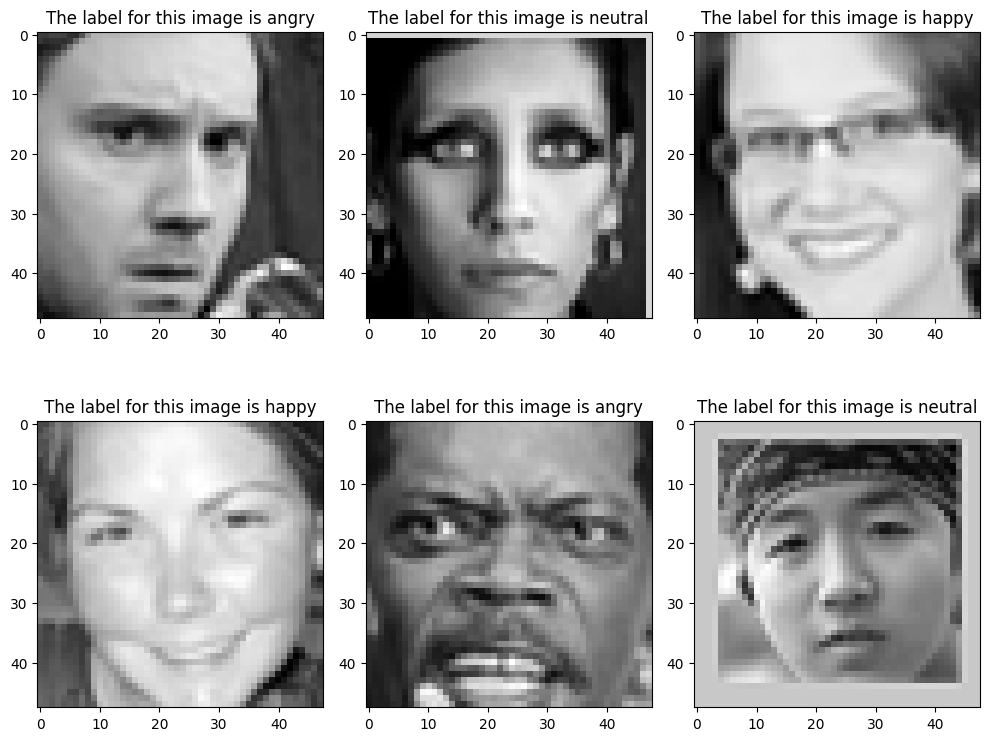

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10, 8))
for i in range(len(train[0:6])):
    lookup_key = labels[i]
    subplot = ax[i // 3, i % 3] # get current subplot
    subplot.imshow(train[i], cmap='gray') # plot image on the current subplot
    subplot.set_title(f'The label for this image is {label_classes[lookup_key]}') # set title to corresponding label

plt.tight_layout() # no overlap
plt.show()

Next we'll look at the range of pixel sizes for each image.

In [ ]:
# loop through all images and check min max values
n = 0
for i in range(len(train)):
  min_val = np.min(train[i])
  max_val = np.max(train[i])
  if min_val < 0 and max_val > 1:
    print('values out of normalisation range')
  else:
    n += 1

print(f'All pixel values are between 0 and 1') if n == len(train) else print(f'Pixel scales are not aligned')

All pixel values are between 0 and 1


We now know that all pixel sizes are between 0 and 1. Hence normalisation is not required at a later stage for preprocessing. Let's check for missing values.

In [ ]:
missing = []
for i, image in enumerate(train):
  flat_image = image.flatten() # flatten image into vector
  nan_bool = list(np.isnan(flat_image)) # create list of boolean values if missing
  for j, pixel in enumerate(nan_bool):
    if pixel==True:
      image_position = i # get image position in train data
      pixel_position = j # get pixel position in flattened image
      pixel_value = flat_image[j] # get pixel value
      missing.append(tuple([image_position, pixel_position, pixel_value]))

print(len(missing))

0


There are no missing values in the training data.

# Data Preprocessing and Feature Extraction

## Baseline
Before diving into ML models, we need to establish a baseline against complex models are evaluated, i.e., to assess whether they actually add value. The most simple approach would just be to assign classes based on their training data representation. Hence any ML model only adds value if it improves the below classification accuracies. One method could be to just predict the most frequent class which is **happy (29.33%) and use this as a benchmark**. A model has to be at least as good.

In [ ]:
# get unique labels and number of occurrence
unique, counts = np.unique(labels, return_counts=True)

# calculate percentages
total_samples = len(labels)
percentages = (counts / total_samples) * 100

# map unique labels to their corresponding expression
label_names = [label_classes[label_num] for label_num in unique]

In [ ]:
for label, num in zip(label_names, percentages):
  print(f'{label}: {num:.2f}%')

angry: 13.57%
disgusted: 2.26%
fearful: 11.87%
happy: 29.33%
sad: 11.18%
surprised: 11.28%
neutral: 20.51%


However, since we are dealing with imbalanced data for multiple classes, a more nuanced approach seems feasible. For this, we we will calculate the odds of guessing each class based on their frequency in the data, and calculate the expected accuracy if we would do this constantly (see: https://towardsdatascience.com/calculating-a-baseline-accuracy-for-a-classification-model-a4b342ceb88f).

In [ ]:
sum_freq = 0
for i in percentages:
  sum_freq += (i/100)**2

print(f'If we guessed at the rate of class frequency in the training data, the accuracy would be {sum_freq:.2%}.')

If we guessed at the rate of class frequency in the training data, the accuracy would be 18.63%.


Hence any model should at least achieve an accuracy of 18.63%. However, since always predicting 'happy' would result in a 29.33% accuracy, this should be our benchmark. Next we will create some features out of the raw image data.

## Validation Set Creation
We will split the data now into train, validation, and test data. This will preserve that information from the training data gets leaked into the test data during preprocessing steps like feature scaling. Considering the amount of training data available, adding 5% to the validation set seems reasonable. Later on, generalisation will also be evaluated using cross-validation. Let's first look at the distribution of class labels in the training data.

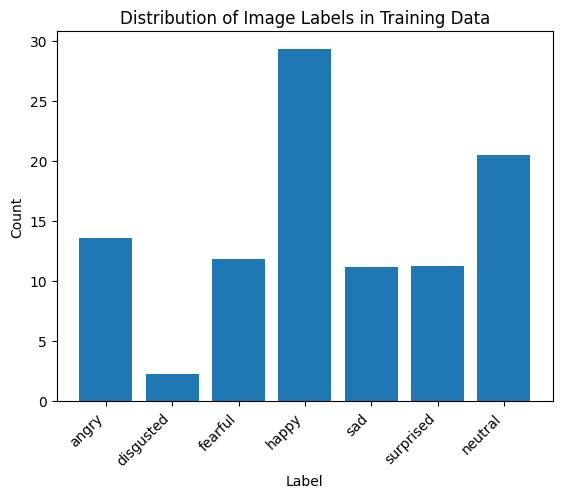

In [ ]:
# get unique labels and number of occurrence
unique, counts = np.unique(labels, return_counts=True)

# calculate percentages
total_samples = len(labels)
percentages = (counts / total_samples) * 100

# map unique labels to their corresponding expression
label_names = [label_classes[label_num] for label_num in unique]

plt.bar(label_names, percentages)
plt.title("Distribution of Image Labels in Training Data")
plt.xlabel("Label")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.show();

The plot shows that there are some expression categories which are unevelenly represented in the training data. 'happy' and 'neutral' are overrepresented while 'disgusted' is underrepresented. To split the data in a representative way, we will use the stratify argument. We will do this for each model depending on the features used.

In [8]:
# create validation set
train_data, val_data, train_labels, val_labels = train_test_split(train, labels,
                                                                  test_size=0.05, random_state=42,
                                                                  stratify=labels) # stratify based on labels proportion
# show dimensions
print(f'The training data dimensions: \t{train_data.shape}\n'
      f'The validation data dimensions: {val_data.shape}\n')

The training data dimensions: 	(8861, 48, 48)
The validation data dimensions: (467, 48, 48)



## Data Combination & Image Flattening
We'll combine train and test data before we extract any features so that all extractions will be done on both parts of the data. We will split the data again before training our ML models so that the first 9328 images are contained in the training data. After that, we'll flatten the images into feature vectors. In order to feed our data into any ML algorithm, we need to flatten the multidimensional structure into a 2D format. Hence for each picture in our sample, the 48x48 2D structure will be flattened out into a vector of 2304 pixels (48*48) which will then serve as features.

In [ ]:
# combine data
full_data = np.vstack((train, test))
print(f'The full data dimensions: {full_data.shape}')

The full data dimensions: (10464, 48, 48)


In [9]:
# reshape training data
n_samples = train_data.shape[0] # length of training data
n_features = train_data.shape[1] * train_data.shape[2] # length of feature vector
train_data_flat = train_data.reshape((n_samples, n_features)) # reshape into 2D array of corresponding dimensions

# reshape validation data
n_samples = val_data.shape[0] # length of training data
n_features = val_data.shape[1] * val_data.shape[2] # length of feature vector
val_data_flat = val_data.reshape((n_samples, n_features)) # reshape into 2D array of corresponding dimensions

# reshape test data
n_samples = test.shape[0] # length of training data
n_features = test.shape[1] * test.shape[2] # length of feature vector
test_data_flat = test.reshape((n_samples, n_features)) # reshape into 2D array of corresponding dimensions

# show dimensions
print(f'The flattened data dimensions are \n'
      f'train: {train_data_flat.shape} \n'
      f'validation: {val_data_flat.shape} \n'
      f'test: {test_data_flat.shape} \n')

The flattened data dimensions are 
train: (8861, 2304) 
validation: (467, 2304) 
test: (1136, 2304) 



## Image Sharpening
To enable easier edge and feature detection in the images, we will apply some image sharpening.

### Unsharp Masking
A sharpening technique that enhances edges and fine details. It is a linear image processing technique which sharpens the image. The sharp details are identified as a difference between the original image and its blurred version. These details are then scaled, and added back to the original image. For blurring, a gaussian filter is used.

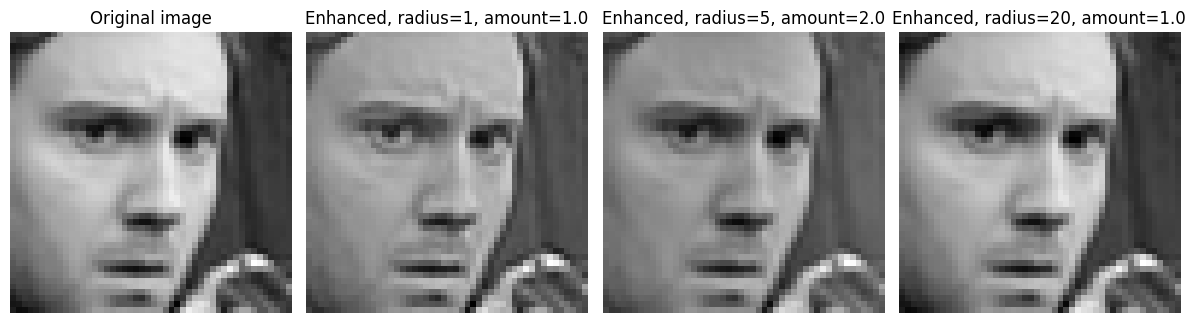

In [ ]:
# try on first training data image
image = train[0]
result_1 = unsharp_mask(image, radius=1, # sigma for gaussian filer
                        amount=1, # amplification of filtering
                        preserve_range=True) # preserve original value range
result_2 = unsharp_mask(image, radius=5, amount=2, preserve_range=True)
result_3 = unsharp_mask(image, radius=20, amount=1, preserve_range=True)

fig, axes = plt.subplots(nrows=1, ncols=4,
                         sharex=True, sharey=True, figsize=(12, 10))
ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original image')
ax[1].imshow(result_1, cmap=plt.cm.gray)
ax[1].set_title('Enhanced, radius=1, amount=1.0')
ax[2].imshow(result_2, cmap=plt.cm.gray)
ax[2].set_title('Enhanced, radius=5, amount=2.0')
ax[3].imshow(result_3, cmap=plt.cm.gray)
ax[3].set_title('Enhanced, radius=20, amount=1.0')

for a in ax:
    a.axis('off')
fig.tight_layout()
plt.show()

While the different parameters do not seem to show large differences in the enhancement, a check on the edge detector revealed that radius=20 and amount=1 seem to allow finer edge detection. Let's apply unsharp masking on our images.

In [ ]:
def unsharp_masking(images: np.array, radius=20, amount=1):
  """
  This function applies enhancement on images in an array of images and returns
  a numpy array of the enhanced images.
  """
  enhanced_images = [] # empty list

  for image in images:
    result = unsharp_mask(image, radius=radius, amount=amount, preserve_range=True)
    enhanced_images.append(result)

  enhanced_images = np.array(enhanced_images) # transform to numpy array

  return enhanced_images

In [ ]:
# apply unsharp masking on training data
enhance_train = unsharp_masking(train_data)

# apply unsharp masking on validation data
enhance_val = unsharp_masking(val_data)

# apply unsharp masking on test data
enhance_test = unsharp_masking(test)

In [ ]:
# show dimensions
print(f'The data dimensions are \n'
      f'train: \t\t{enhance_train.shape} \n'
      f'validation: \t{enhance_val.shape} \n'
      f'test: \t\t{enhance_test.shape} \n')

The data dimensions are 
train: 		(8861, 48, 48) 
validation: 	(467, 48, 48) 
test: 		(1136, 48, 48) 



We have our original data size but the content is enhanced. Lastly, we will flatten this data too so that features can be merged into it later on.

In [ ]:
# reshape training data
n_samples = enhance_train.shape[0] # length of training data
n_features = enhance_train.shape[1] * enhance_train.shape[2] # length of feature vector
train_data_enhance_flat = enhance_train.reshape((n_samples, n_features)) # reshape into 2D array of corresponding dimensions

# reshape validation data
n_samples = enhance_val.shape[0] # length of training data
n_features = enhance_val.shape[1] * enhance_val.shape[2] # length of feature vector
val_data_enhance_flat = enhance_val.reshape((n_samples, n_features)) # reshape into 2D array of corresponding dimensions

# reshape test data
n_samples = enhance_test.shape[0] # length of training data
n_features = enhance_test.shape[1] * enhance_test.shape[2] # length of feature vector
test_data_enhance_flat = enhance_test.reshape((n_samples, n_features)) # reshape into 2D array of corresponding dimensions

# show dimensions
print(f'The flattened data dimensions are \n'
      f'train: {train_data_enhance_flat.shape} \n'
      f'validation: {val_data_enhance_flat.shape} \n'
      f'test: {test_data_enhance_flat.shape} \n')

The flattened data dimensions are 
train: (8861, 2304) 
validation: (467, 2304) 
test: (1136, 2304) 



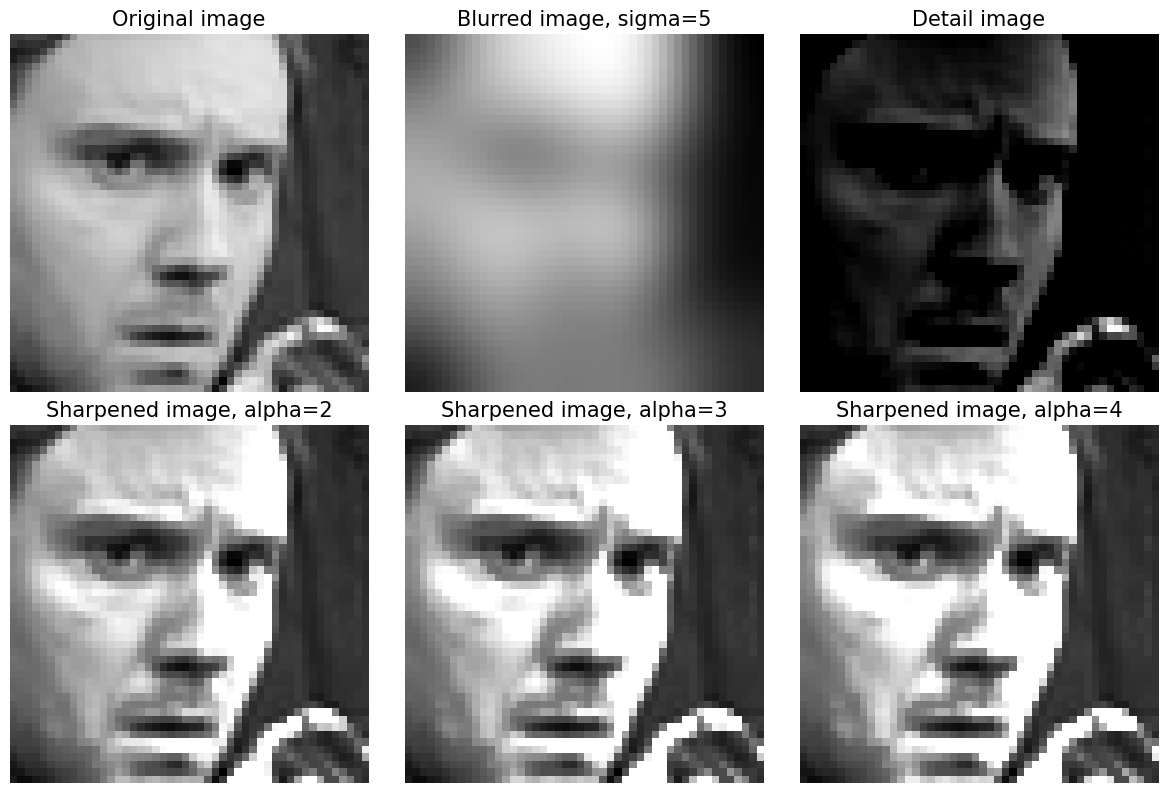

In [ ]:
from scipy.ndimage import gaussian_filter
im_blurred = gaussian_filter(train[0], 5)
im_detail = np.clip(train[0] - im_blurred, 0, 1)
fig, axes = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(12, 8))
axes = axes.ravel()
axes[0].set_title('Original image', size=15), axes[0].imshow(train[0], cmap='gray')
axes[1].set_title('Blurred image, sigma=5', size=15), axes[1].imshow(im_blurred, cmap='gray')
axes[2].set_title('Detail image', size=15), axes[2].imshow(im_detail, cmap='gray')

sharp4 = np.clip(train[0] + 4*im_detail, 0, 1)

alpha = [2, 3, 4]
for i in range(3):
 im_sharp = np.clip(train[0] + alpha[i]*im_detail, 0, 1)
 axes[3+i].imshow(im_sharp, cmap='gray'),  axes[3+i].set_title('Sharpened image, alpha=' + str(alpha[i]), size=15)
for ax in axes:
 ax.axis('off')
fig.tight_layout()
plt.show()

alpha = 2 seems like a good choice.

In [ ]:
def sharpening(images: np.array, kernel=5, alpha=2):

  enhanced_images = [] # empty list

  for image in images:
    blurred = gaussian_filter(image, kernel) # create blurred image using gaussian filter
    detail = np.clip(image - blurred, 0, 1) # subtract blurred image from original to get detailed image
    sharp = np.clip(image + alpha*detail, 0, 1) # add scaled detailed image to original for sharp image
    enhanced_images.append(sharp) # append result

  enhanced_images = np.array(enhanced_images) # transform to numpy array

  return enhanced_images

In [ ]:
# apply sharping on training data
sharp_train = sharpening(train_data)

# apply sharping on validation data
sharp_val = sharpening(val_data)

# apply sharping on test data
sharp_test = sharpening(test)

In [ ]:
# show dimensions
print(f'The data dimensions are \n'
      f'train: \t\t{sharp_train.shape} \n'
      f'validation: \t{sharp_val.shape} \n'
      f'test: \t\t{sharp_test.shape} \n')

The data dimensions are 
train: 		(8861, 48, 48) 
validation: 	(467, 48, 48) 
test: 		(1136, 48, 48) 



We have our original data size but the content is enhanced. Lastly, we will flatten this data too so that features can be merged into it later on.

In [ ]:
# reshape training data
n_samples = sharp_train.shape[0] # length of training data
n_features = sharp_train.shape[1] * sharp_train.shape[2] # length of feature vector
sharp_train_flat = sharp_train.reshape((n_samples, n_features)) # reshape into 2D array of corresponding dimensions

# reshape validation data
n_samples = sharp_val.shape[0] # length of training data
n_features = sharp_val.shape[1] * sharp_val.shape[2] # length of feature vector
sharp_val_flat = sharp_val.reshape((n_samples, n_features)) # reshape into 2D array of corresponding dimensions

# reshape test data
n_samples = sharp_test.shape[0] # length of training data
n_features = sharp_test.shape[1] * sharp_test.shape[2] # length of feature vector
sharp_test_flat = sharp_test.reshape((n_samples, n_features)) # reshape into 2D array of corresponding dimensions

# show dimensions
print(f'The flattened data dimensions are \n'
      f'train: {sharp_train_flat.shape} \n'
      f'validation: {sharp_val_flat.shape} \n'
      f'test: {sharp_test_flat.shape} \n')

The flattened data dimensions are 
train: (8861, 2304) 
validation: (467, 2304) 
test: (1136, 2304) 



### High-Pass Filtering (Laplacian Sharpening)
The Laplacian filter enhances edges and is a simple yet effective sharpening method.

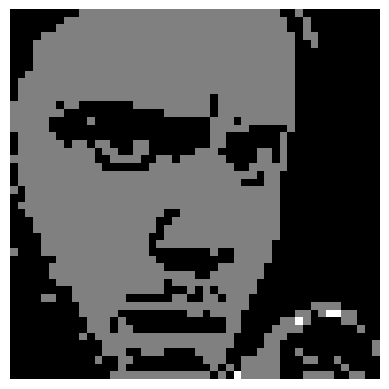

In [ ]:
import cv2

def laplacian_sharpen(image):
    # Apply Laplacian filter for edge enhancement
    laplacian = cv2.Laplacian(image, cv2.CV_64F)

    # Convert back to uint8 and ensure pixel values are in the valid range [0, 255]
    sharpened_image = cv2.convertScaleAbs(image - laplacian)

    return sharpened_image

image = train[0]

# Apply Laplacian sharpening
sharpened_image = laplacian_sharpen(image)

plt.imshow(sharpened_image, cmap='gray')
plt.axis('off')  # Turn off axis labels
plt.show()


## Data Augmentation
Considering the sample size of our training data, augmenting the images by rotating, scaling, and other approaches seems like a useful approach to increase our training data and provide more input for any ML algorithm to learn from. In addition to this, the high-dimensionality of image data will also lead to a need of as much training data as possible. We will use the ImageDataGenerator from Keras for this.

Let's first look at some images to get a feeling which augmentations seem reasonable.

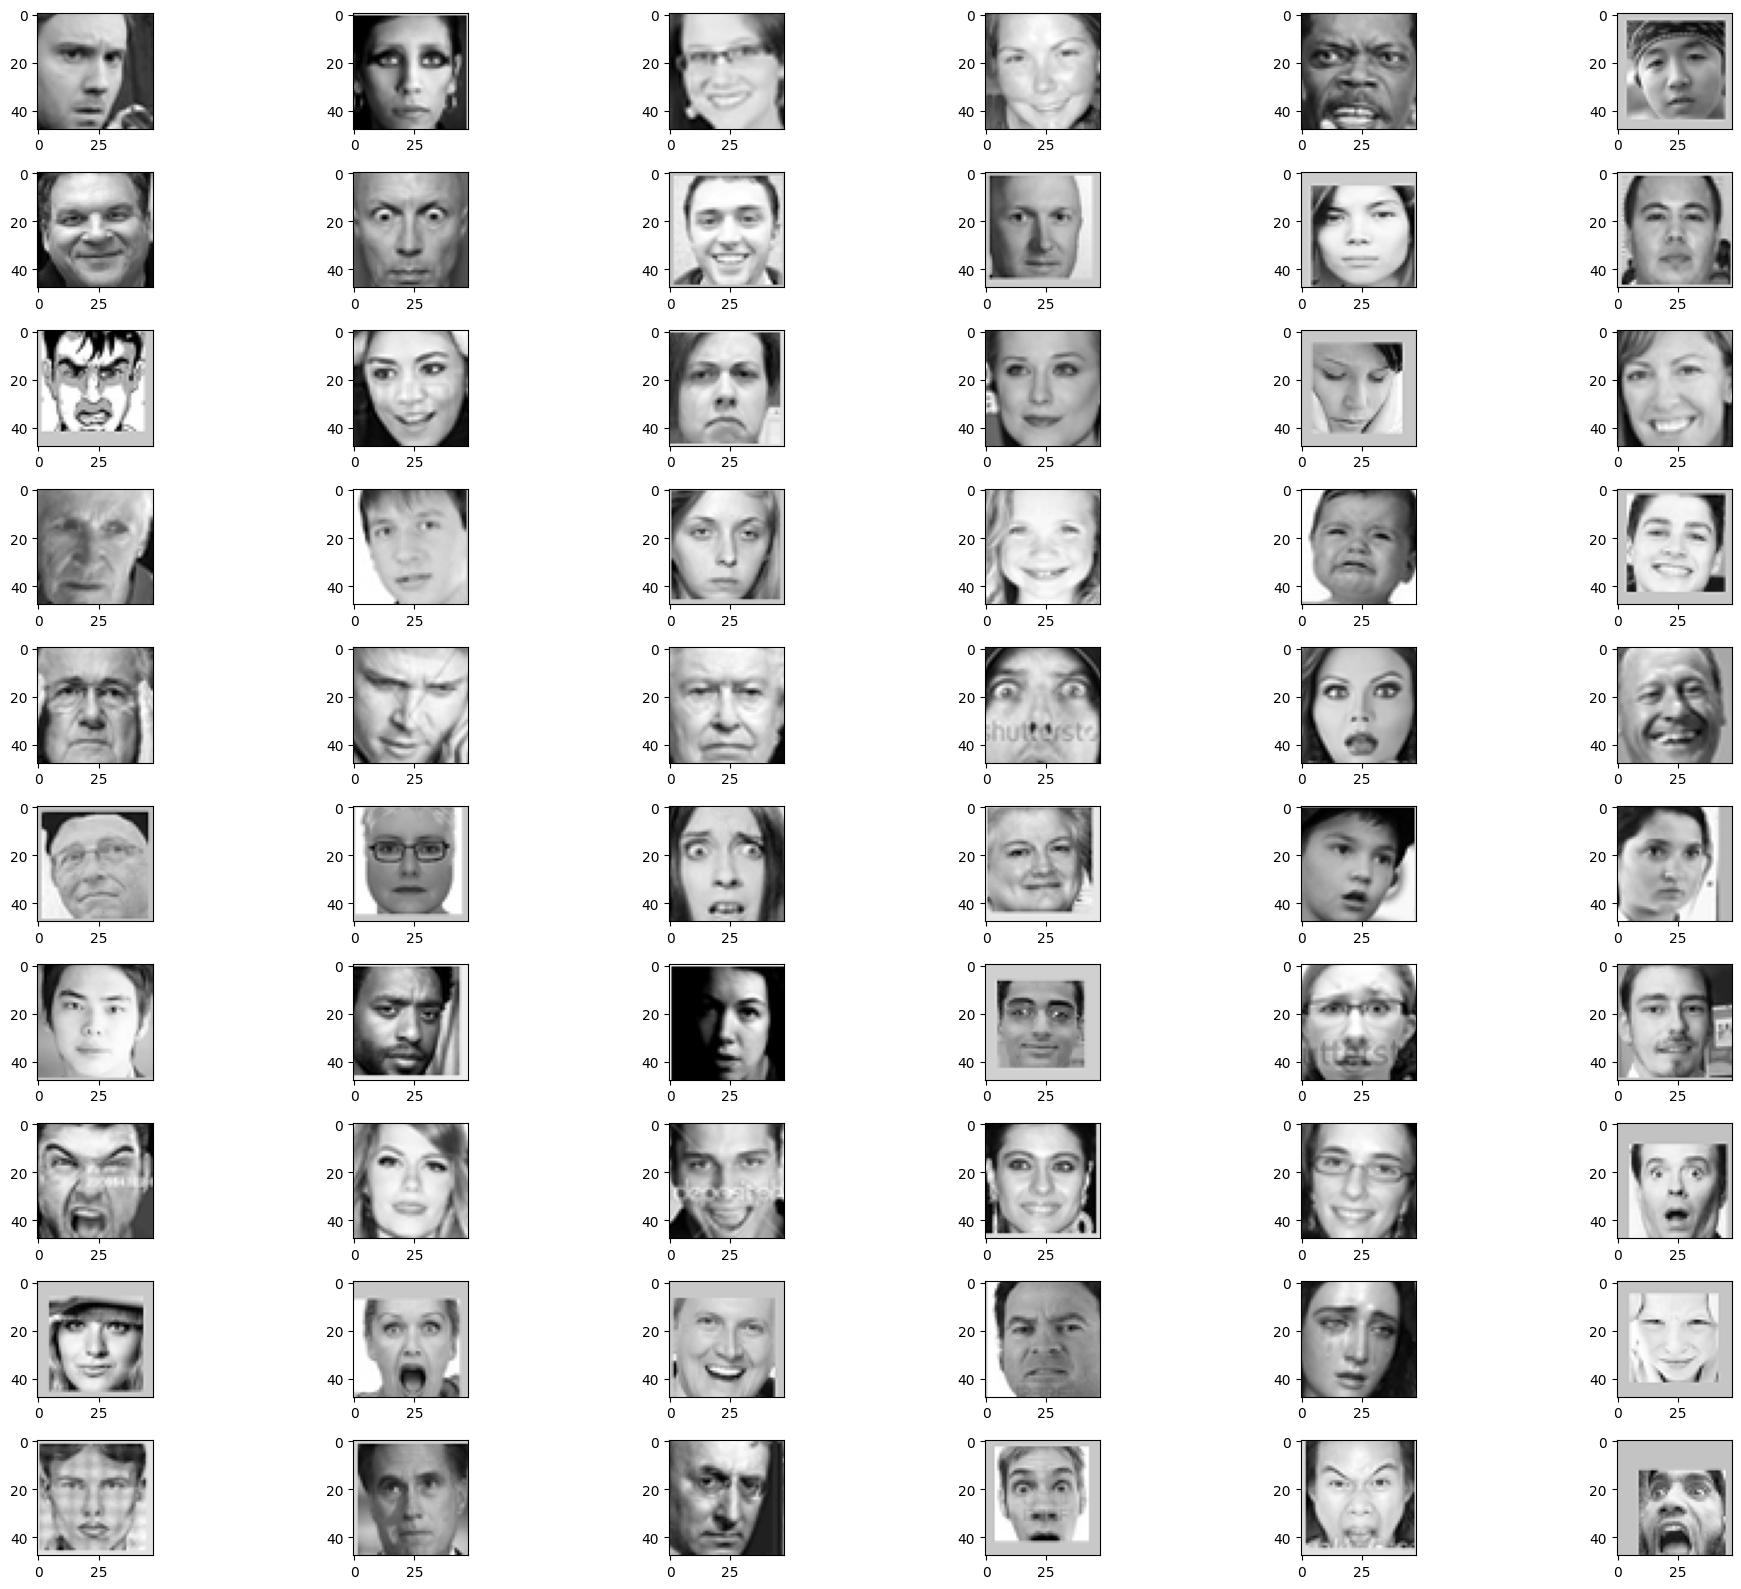

In [ ]:
fig, ax = plt.subplots(nrows=10, ncols=6, figsize=(20, 16))
for i in range(len(train[0:60])):
    lookup_key = labels[i]
    subplot = ax[i // 6, i % 6] # get current subplot
    subplot.imshow(train[i], cmap='gray') # plot image on the current subplot

plt.tight_layout() # no overlap
plt.show()

While most images are centered well, there are images which have larger boundaries of empty gray pixels. For these, augmenting with a slight shift might help to make the model invariant to these boundaries.  
It seems that two other relevant characteristics are that some images show people not looking straight, but rather from the left/right or a bit tilted. For such images, reasonable augmentations seem to be slight rotation and horizontal flips.

We'll first try augmentation on the first image in our training data.

In [ ]:
# define augmentation parameters
augmentation_params = {
    'rotation_range':20, # up to 20 degrees
    'width_shift_range':0.1, # up to 10% of the width
    'height_shift_range':0.1, # up to 10% of the height
    'brightness_range':[0.7, 1.2], # adjust brightness randomly
    'horizontal_flip':True
}

# create an empty list to store augmented images and labels
augmented_images = []
augmented_labels = []

# create ImageDataGenerator for each augmentation parameter sequentially
for param_name, param_value in augmentation_params.items():
    datagen = ImageDataGenerator(fill_mode='nearest', # how to fill in newly created pixels
                                 **{param_name: param_value}) # unpack parameter as function input
    image = train[0]
    label = labels[0]

    # reshape image to have a batch dimension (1, 48, 48, 1)
    image = image.reshape(1, image.shape[0], image.shape[1], 1)

    # 3 augmentations per parameter and image
    for batch in datagen.flow(image, batch_size=1, seed=42):
        augmented_images.append(batch[0].reshape(image.shape[1], image.shape[2]))
        augmented_labels.append(label)

        if len(augmented_images) % 3 == 0:
            break

# convert the list of augmented data to array
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

In [ ]:
augmented_images.shape

(15, 48, 48)

In [ ]:
augmented_labels.shape

(15,)

In [ ]:
labels[0]

0

In [ ]:
augmented_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

As expected, 5 parameters applied in 3 different variations on a single picture result in 15 augmented images. Now let's show those augmented images.

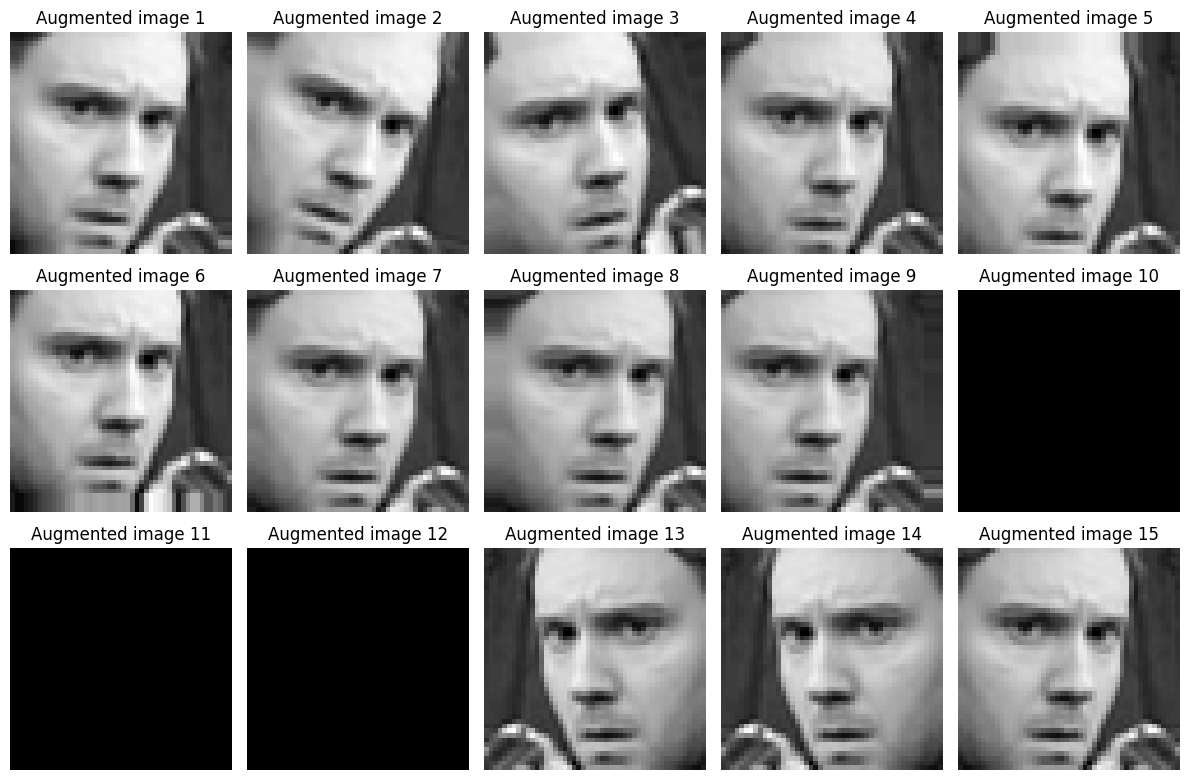

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=5, sharex=True, sharey=True, figsize=(12, 8))
axes = axes.ravel()

for i, image in enumerate(augmented_images[:15]):
  axes[i].imshow(image, cmap='gray'), axes[i].set_title(f'Augmented image {i+1}')
for ax in axes:
 ax.axis('off')
fig.tight_layout()
plt.show()

Let's now extend the above to test on the validation set. We will omit the brightness parameter since it only resulted in black images.

In [ ]:
# define augmentation parameters
augmentation_params = {
    'rotation_range':20, # up to 20 degrees
    'width_shift_range':0.1, # up to 10% of the width
    'height_shift_range':0.1, # up to 10% of the height
    'horizontal_flip':True
}

# create an empty list to store augmented images and labels
augmented_images = []
augmented_labels = []

# create ImageDataGenerator for each augmentation parameter sequentially
for param_name, param_value in augmentation_params.items():
    datagen = ImageDataGenerator(fill_mode='nearest', # how to fill in newly created pixels
                                 **{param_name: param_value}) # unpack parameter as function input
    augmented_images_batch = [] # batch per parameter
    augmented_labels_batch = [] # batch per parameter

    # loop through images and apply augmentations sequentially
    for image, label in zip(val_data, val_labels):

        # reshape image to have a batch dimension (1, 48, 48, 1)
        image = image.reshape(1, image.shape[0], image.shape[1], 1)

        # 3 augmentations per image
        for batch in datagen.flow(image, batch_size=1, seed=42):
            # reshape images back to original 2D
            augmented_images_batch.append(batch[0].reshape(image.shape[1], image.shape[2]))
            augmented_labels_batch.append(label) # also append corresponding label

            # if batch reaches 3 augmentations, stop creating augmentations
            if len(augmented_images_batch) % 3 == 0:
                break

    # extend overall image/label list --> needed to preserve desired 3D structure
    augmented_images.extend(augmented_images_batch)
    augmented_labels.extend(augmented_labels_batch)

# convert list of augmented data to np array
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

We expect 5604 new validation images (467 * 4 * 3).

In [ ]:
val_data.shape

(467, 48, 48)

In [ ]:
augmented_images.shape

(5604, 48, 48)

Now we know the augmentations work as expected. Let's combine the above into a function and augment all images.  
Note: the above approach resulted in a dataset that was too large. Hence we will only create one augmentation per image.

In [ ]:
def augment_images(augmentation_params: dict, image_data: np.array, labels=None):
    """
    This function augments images using specified augmentation parameters.

    parameters:
        augmentation_params (dict): augmentation parameters.
        image_data (array): input images.
        labels (array, optional): corresponding labels. default is none.

    returns:
        tuple: augmented images and labels (if provided).
    """
    # create an empty list to store augmented images and labels
    augmented_images = []
    augmented_labels = []

    # create ImageDataGenerator for each augmentation parameter sequentially
    for param_name, param_value in augmentation_params.items():
        datagen = ImageDataGenerator(fill_mode='nearest', **{param_name: param_value})
        augmented_images_batch = [] # will be list of arrays
        augmented_labels_batch = []

        if type(labels) is np.ndarray:
          # loop through images and apply augmentations sequentially
          for image, label in zip(image_data, labels):

              # reshape image to have a batch dimension (1, height, width, channels)
              image = image.reshape(1, image.shape[0], image.shape[1], 1)

              # apply one augmentation per image
              augmented_batch = datagen.flow(image, batch_size=1, seed=42)
              augmented_image = next(augmented_batch)[0]

              # reshape augmented image back to original 2D
              augmented_image = augmented_image.reshape(image.shape[1], image.shape[2])

              augmented_images_batch.append(augmented_image)
              augmented_labels_batch.append(label)

          # extend overall image/label lists
          augmented_images.extend(augmented_images_batch)
          augmented_labels.extend(augmented_labels_batch)

        else:
          for image in image_data:
              # reshape image to have a batch dimension (1, height, width, channels)
              image = image.reshape(1, image.shape[0], image.shape[1], 1)

              # apply one augmentation per image
              augmented_batch = datagen.flow(image, batch_size=1, seed=42)
              augmented_image = next(augmented_batch)[0]

              # reshape augmented image back to original 2D
              augmented_image = augmented_image.reshape(image.shape[1], image.shape[2])

              augmented_images_batch.append(augmented_image)

          # extend overall image/label lists
          augmented_images.extend(augmented_images_batch)

    # convert list of augmented data to NumPy arrays
    augmented_images = np.array(augmented_images)
    augmented_labels = np.array(augmented_labels)

    if type(labels) is np.ndarray:
      return augmented_images, augmented_labels
    else:
      return augmented_images

In [ ]:
# define augmentation parameters
params = {
    'rotation_range':20, # up to 20 degrees
    'width_shift_range':0.1, # up to 10% of the width
    'height_shift_range':0.1, # up to 10% of the height
    'horizontal_flip':True
}

In [ ]:
# apply augmentation on all three datasets
aug_train, aug_train_labels = augment_images(augmentation_params=params, image_data=train_data, labels=train_labels)
aug_val, aug_val_labels = augment_images(augmentation_params=params, image_data=val_data, labels=val_labels)
aug_test = augment_images(augmentation_params=params, image_data=test, labels=None)

Let's perform some final checks whether the function performs as expected and, most importantly, also matches the correct labels to the images. Hence, for the validation set, we expect to have image and label dimensions of 1868x48x48 and 1868x1 respectively. Also since we loop through the parameter dict and then through the images, we expect that there should be another image after every augmentation.

In [ ]:
val_data.shape

(467, 48, 48)

In [ ]:
print(aug_val.shape, aug_val_labels.shape)

(1868, 48, 48) (1868,)


Dimensions are correct.

In [ ]:
print(val_labels[:5], aug_val_labels[:5])

[5 5 3 3 5] [5 5 3 3 5]


We can see the same original validation labels in the expected order and sequence with the augmented validation labels.

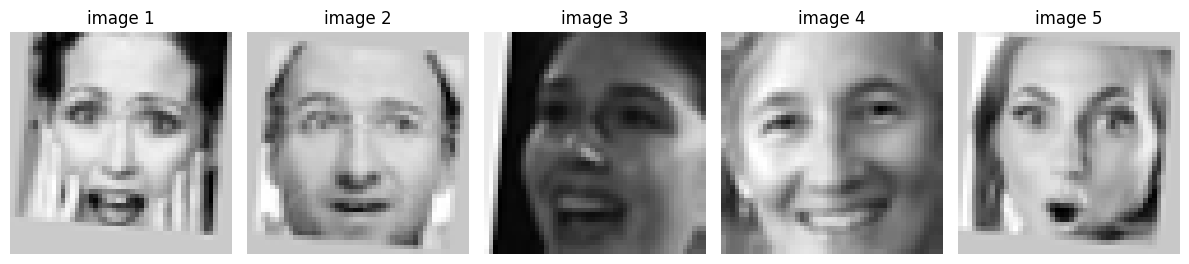

In [ ]:
# visualise the first 5 images --> should be 5 different images
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(12, 8))
axes = axes.ravel()

for i, image in enumerate(aug_val[:5]):
  axes[i].imshow(image, cmap='gray'), axes[i].set_title(f'image {i+1}')
for ax in axes:
 ax.axis('off')
fig.tight_layout()
plt.show()

The first parameter is rotation and can be seen applied on each image which is what we expected. Thus we can confirm that image augmentation has been executed in a desired way. Let's summarise data augmentation by noting the amount of augmented pictures we created.

In [ ]:
# show dimensions
print(f'The augmented data dimensions are \n'
      f'train: {aug_train.shape} \n'
      f'validation: {aug_val.shape} \n'
      f'test: {aug_test.shape} \n')

The augmented data dimensions are 
train: (35444, 48, 48) 
validation: (1868, 48, 48) 
test: (4544, 48, 48) 



As seen above, we created 35444 and 1868 new training and validation images, respectively. We do not consider the augmented test images since we have a predetermined test data set to predict on. Thus, we only merge our new training and validation images with the originals.

In [ ]:
# reshape augmented training data
n_samples = aug_train.shape[0] # length of training data
n_features = aug_train.shape[1] * aug_train.shape[2] # length of feature vector
aug_train_data_flat = aug_train.reshape((n_samples, n_features)) # reshape into 2D array of corresponding dimensions

# reshape augmented validation data
n_samples = aug_val.shape[0] # length of data
n_features = aug_val.shape[1] * aug_val.shape[2] # length of feature vector
aug_val_data_flat = aug_val.reshape((n_samples, n_features)) # reshape into 2D array of corresponding dimensions

# show dimensions
print(f'The flattened augmented data dimensions are \n'
      f'train: {aug_train_data_flat.shape} \n'
      f'validation: {aug_val_data_flat.shape} \n')

The flattened augmented data dimensions are 
train: (35444, 2304) 
validation: (1868, 2304) 



In [ ]:
# merge into respective dataset
train_data = train_data.copy()
val_data = val_data.copy()

full_train_data = np.vstack((train_data, aug_train))
full_val_data = np.vstack((val_data, aug_val))

# show dimensions
print(f'The full flattened data dimensions are \n'
      f'train: {full_train_data.shape} \n'
      f'validation: {full_val_data.shape} \n')

The full flattened data dimensions are 
train: (44305, 48, 48) 
validation: (2335, 48, 48) 



In [ ]:
# merge into respecive flattened dataset
train_data_flat = train_data_flat.copy()
val_data_flat = val_data_flat.copy()

full_train_data_flat = np.vstack((train_data_flat, aug_train_data_flat))
full_val_data_flat = np.vstack((val_data_flat, aug_val_data_flat))

# show dimensions
print(f'The full flattened data dimensions are \n'
      f'train: {full_train_data_flat.shape} \n'
      f'validation: {full_val_data_flat.shape} \n')

The full flattened data dimensions are 
train: (44305, 2304) 
validation: (2335, 2304) 



In [ ]:
# merge labels
train_labels = train_labels.copy()
val_labels = val_labels.copy()

full_train_labels = np.hstack((train_labels, aug_train_labels))
full_val_labels = np.hstack((val_labels, aug_val_labels))

# show dimensions
print(f'The full label dimensions are \n'
      f'train: {full_train_labels.shape} \n'
      f'validation: {full_val_labels.shape} \n')

The full label dimensions are 
train: (44305,) 
validation: (2335,) 



To avoid these memory intensive computations in the future, we will save these to files.

In [ ]:
# save image data
np.save('Data/full_train_data.npy', full_train_data)
np.save('Data/full_val_data.npy', full_val_data)

# save flattened image data
np.save('Data/full_train_data_flat.npy', full_train_data_flat)
np.save('Data/full_val_data_flat.npy', full_val_data_flat)

# save label data
np.save('Data/full_train_labels.npy', full_train_labels)
np.save('Data/full_val_labels.npy', full_val_labels)

## Feature Descriptors
e.g. HOG features, HOF features or MBH features
We will create those features based on the original train data and merge them into the flattened array.


### Histogram of Oriented Gradients (HOG)
This feature descriptor is effective for capturing the shape and texture information of objects in images. Hence this is expected to provide useful information for the detection of an emotional state.




In [ ]:
# load raw image data
full_train_data = np.load('Data/full_train_data.npy')
full_val_data = np.load('Data/full_val_data.npy')

# load flattened image data
full_train_data_flat = np.load('Data/full_train_data_flat.npy')
full_val_data_flat = np.load('Data/full_val_data_flat.npy')

# load label data
full_train_labels = np.load('Data/full_train_labels.npy')
full_val_labels = np.load('Data/full_val_labels.npy')

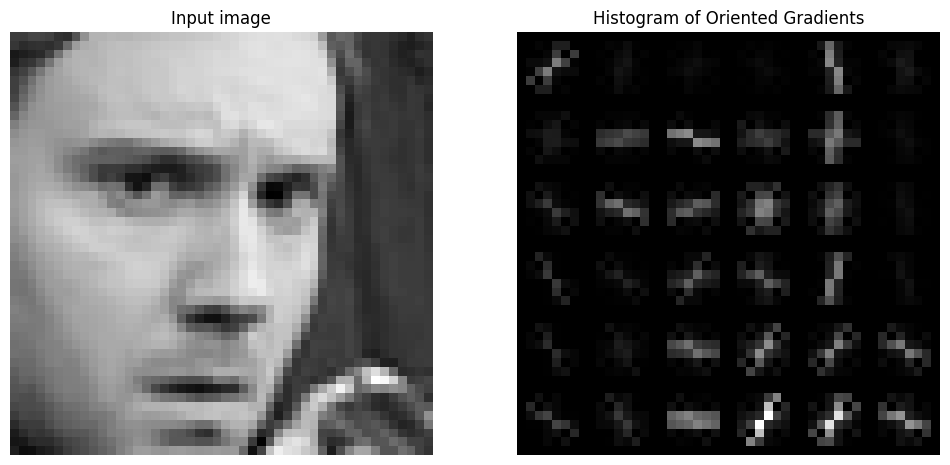

In [ ]:
# show on first original picture
feats, hog1 = hog(full_data[0], orientations= 8, pixels_per_cell=(8, 8), cells_per_block=(1, 1), visualize=True)
fig, (axes1, axes2) = plt.subplots(1, 2, figsize=(12, 8), sharex=True, sharey=True)
axes1.axis('off'), axes1.imshow(train[0], cmap='gray'), axes1.set_title('Input image')
axes2.axis('off'), axes2.imshow(hog1, cmap='gray'), axes2.set_title('Histogram of Oriented Gradients')
plt.show()

In [ ]:
feats.shape

(288,)

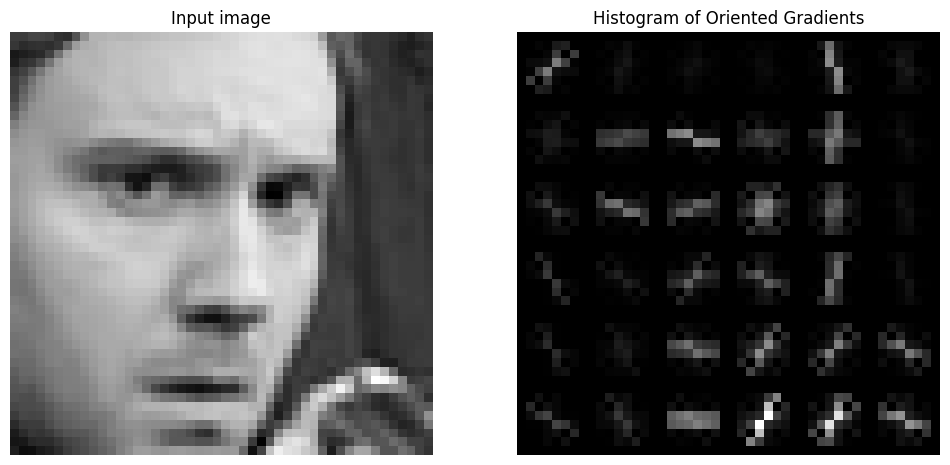

In [ ]:
# show on first enhanced picture
feats, hog1 = hog(result_3, orientations= 8, pixels_per_cell=(8, 8), cells_per_block=(1, 1), visualize=True)
fig, (axes1, axes2) = plt.subplots(1, 2, figsize=(12, 8), sharex=True, sharey=True)
axes1.axis('off'), axes1.imshow(train[0], cmap='gray'), axes1.set_title('Input image')
axes2.axis('off'), axes2.imshow(hog1, cmap='gray'), axes2.set_title('Histogram of Oriented Gradients')
plt.show()

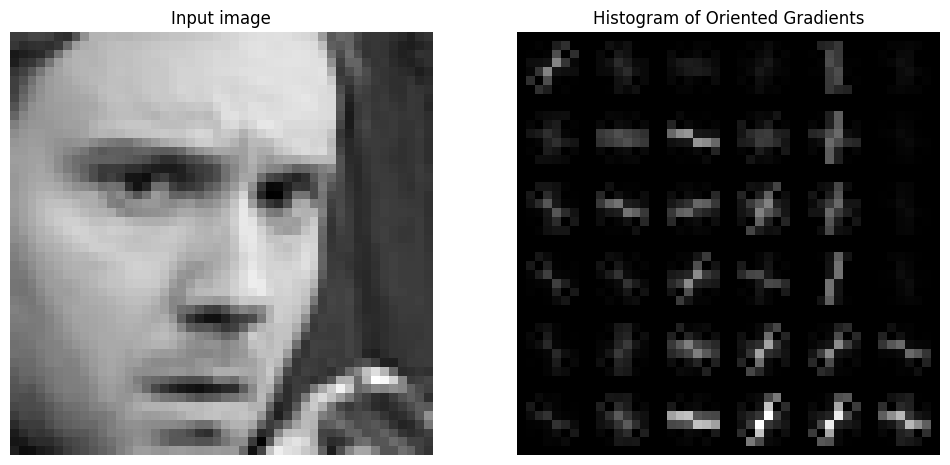

In [ ]:
# show on first enhanced picture
feats, hog1 = hog(sharp4, orientations= 8, pixels_per_cell=(8, 8), cells_per_block=(1, 1), visualize=True)
fig, (axes1, axes2) = plt.subplots(1, 2, figsize=(12, 8), sharex=True, sharey=True)
axes1.axis('off'), axes1.imshow(train[0], cmap='gray'), axes1.set_title('Input image')
axes2.axis('off'), axes2.imshow(hog1, cmap='gray'), axes2.set_title('Histogram of Oriented Gradients')
plt.show()

Creating HOG descriptors with the above arguments would create 288 additional features for each picture. We'll create a function to extract the HOG descriptors, apply it to each picture and merge the output features with the flattened data.

In [ ]:
def hog_image(image: np.array):
    """Apply Histogram of Oriented Gradients (HOG) and return the image as a flattened vector."""
    features = hog(image, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(1, 1), visualize=False)
    return features

In [ ]:
# extract HOG features for each image in training data
hog_features = [hog_image(image) for image in train_data]
hog_features_array = np.array(hog_features) # convert to array
train_hog = np.hstack((train_data_flat, hog_features_array)) # merge into other data

# extract HOG features for each image in validation data
hog_features = [hog_image(image) for image in val_data]
hog_features_array = np.array(hog_features) # convert to array
val_hog = np.hstack((val_data_flat, hog_features_array)) # merge into other data

# extract HOG features for each image in test data
hog_features = [hog_image(image) for image in test]
hog_features_array = np.array(hog_features) # convert to array
test_hog = np.hstack((test_data_flat, hog_features_array)) # merge into other data

In [ ]:
# show dimensions
print(f'The data dimensions incl. HOG features are \n'
      f'train: \t\t{train_hog.shape} \n'
      f'validation: \t{val_hog.shape} \n'
      f'test: \t\t{test_hog.shape} \n')

The data dimensions incl. HOG features are 
train: 		(8861, 2592) 
validation: 	(467, 2592) 
test: 		(1136, 2592) 



In [ ]:
# save files
np.save('Data/train_hog.npy', train_hog)
np.save('Data/val_hog.npy', val_hog)
np.save('Data/test_hog.npy', test_hog)

We can see above that the 288 HOG features have been added to the raw data. Let's also apply the above to the augmented training data.

In [ ]:
# extract HOG features for each image in training data
hog_features = [hog_image(image) for image in full_train_data]
hog_features_array = np.array(hog_features) # convert to array
full_train_hog = np.hstack((full_train_data_flat, hog_features_array)) # merge into other data

# extract HOG features for each image in validation data
hog_features = [hog_image(image) for image in full_val_data]
hog_features_array = np.array(hog_features) # convert to array
full_val_hog = np.hstack((full_val_data_flat, hog_features_array)) # merge into other data

In [ ]:
# show dimensions
print(f'The data dimensions incl. HOG features are \n'
      f'train: \t\t{full_train_hog.shape} \n'
      f'val: \t\t{full_val_hog.shape}')

The data dimensions incl. HOG features are 
train: 		(44305, 2592) 
val: 		(2335, 2592)


In [ ]:
# save files
np.save('Data/full_train_hog.npy', full_train_hog)
np.save('Data/full_val_hog.npy', full_val_hog)

### Harris Corner Detector
This descriptor identifies points in an image where the intensity or color changes significantly in multiple directions, indicating the presence of corners, junctions, or key features/objects. Different emotions might manifest as distinct patterns of facial features in different regions of the face which should then be detected in similar regions across images for the same emotions.





In [ ]:
# load augmented raw image data
full_train_data = np.load('Data/full_train_data.npy')
full_val_data = np.load('Data/full_val_data.npy')

# load augmented flattened image data
full_train_hog = np.load('Data/full_train_hog.npy')
full_val_hog = np.load('Data/full_val_hog.npy')

# load label data
full_train_labels = np.load('Data/full_train_labels.npy')
full_val_labels = np.load('Data/full_val_labels.npy')

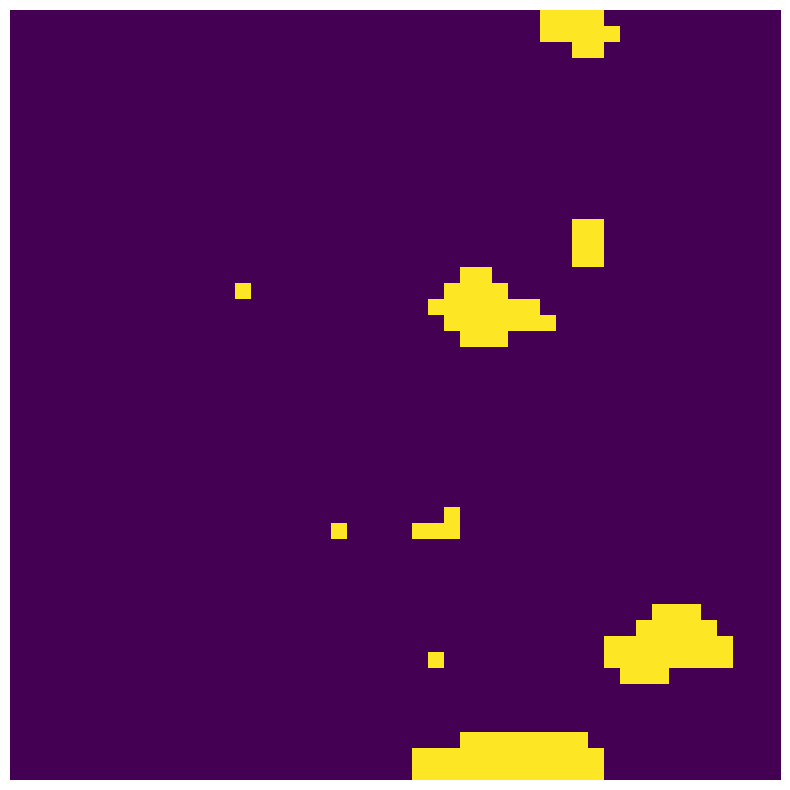

In [ ]:
# show corners for first picture
coordinates = corner_harris(full_data[0], k=0.001) # compute harris corner
corner_mask = coordinates > 0.1 * coordinates.max() # set condition mask for corner candidates
marked_image = np.copy(full_data[0]) # copy image before color set
marked_image[corner_mask] = 255

# display the marked image
plt.figure(figsize=(20, 10))
plt.imshow(marked_image)
plt.axis('off')
plt.show()

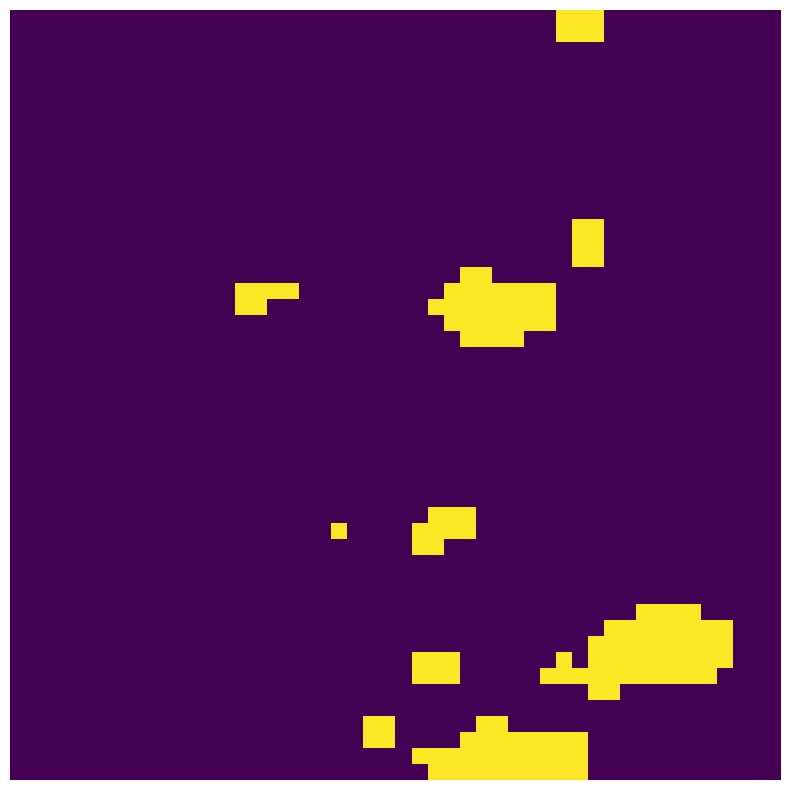

In [ ]:
# show corners for first enhanced picture
coordinates = corner_harris(result_1, k=0.001) # compute harris corner
corner_mask = coordinates > 0.1 * coordinates.max() # set condition mask for corner candidates
marked_image = np.copy(full_data[0]) # copy image before color set
marked_image[corner_mask] = 255

# display the marked image
plt.figure(figsize=(20, 10))
plt.imshow(marked_image)
plt.axis('off')
plt.show()

In [ ]:
# show how many corners there are in the picture given a minimum distance constraint
corner_coordinates = corner_peaks(coordinates, min_distance=2)
corner_coordinates.shape

(15, 2)

We will now apply the Harris Corner Detector on all images in our training data. However, each picture will likely return a different number of corners which would be difficult to incorporate into the training data. Hence we will partition each image into a grid and count the number of corners in each region of the grid for each image which will give us a fixed sized number of features with counts for each image. This can then be used as ML input as the difference of corner occurrences in each image region will be measurable across images.

In [ ]:
def harris_corners(image: np.array, num_regions_x: int, num_regions_y: int):
    """
    Apply Harris Corner Detector and return the corners as well as region-based corner counts.
    """
    coordinates = corner_harris(image, k=0.001) # harris corners
    corners = corner_peaks(coordinates, min_distance=1)
    region_counts = np.zeros((num_regions_x, num_regions_y), dtype=int) # empty array to populate

    # calculate region size
    region_height = image.shape[0] // num_regions_x
    region_width = image.shape[1] // num_regions_y

    # count corners in each region
    for corner in corners:
        region_x = min(corner[0] // region_height, num_regions_x - 1)
        region_y = min(corner[1] // region_width, num_regions_y - 1)
        region_counts[region_x, region_y] += 1 # increase count in respective region

    return region_counts

In [ ]:
# apply harris corner extraction on training data
region_train = [harris_corners(image, num_regions_x=4, num_regions_y=4) for image in train_data]
region_train_flat = [array.flatten() for array in region_train] # flatten arrays into vectors
region_train_flat_np = np.array(region_train_flat) # convert to numpy

# apply harris corner extraction on validation data
region_val = [harris_corners(image, num_regions_x=4, num_regions_y=4) for image in val_data]
region_val_flat = [array.flatten() for array in region_val] # flatten arrays into vectors
region_val_flat_np = np.array(region_val_flat) # convert to numpy

# apply harris corner extraction on test data
region_test = [harris_corners(image, num_regions_x=4, num_regions_y=4) for image in test]
region_test_flat = [array.flatten() for array in region_test] # flatten arrays into vectors
region_test_flat_np = np.array(region_test_flat) # convert to numpy

In [ ]:
# apply scaling on individual datasets
scaler = MinMaxScaler()
norm_regions_train = scaler.fit_transform(region_train_flat_np) # fit scaling parameters on training data
norm_regions_val = scaler.transform(region_val_flat_np) # transform validation data
norm_regions_test = scaler.transform(region_test_flat_np) # transform test data

# merge corner features with other data respectively
train_hog_corner = np.hstack((train_hog, norm_regions_train))
val_hog_corner = np.hstack((val_hog, norm_regions_val))
test_hog_corner = np.hstack((test_hog, norm_regions_test))

In [ ]:
# show dimensions
print(f'The data dimensions incl. HOG & corner features are \n'
      f'train: \t\t{train_hog_corner.shape} \n'
      f'validation:\t {val_hog_corner.shape} \n'
      f'test: \t\t{test_hog_corner.shape} \n')

The data dimensions incl. HOG & corner features are 
train: 		(8861, 2608) 
validation:	 (467, 2608) 
test: 		(1136, 2608) 



In [ ]:
# save files
np.save('Data/train_hog_corner.npy', train_hog_corner)
np.save('Data/val_hog_corner.npy', val_hog_corner)
np.save('Data/test_hog_corner.npy', test_hog_corner)

The Harris Corner features have been added. Basically, there are now 16 additional features for each image which show a distribution of corner counts for the same subregions of all images. Since these corners are relevant points in an image, they are expected to help a ML classifier identifying similar emotions across different images.

In [ ]:
# sharp_train_flat.shape} \n'
#       f'validation: {sharp_val_flat.shape} \n'
#       f'test: {sharp_test_flat

In [ ]:
# # also merge with sharp images
# train_sharp_hog_corner = np.hstack((train_hog_corner, edge_train_sharp))
# val_sharp_hog_corner = np.hstack((val_hog_corner, edge_val_sharp))
# test_sharp_hog_corner = np.hstack((test_hog_corner, edge_test_sharp))

# # substitute originals with sharp images
# train_sharp_hog_corner_canny[:, :2304] = sharp_train_flat # training data
# val_sharp_hog_corner_canny[:, :2304] = sharp_val_flat # validation data
# test_sharp_hog_corner_canny[:, :2304] = sharp_test_flat # test data

# # show dimensions
# print(f'The data dimensions incl. HOG, corners & edges are \n'
#       f'train: \t\t{train_sharp_hog_corner_canny.shape} \n'
#       f'validation: \t{val_sharp_hog_corner_canny.shape} \n'
#       f'test: \t\t{test_sharp_hog_corner_canny.shape} \n')

We will apply corner extraction on the augmented images too.

In [ ]:
# apply harris corner extraction on training data
region_train = [harris_corners(image, num_regions_x=4, num_regions_y=4) for image in full_train_data]
region_train_flat = [array.flatten() for array in region_train] # flatten arrays into vectors
region_train_flat_np = np.array(region_train_flat) # convert to numpy

# apply harris corner extraction on validation data
region_val = [harris_corners(image, num_regions_x=4, num_regions_y=4) for image in full_val_data]
region_val_flat = [array.flatten() for array in region_val] # flatten arrays into vectors
region_val_flat_np = np.array(region_val_flat) # convert to numpy

In [ ]:
# apply scaling on individual datasets
scaler = MinMaxScaler()
norm_regions_train = scaler.fit_transform(region_train_flat_np) # fit scaling parameters on training data
norm_regions_val = scaler.transform(region_val_flat_np) # transform validation data

# merge corner features with other data respectively
full_train_hog_corner = np.hstack((full_train_hog, norm_regions_train))
full_val_hog_corner = np.hstack((full_val_hog, norm_regions_val))

In [ ]:
# show dimensions
print(f'The data dimensions incl. HOG & corner features are \n'
      f'train: \t\t{full_train_hog_corner.shape} \n'
      f'validation:\t {full_val_hog_corner.shape} \n')

The data dimensions incl. HOG & corner features are 
train: 		(44305, 2608) 
validation:	 (2335, 2608) 



In [ ]:
# save
np.save('Data/full_train_hog_corner.npy', full_train_hog_corner)
np.save('Data/full_val_hog_corner.npy', full_val_hog_corner)

### Local Binary Patterns (LBP)
The goal of LBP is to encode geometric features of an image by detecting edges, corners, raised or flat areas and hard lines. This allows us to generate a feature vector representation of an image through density function representations which can then be used as input for ML models.
In this case, we will use a uniform method to preserve rotation invariance. First, we extract the binary patterns for each image. Second, we calculate the histogram of LBP values for each image. Third, we normalize these values and, fourth, concatenate these into a vector of feature per image which can then be concatenated to the full data.

In [ ]:
# load augmented raw image data
full_train_data = np.load('Data/full_train_data.npy')
full_val_data = np.load('Data/full_val_data.npy')

# load augmented flattened image data
full_train_hog_corner = np.load('Data/full_train_hog_corner.npy')
full_val_hog_corner = np.load('Data/full_val_hog_corner.npy')

# load label data
full_train_labels = np.load('Data/full_train_labels.npy')
full_val_labels = np.load('Data/full_val_labels.npy')

In [ ]:
def lbp_extraction(image_data: np.array, radius: int, neighbors: int, method='uniform'):

  lbp_histograms = [] # empty list to store histograms

  # apply binary pattern extraction and histogram for each image
  n_points = neighbors * radius
  for image in image_data:
    # get pattern
    binary_image_pattern = local_binary_pattern(image, method=method, R=radius, P=n_points)

    # get histogram
    n_bins = int(binary_image_pattern.max() + 1) # number of bins
    hist, _ = np.histogram(binary_image_pattern.ravel(), bins=n_bins, range=(0, n_bins))

    # normalize histogram
    hist = hist.astype('float')
    hist /= (hist.sum() + 1e-6)

    lbp_histograms.append(hist) # append to list

  return lbp_histograms

Now we can apply the above function which does the job for tasks 1 and 2 outlined before. Then we will standardize the outputs on train, validation, and test set separately.

In [ ]:
# extract LBP patterns and histograms on training data
lbp_train = lbp_extraction(train_data, radius=1, neighbors=8)

# extract LBP patterns and histograms on validation data
lbp_val = lbp_extraction(val_data, radius=1, neighbors=8)

# extract LBP patterns and histograms on test data
lbp_test = lbp_extraction(test, radius=1, neighbors=8)

In [ ]:
lbp_train[:5]

[array([0.03732639, 0.07638889, 0.05989583, 0.12022569, 0.30729167,
        0.13541667, 0.05034722, 0.06467014, 0.05512153, 0.09331597]),
 array([0.03472222, 0.07942708, 0.04427083, 0.13671875, 0.30729167,
        0.14583333, 0.05164931, 0.06901042, 0.04644097, 0.08463542]),
 array([0.04123264, 0.08897569, 0.05815972, 0.11458333, 0.30512153,
        0.13888889, 0.0546875 , 0.05902778, 0.04904514, 0.09027778]),
 array([0.01692708, 0.05946181, 0.04557292, 0.14496528, 0.39670139,
        0.15885417, 0.05208333, 0.04166667, 0.03168403, 0.05208333]),
 array([0.03428819, 0.06032986, 0.02821181, 0.08072917, 0.17144097,
        0.11197917, 0.0390625 , 0.04427083, 0.05642361, 0.37326389])]

In [ ]:
# # apply scaling on individual datasets
# scaler = MinMaxScaler()
# norm_lbp_train = scaler.fit_transform(lbp_train) # fit scaling parameters on training data
# norm_lbp_val = scaler.transform(lbp_val) # transform validation data
# norm_lbp_test = scaler.transform(lbp_test) # transform test data

# merge corner features with other data respectively
train_hog_corner_lbp = np.hstack((train_hog_corner, lbp_train))
val_hog_corner_lbp = np.hstack((val_hog_corner, lbp_val))
test_hog_corner_lbp = np.hstack((test_hog_corner, lbp_test))

In [ ]:
# show dimensions
print(f'The data dimensions incl. HOG, corner & LBP features are \n'
      f'train: \t\t{train_hog_corner_lbp.shape} \n'
      f'validation: \t{val_hog_corner_lbp.shape} \n'
      f'test: \t\t{test_hog_corner_lbp.shape} \n')

The data dimensions incl. HOG, corner & LBP features are 
train: 		(8861, 2618) 
validation: 	(467, 2618) 
test: 		(1136, 2618) 



In [ ]:
# save files
np.save('Data/train_hog_corner_lbp.npy', train_hog_corner_lbp)
np.save('Data/val_hog_corner_lbp.npy', val_hog_corner_lbp)
np.save('Data/test_hog_corner_lbp.npy', test_hog_corner_lbp)

Now we'll apply LBP extraction also on the full augmented image data.

In [ ]:
# extract LBP patterns and histograms on training data
lbp_train = lbp_extraction(full_train_data, radius=1, neighbors=8)

# extract LBP patterns and histograms on validation data
lbp_val = lbp_extraction(full_val_data, radius=1, neighbors=8)

In [ ]:
# merge corner features with other data respectively
full_train_hog_corner_lbp = np.hstack((full_train_hog_corner, lbp_train))
full_val_hog_corner_lbp = np.hstack((full_val_hog_corner, lbp_val))

In [ ]:
# show dimensions
print(f'The data dimensions incl. HOG, corner & LBP features are \n'
      f'train: \t\t{full_train_hog_corner_lbp.shape} \n'
      f'validation: \t{full_val_hog_corner_lbp.shape} \n')

The data dimensions incl. HOG, corner & LBP features are 
train: 		(44305, 2618) 
validation: 	(2335, 2618) 



In [ ]:
# save
np.save('Data/full_train_hog_corner_lbp.npy', full_train_hog_corner_lbp)
np.save('Data/full_val_hog_corner_lbp.npy', full_val_hog_corner_lbp)

### Canny Edge Detector
We will use the Canny edge detection algorithm as it produces smoother, thinner, and cleaner images than Sobel and Prewitt filters.
https://learning.oreilly.com/library/view/hands-on-image-processing/9781789343731/9fa365a2-8698-4cfe-bd42-b1a530ac0f3b.xhtml



We will try different parameter specifications including gaussian blurring as a first step on the first image of the training data to get a feeling for reasonable parameter values edge detection. Also we will try it on the original image and on the enhanced image following the unsharp mask enhancement.



In [113]:
# load augmented raw image data
full_train_data = np.load('Data/full_train_data.npy')
full_val_data = np.load('Data/full_val_data.npy')

# load augmented flattened image data
full_train_hog_corner_lbp = np.load('Data/full_train_hog_corner_lbp.npy')
full_val_hog_corner_lbp = np.load('Data/full_val_hog_corner_lbp.npy')

# load label data
full_train_labels = np.load('Data/full_train_labels.npy')
full_val_labels = np.load('Data/full_val_labels.npy')

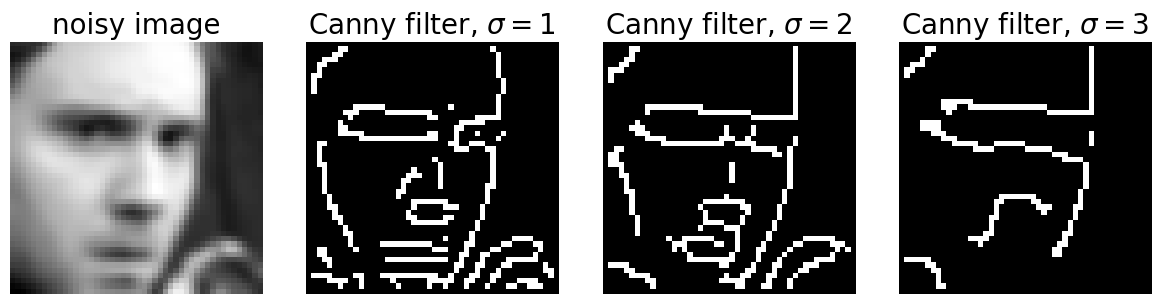

In [114]:
# apply gaussian blur
image = ndi.gaussian_filter(train[0], sigma=1)

# compute canny filter for two values of sigma
edges1 = canny(image, sigma=1)
edges2 = canny(image, sigma=2)
edges3 = canny(image, sigma=3)

# display results
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 3))
ax[0].imshow(image, cmap='gray') # blurred image
ax[0].set_title('noisy image', fontsize=20)
ax[1].imshow(edges1, cmap='gray')
ax[1].set_title(r'Canny filter, $\sigma=1$', fontsize=20)
ax[2].imshow(edges2, cmap='gray')
ax[2].set_title(r'Canny filter, $\sigma=2$', fontsize=20)
ax[3].imshow(edges3, cmap='gray')
ax[3].set_title(r'Canny filter, $\sigma=3$', fontsize=20)

for a in ax:
    a.axis('off')

fig.tight_layout()
plt.show()

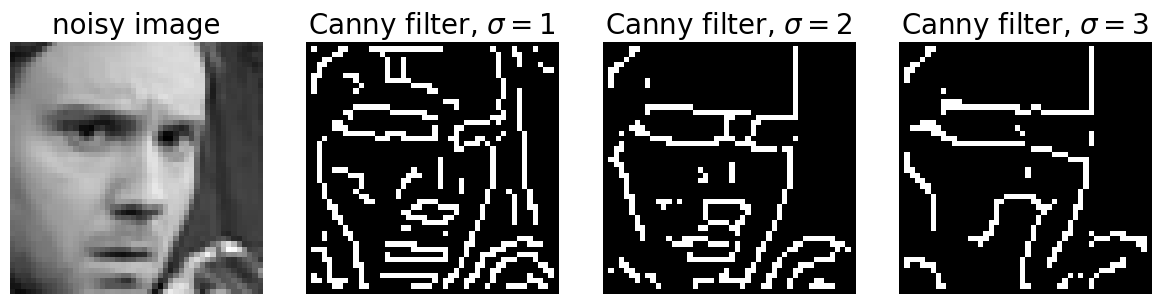

In [115]:
# enhanced image
image = result_3 # result 3 worked best

# compute canny filter for two values of sigma
edges1 = canny(image, sigma=1)
edges2 = canny(image, sigma=2)
edges3 = canny(image, sigma=3)

# display results
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 3))
ax[0].imshow(image, cmap='gray') # blurred image
ax[0].set_title('noisy image', fontsize=20)
ax[1].imshow(edges1, cmap='gray')
ax[1].set_title(r'Canny filter, $\sigma=1$', fontsize=20)
ax[2].imshow(edges2, cmap='gray')
ax[2].set_title(r'Canny filter, $\sigma=2$', fontsize=20)
ax[3].imshow(edges3, cmap='gray')
ax[3].set_title(r'Canny filter, $\sigma=3$', fontsize=20)

for a in ax:
    a.axis('off')

fig.tight_layout()
plt.show()

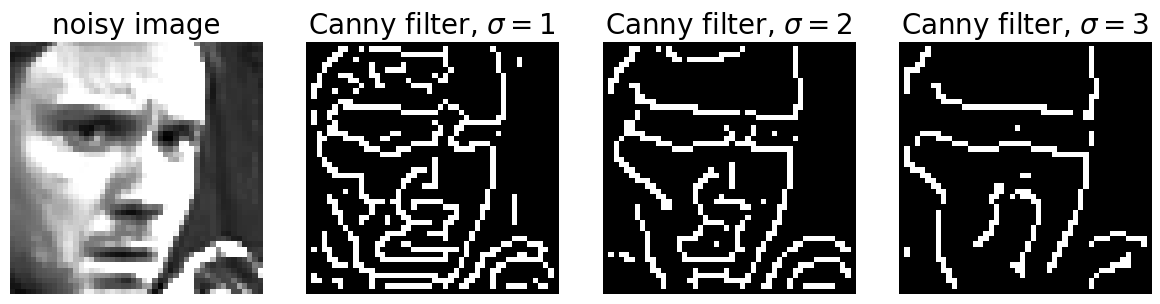

In [116]:
# enhanced image
image = sharp4 # result 3 worked best

# compute canny filter for two values of sigma
edges1 = canny(image, sigma=1)
edges2 = canny(image, sigma=2)
edges3 = canny(image, sigma=3)

# display results
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 3))
ax[0].imshow(image, cmap='gray') # blurred image
ax[0].set_title('noisy image', fontsize=20)
ax[1].imshow(edges1, cmap='gray')
ax[1].set_title(r'Canny filter, $\sigma=1$', fontsize=20)
ax[2].imshow(edges2, cmap='gray')
ax[2].set_title(r'Canny filter, $\sigma=2$', fontsize=20)
ax[3].imshow(edges3, cmap='gray')
ax[3].set_title(r'Canny filter, $\sigma=3$', fontsize=20)

for a in ax:
    a.axis('off')

fig.tight_layout()
plt.show()

Different parameter variations have been tried, including incorporation of random noise in addition to gaussian blur. In the end, both a gaussian blur and the canny filter with σ=1 seemed like the most reasonable parameter choice as the edges showed the main characteristics of the corresponding emotion the most. However, the application on the already enhanced image following the unsharp mask procedure expresses more detail for those parameters compared to the extraction from the original image. For example, it can be seen how the frown on the forehead or the jawline on the left cheek are detected while this is not the case for the original image. Thus, these details are expected to provide value for a ML model. Now we will apply the edge detection on all images.

In [117]:
def edge_detection(images: np.array, sigma_gauss: float, sigma_canny: float):
  """
  This function applies edge detection on images in an array of images and returns
  a binary feature vector of 0 and 1 determining where edges are present or not.
  """
  edges = [] # empty list to append edge vectors to

  for image in images: # get index and image
    blurred = ndi.gaussian_filter(image, sigma=sigma_gauss) # apply gaussian blur
    edged = canny(blurred, sigma=sigma_canny) # apply edge detection
    edged_flat = edged.flatten()
    edged_binary = edged_flat.astype(int) # transform true/false to 1/0
    edges.append(edged_binary) # append edge vector

  edges = np.array(edges) # transform to numpy array

  return edges

#### Original Images
We will first apply edge detection on the original image data.

In [118]:
# apply edge detection on training data
edge_train = edge_detection(train_data, sigma_gauss=1, sigma_canny=1)

# apply edge detection on validation data
edge_val = edge_detection(val_data, sigma_gauss=1, sigma_canny=1)

# apply edge detection on test data
edge_test = edge_detection(test, sigma_gauss=1, sigma_canny=1)

In [119]:
# merge corner features with other data respectively
train_hog_corner_lbp_canny = np.hstack((train_hog_corner_lbp, edge_train))
val_hog_corner_lbp_canny = np.hstack((val_hog_corner_lbp, edge_val))
test_hog_corner_lbp_canny = np.hstack((test_hog_corner_lbp, edge_test))

In [120]:
# show dimensions
print(f'The data dimensions incl. HOG, corner & LBP features are \n'
      f'train: \t\t{train_hog_corner_lbp_canny.shape} \n'
      f'validation: \t{val_hog_corner_lbp_canny.shape} \n'
      f'test: \t\t{test_hog_corner_lbp_canny.shape} \n')

The data dimensions incl. HOG, corner & LBP features are 
train: 		(8861, 4922) 
validation: 	(467, 4922) 
test: 		(1136, 4922) 



In [121]:
# save files
np.save('Data/train_hog_corner_lbp_canny.npy', train_hog_corner_lbp_canny)
np.save('Data/val_hog_corner_lbp_canny.npy', val_hog_corner_lbp_canny)
np.save('Data/test_hog_corner_lbp_canny.npy', test_hog_corner_lbp_canny)

Now we will extract edges on the augmented data.

In [122]:
# apply edge detection on training data
edge_train = edge_detection(full_train_data, sigma_gauss=1, sigma_canny=1)

# apply edge detection on validation data
edge_val = edge_detection(full_val_data, sigma_gauss=1, sigma_canny=1)

In [123]:
# merge corner features with other data respectively
full_train_hog_corner_lbp_canny = np.hstack((full_train_hog_corner_lbp, edge_train))
full_val_hog_corner_lbp_canny = np.hstack((full_val_hog_corner_lbp, edge_val))

In [124]:
# show dimensions
print(f'The data dimensions incl. HOG, corner & LBP features are \n'
      f'train: \t\t{full_train_hog_corner_lbp_canny.shape} \n'
      f'validation: \t{full_val_hog_corner_lbp_canny.shape} \n')

The data dimensions incl. HOG, corner & LBP features are 
train: 		(44305, 4922) 
validation: 	(2335, 4922) 



In [125]:
# save files
np.save('Data/full_train_hog_corner_lbp_canny.npy', full_train_hog_corner_lbp_canny)
np.save('Data/full_val_hog_corner_lbp_canny.npy', full_val_hog_corner_lbp_canny)

#### Enhanced Images
Now we will apply edge detection on the enhanced images.

In [126]:
# apply edge detection on training data
edge_train_enhanced = edge_detection(enhance_train, sigma_gauss=1, sigma_canny=1)

# apply edge detection on validation data
edge_val_enhanced = edge_detection(enhance_val, sigma_gauss=1, sigma_canny=1)

# apply edge detection on test data
edge_test_enhanced = edge_detection(enhance_test, sigma_gauss=1, sigma_canny=1)

In [127]:
# show dimensions
print(f'The edge feature dimensions are \n'
      f'train: \t\t{edge_train_enhanced.shape} \n'
      f'validation: \t{edge_val_enhanced.shape} \n'
      f'test: \t\t{edge_test_enhanced.shape} \n')

The edge feature dimensions are 
train: 		(8861, 2304) 
validation: 	(467, 2304) 
test: 		(1136, 2304) 



Now we want to stack the edge features with the enhanced images, the HOG features, the harris corner features, and the LBP patterns.

In [128]:
# merge edges with other data respectively
train_enhanced_hog_corner_lbp_canny = np.hstack((train_hog_corner_lbp, edge_train_enhanced))
val_enhanced_hog_corner_lbp_canny = np.hstack((val_hog_corner_lbp, edge_val_enhanced))
test_enhanced_hog_corner_lbp_canny = np.hstack((test_hog_corner_lbp, edge_test_enhanced))

Now we will substitue the original images with the enhanced images.

In [129]:
train_enhanced_hog_corner_lbp_canny[:, :2304] = train_data_enhance_flat # training data
val_enhanced_hog_corner_lbp_canny[:, :2304] = val_data_enhance_flat # validation data
test_enhanced_hog_corner_lbp_canny[:, :2304] = test_data_enhance_flat # test data

In [130]:
# show dimensions
print(f'The data dimensions incl. HOG, corner, LBP features & edges are \n'
      f'train: \t\t{train_enhanced_hog_corner_lbp_canny.shape} \n'
      f'validation: \t{val_enhanced_hog_corner_lbp_canny.shape} \n'
      f'test: \t\t{test_enhanced_hog_corner_lbp_canny.shape} \n')

The data dimensions incl. HOG, corner, LBP features & edges are 
train: 		(8861, 4922) 
validation: 	(467, 4922) 
test: 		(1136, 4922) 



#### Sharp Images
Now we will apply edge detection on the sharp images.

In [131]:
# apply edge detection on training data
edge_train_sharp = edge_detection(sharp_train, sigma_gauss=1, sigma_canny=1)

# apply edge detection on validation data
edge_val_sharp = edge_detection(sharp_val, sigma_gauss=1, sigma_canny=1)

# apply edge detection on test data
edge_test_sharp = edge_detection(sharp_test, sigma_gauss=1, sigma_canny=1)

In [132]:
# show dimensions
print(f'The edge feature dimensions are \n'
      f'train: \t\t{edge_train_sharp.shape} \n'
      f'validation: \t{edge_val_sharp.shape} \n'
      f'test: \t\t{edge_test_sharp.shape} \n')

The edge feature dimensions are 
train: 		(8861, 2304) 
validation: 	(467, 2304) 
test: 		(1136, 2304) 



Now we want to stack the edge features with the enhanced images, the HOG features, the harris corner features, and the LBP patterns.

In [133]:
# merge edges with all other features
train_sharp_hog_corner_lbp_canny = np.hstack((train_hog_corner_lbp, edge_train_sharp))
val_sharp_hog_corner_lbp_canny = np.hstack((val_hog_corner_lbp, edge_val_sharp))
test_sharp_hog_corner_lbp_canny = np.hstack((test_hog_corner_lbp, edge_test_sharp))

Now we will substitue the original images with the sharp images.

In [134]:
train_sharp_hog_corner_lbp_canny[:, :2304] = sharp_train_flat # training data
val_sharp_hog_corner_lbp_canny[:, :2304] = sharp_val_flat # validation data
test_sharp_hog_corner_lbp_canny[:, :2304] = sharp_test_flat # test data

In [135]:
# show dimensions
print(f'The data dimensions incl. HOG, corner, LBP features & edges are \n'
      f'train: \t\t{train_sharp_hog_corner_lbp_canny.shape} \n'
      f'validation: \t{val_sharp_hog_corner_lbp_canny.shape} \n'
      f'test: \t\t{test_sharp_hog_corner_lbp_canny.shape} \n')

The data dimensions incl. HOG, corner, LBP features & edges are 
train: 		(8861, 4922) 
validation: 	(467, 4922) 
test: 		(1136, 4922) 



Now let's only merge them with the HOG features and harris corners.

In [136]:
# merge edges with all other features
train_sharp_hog_corner_canny = np.hstack((train_hog_corner, edge_train_sharp))
val_sharp_hog_corner_canny = np.hstack((val_hog_corner, edge_val_sharp))
test_sharp_hog_corner_canny = np.hstack((test_hog_corner, edge_test_sharp))

# substitute originals with sharp images
train_sharp_hog_corner_canny[:, :2304] = sharp_train_flat # training data
val_sharp_hog_corner_canny[:, :2304] = sharp_val_flat # validation data
test_sharp_hog_corner_canny[:, :2304] = sharp_test_flat # test data

# show dimensions
print(f'The data dimensions incl. HOG, corners & edges are \n'
      f'train: \t\t{train_sharp_hog_corner_canny.shape} \n'
      f'validation: \t{val_sharp_hog_corner_canny.shape} \n'
      f'test: \t\t{test_sharp_hog_corner_canny.shape} \n')

The data dimensions incl. HOG, corners & edges are 
train: 		(8861, 4912) 
validation: 	(467, 4912) 
test: 		(1136, 4912) 



### Gray-level co-occurrence matrix (GLCM)
Now we want to extract spatial relationships between pixel intensities in the images. For this, we will calculate the GLCM, and extract texture features from this matrix which will serve as input features for ML models. The GLCM looks at pairs of pixels in pre-defined distances and angles with same values, and checks how often such pairs occur in an image.  
Some thoughts on how to construct the GLCM:
- distance covered should probably be around 5 since spatial relationships for frowns, smiles, flat mouths, etc. do not occur only on an adjacent pixel basis. We might also include another, shorter distance.
- multiple angles should be covered to account for the spatial relationships of different emotions.
- asymmetric GLCMs seem more useful as the direction (angles) of pixel relationships should matter.


The following features seem useful:
- Contrast: measures the local variations in pixel intensities. High contrast indicates that adjacent pixels have significantly different intensity values.
- Correlation: measures the linear dependence between pixel pairs. It quantifies how changes in one pixel's intensity relate to changes in the intensity of its neighbor.
- Energy: measures the uniformity of pixel pairs. High energy values suggest a more uniform distribution of pixel intensities.
- Homogeneity: measures the similarity or uniformity of pixel pair values. High homogeneity values indicate that pixel pairs have similar intensity values. For facial expressions, homogeneity may capture regions of uniform texture associated with specific emotions.
- Dissimilarity: similar to contrast but focuses on the absolute differences between pixel pairs. It should be able to highlight regions with significant intensity differences.


In [137]:
# load augmented raw image data
full_train_data = np.load('Data/full_train_data.npy')
full_val_data = np.load('Data/full_val_data.npy')

# load augmented flattened image data
full_train_hog_corner_lbp_canny = np.load('Data/full_train_hog_corner_lbp_canny.npy')
full_val_hog_corner_lbp_canny = np.load('Data/full_val_hog_corner_lbp_canny.npy')

# load label data
full_train_labels = np.load('Data/full_train_labels.npy')
full_val_labels = np.load('Data/full_val_labels.npy')

We'll first try this on a single picture to get a feeling for the method.

In [138]:
image = (train[0]*255).astype(np.uint8)
image

array([[64, 63, 70, ..., 41, 51, 56],
       [58, 49, 53, ..., 37, 42, 48],
       [33, 38, 43, ..., 44, 55, 53],
       ...,
       [36, 49, 59, ..., 50, 57, 66],
       [31, 33, 47, ..., 67, 68, 59],
       [38, 23, 25, ..., 95, 68, 55]], dtype=uint8)

In [139]:
image = (train[0]*255).astype(np.uint8) # glcm calculation requires unsigned integer type

# properties for GLCM
distances = [3, 5]  # Distances for pixel pairs
angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]  # horizontal, 45°, 90°, 135°

# compute GLCM
glcm = graycomatrix(image, distances=distances, angles=angles, symmetric=False, normed=True)

# calculate GLCM features
contrast = graycoprops(glcm, prop='contrast')
correlation = graycoprops(glcm, prop='correlation')
energy = graycoprops(glcm, prop='energy')
homogeneity = graycoprops(glcm, prop='homogeneity')
dissimilarity = graycoprops(glcm, prop='dissimilarity')

print(f"Contrast: {contrast}")
print(f"Correlation: {correlation}")
print(f"Energy: {energy}")
print(f"Homogeneity: {homogeneity}")
print(f"Dissimilarity: {dissimilarity}")

Contrast: [[1569.59814815 1792.13941399 1616.6212963  1529.90122873]
 [2487.63662791 2932.5857438  2278.93362403 2908.59039256]]
Correlation: [[0.69202455 0.64585877 0.68011395 0.69719858]
 [0.51272642 0.42213588 0.54913747 0.42209508]]
Energy: [[0.02471546 0.02517622 0.02566001 0.02498923]
 [0.02458072 0.02495428 0.02529608 0.025273  ]]
Homogeneity: [[0.06399187 0.08807286 0.09818343 0.07164986]
 [0.04353465 0.06798345 0.06589877 0.04403502]]
Dissimilarity: [[24.86944444 25.95793951 25.20833333 25.38705104]
 [34.45542636 36.85020661 31.8628876  38.67407025]]


We'll now write a function to extract these features for each of the three image data sets.

In [145]:
def glcm_features(train, train_features, val, val_features, distances=[3, 5], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], symmetric=False, normed=True, test=None, test_features=None):
    """
    Calculate GLCM features, perform min-max scaling, and append them to the existing features for numpy arrays of images.
    """
    num_train_images, _ = train_features.shape
    num_val_images, _ = val_features.shape

    if type(test) is np.ndarray:
      num_test_images, _ = test_features.shape
    num_glcm_features = len(distances) * len(angles) * 5  # 5 GLCM properties --> 40 new features

    # arrays to store GLCM features for all sets
    glcm_features_train = np.zeros((num_train_images, num_glcm_features))
    glcm_features_val = np.zeros((num_val_images, num_glcm_features))

    if type(test) is np.ndarray:
      glcm_features_test = np.zeros((num_test_images, num_glcm_features))

    # GLCM features for the training set
    for i in range(num_train_images):
        image = (train[i] * 255).astype(np.uint8)
        glcm = graycomatrix(image, distances=distances, angles=angles, symmetric=symmetric, normed=normed)
        glcm_features = []
        for prop in ['contrast', 'correlation', 'energy', 'homogeneity', 'dissimilarity']:
            prop_values = graycoprops(glcm, prop=prop)
            glcm_features.extend(prop_values.flatten())
        glcm_features_train[i, :] = glcm_features # append image features on image row

    # GLCM features for the validation set
    for i in range(num_val_images):
        image = (val[i] * 255).astype(np.uint8)
        glcm = graycomatrix(image, distances=distances, angles=angles, symmetric=symmetric, normed=normed)
        glcm_features = []
        for prop in ['contrast', 'correlation', 'energy', 'homogeneity', 'dissimilarity']:
            prop_values = graycoprops(glcm, prop=prop)
            glcm_features.extend(prop_values.flatten())
        glcm_features_val[i, :] = glcm_features # append image features on image row

    # GLCM features for the test set
    if type(test) is np.ndarray:
      for i in range(num_test_images):
          image = (test[i] * 255).astype(np.uint8)
          glcm = graycomatrix(image, distances=distances, angles=angles, symmetric=symmetric, normed=normed)
          glcm_features = []
          for prop in ['contrast', 'correlation', 'energy', 'homogeneity', 'dissimilarity']:
              prop_values = graycoprops(glcm, prop=prop)
              glcm_features.extend(prop_values.flatten())
          glcm_features_test[i, :] = glcm_features # append image features on image row

    # scaling on GLCM features across all sets
    scaler = MinMaxScaler()
    glcm_features_train_scaled = scaler.fit_transform(glcm_features_train)
    glcm_features_val_scaled = scaler.transform(glcm_features_val)

    if type(test) is np.ndarray:
      glcm_features_test_scaled = scaler.transform(glcm_features_test)

    # concatenate scaled features with images and other features
    train_complete = np.hstack((train_features, glcm_features_train_scaled))
    val_complete = np.hstack((val_features, glcm_features_val_scaled))

    if type(test) is np.ndarray:
      test_complete = np.hstack((test_features, glcm_features_test_scaled))

    if type(test) is np.ndarray:
      return train_complete, val_complete, test_complete # for raw data
    else:
      return train_complete, val_complete # for augmented data

Let's now apply the function on the raw and the augmented image data.

In [141]:
# extract glcm features on raw image data
train_hog_corner_lbp_canny_glcm, val_hog_corner_lbp_canny_glcm, test_hog_corner_lbp_canny_glcm = glcm_features(train_data, train_hog_corner_lbp_canny,
                                                                                                               val_data, val_hog_corner_lbp_canny,
                                                                                                               test, test_hog_corner_lbp_canny)

In [142]:
# show dimensions
print(f'The data dimensions incl. HOG, corner, LBP, canny edges & glcm features are \n'
      f'train: \t\t{train_hog_corner_lbp_canny_glcm.shape} \n'
      f'validation: \t{val_hog_corner_lbp_canny_glcm.shape} \n'
      f'test: \t\t{test_hog_corner_lbp_canny_glcm.shape} \n')

The data dimensions incl. HOG, corner, LBP, canny edges & glcm features are 
train: 		(8861, 4962) 
validation: 	(467, 4962) 
test: 		(1136, 4962) 



As expected, 40 new glcm features have been added. These consist of 5 features for each of the two distances and each of the 4 angles.

In [143]:
# save files
np.save('Data/train_hog_corner_lbp_canny_glcm.npy', train_hog_corner_lbp_canny_glcm)
np.save('Data/val_hog_corner_lbp_canny_glcm.npy', val_hog_corner_lbp_canny_glcm)
np.save('Data/test_hog_corner_lbp_canny_glcm.npy', test_hog_corner_lbp_canny_glcm)

In [147]:
# extract glcm features on augmented image data
full_train_hog_corner_lbp_canny_glcm, full_val_hog_corner_lbp_canny_glcm = glcm_features(full_train_data, full_train_hog_corner_lbp_canny,
                                                                                         full_val_data, full_val_hog_corner_lbp_canny)

In [148]:
# show dimensions
print(f'The data dimensions incl. HOG, corner, LBP, canny edges & glcm features are \n'
      f'train: \t\t{full_train_hog_corner_lbp_canny_glcm.shape} \n'
      f'validation: \t{full_val_hog_corner_lbp_canny_glcm.shape} \n')

The data dimensions incl. HOG, corner, LBP, canny edges & glcm features are 
train: 		(44305, 4962) 
validation: 	(2335, 4962) 



The dimensions show that the features have been successfully extracted from the augmented images.

In [149]:
# save files
np.save('Data/full_train_hog_corner_lbp_canny_glcm.npy', full_train_hog_corner_lbp_canny_glcm)
np.save('Data/full_val_hog_corner_lbp_canny_glcm.npy', full_val_hog_corner_lbp_canny_glcm)

# Conventional ML Model

The final model that produced the best-performing predictions for the Kaggle submission (accuracy x%) was an SVM with a polynomial kernel.  The features were ...  
During the feature and process evaluation, it became clear that model performance slightly decreased if sharpened images were used. Hence the original image data was used in the final model.

In [ ]:
# Load the saved image data
full_train_data_flat = np.load('Data/full_train_data_flat.npy')

# Load the saved label data
full_train_labels = np.load('Data/full_train_labels.npy')

## Image Data ML Model

### Support Vector Machine

In [ ]:
svm_clf = SVC(kernel='rbf', C=1.0) # initialise instance
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # use cross validation
scores = cross_val_score(svm_clf, train_data_flat, train_labels, cv=cv, scoring='accuracy') # evaluate
svm_clf.fit(train_data_flat, train_labels) # fit classifier on full data again
y_pred = svm_clf.predict(val_data_flat) # predict using validation data
accuracy = accuracy_score(val_labels, y_pred) # calculate prediction accuracy

In [ ]:
# print cross-validation scores and final accuracy
print(f'Cross-Validation Scores: \t\t\t{scores}')
print(f'Average Cross-Validation Accuracy: \t\t{np.mean(scores):.2%}')
print(f'Cross-Validation Accuracy Standard Deviation: \t{np.std(scores):.2%}')
print(f'Final Accuracy on Validation Data: \t\t{accuracy:.2%}')

Cross-Validation Scores: 			[0.5036661  0.50677201 0.51297968 0.50282167 0.51354402]
Average Cross-Validation Accuracy: 		50.80%
Cross-Validation Accuracy Standard Deviation: 	0.45%
Final Accuracy on Validation Data: 		54.39%


In [ ]:
# predict on test data
y_pred_test = svm_clf.predict(test_data_flat)

# define test file for kaggle
test_id = np.arange(0, 1136, 1)
pred_file = pd.DataFrame({"ID":test_id, "Predictions": y_pred_test})
pred_file.to_csv("Predictions/46165991-conv-svm-raw.csv", index=False, header=True)
pred_file.head(5)

,ID,Predictions
0,0,3
1,1,3
2,2,2
3,3,0
4,4,6


In [ ]:
# compare training class frequency and prediction class frequency
class_freq_train = pd.DataFrame({'emotion': label_names, 'train_freq': np.round(percentages,2)}) # create training frequency df

# create prediction frequency df
prediction_counts = np.round(pd.Series(y_pred_test).value_counts(normalize=True).reset_index(),2)
prediction_counts.columns = ['emotion', 'pred_freq']
prediction_counts = prediction_counts.sort_values(by='emotion')
prediction_counts['pred_freq'] = prediction_counts['pred_freq']*100

# map numerical emotion values to actual emotions
prediction_counts['emotion'] = prediction_counts['emotion'].map(label_classes)

# set emotion columns as index
prediction_counts.set_index('emotion', inplace=True)
class_freq_train.set_index('emotion', inplace=True)

raw_svm_freq = pd.merge(class_freq_train, prediction_counts, left_index=True, right_index=True, how='left') # merge on index
raw_svm_freq['pred_freq'].fillna(0, inplace=True) # fill missing prediction classes with zero
raw_svm_freq['freq_deviation'] = raw_svm_freq['train_freq']-raw_svm_freq['pred_freq'] # calculate frequency difference
raw_svm_freq

,train_freq,pred_freq,freq_deviation
emotion,,,
angry,13.57,9.0,4.57
disgusted,2.26,0.0,2.26
fearful,11.87,5.0,6.87
happy,29.33,39.0,-9.67
sad,11.18,2.0,9.18
surprised,11.28,10.0,1.28
neutral,20.51,35.0,-14.49


The first SVM classifier using only the raw data already improved the initially estimated baseline by a lot. It is interesting to see that **this model did not predict 'disgusted' (1) for any picture**. This happens to be the most underrepresented class in the training data so it seems like SVM had trouble learning about this emotion particularly. Contrarily, **the most frequent classes prevalent in the training data are heavily overrepresented in the actual predictions**. This partly explains the overall low accuracy of roughly 50%. The model did not pick up important nuances
Now we will try further improvements using different models and engineered features. The above obviously only applies under the assumptions that the test data is distributed similarly to the training data.

### XGBoost

In [ ]:
xgb_clf = xgb.XGBClassifier(objective='multi:softmax',
                                        num_class=7,
                                        learning_rate=0.3,
                                        gamma=0,
                                        n_estimators=100, # default
                                        max_depth=6, # default
                                        subsample=1, # default
                                        reg_alpha=0, # default
                                        reg_lambda=0, # default
                                        colsample_byree=1, # default
                                        scale_pos_weight=1, # default
                                        #early_stopping_rounds=10,
                                        eval_metric=['merror','mlogloss'],
                                        #verbose=0, # no message display during training and validation
                                        random_state=42)
# fit classifier
xgb_clf.fit(train_data_flat, train_labels,
                        eval_set=[(train_data_flat, train_labels), (val_data_flat, val_labels)]) # define what to evaluate on

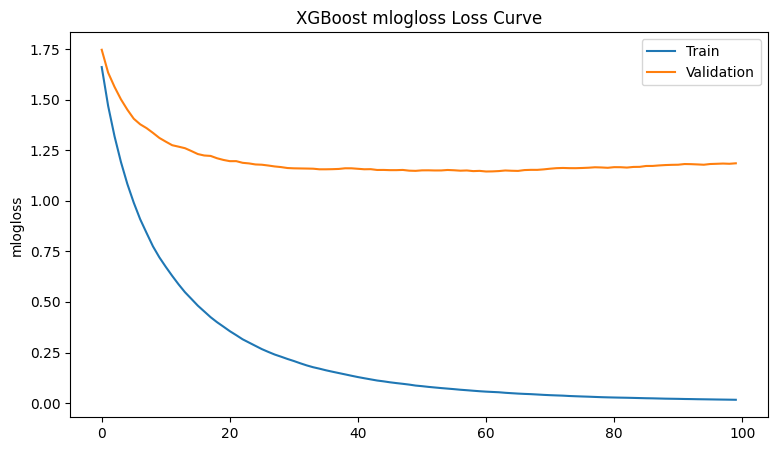

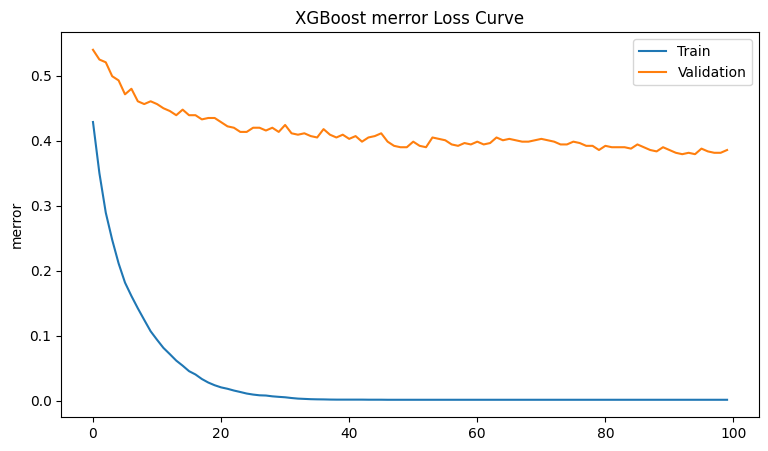

Final Accuracy on Validation Data: 		61.46%


In [ ]:
# prepare loss plots
results = xgb_clf.evals_result()
epochs = len(results['validation_0']['mlogloss']) # number of epochs
x_axis = range(0, epochs)

# mlogloss plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Validation')
ax.legend()
plt.ylabel('mlogloss')
plt.title('XGBoost mlogloss Loss Curve')
plt.show()

# merror plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Validation')
ax.legend()
plt.ylabel('merror')
plt.title('XGBoost merror Loss Curve')
plt.show()
y_pred = xgb_clf.predict(val_data_flat) # predict using validation data
accuracy = accuracy_score(val_labels, y_pred) # calculate prediction accuracy
print(f'Final Accuracy on Validation Data: \t\t{accuracy:.2%}')

In [ ]:
# predict on test data
y_pred_test = xgb_clf.predict(test_data_flat)

# define test file for kaggle
test_id = np.arange(0, 1136, 1)
pred_file = pd.DataFrame({"ID":test_id, "Predictions": y_pred_test})
pred_file.to_csv("Predictions/46165991-conv-xgb-raw.csv", index=False, header=True)
pred_file.head(5)

,ID,Predictions
0,0,3
1,1,3
2,2,6
3,3,0
4,4,6


In [ ]:
# compare training class frequency and prediction class frequency
class_freq_train = pd.DataFrame({'emotion': label_names, 'train_freq': np.round(percentages,2)}) # create training frequency df

# create prediction frequency df
prediction_counts = np.round(pd.Series(y_pred_test).value_counts(normalize=True).reset_index(),2)
prediction_counts.columns = ['emotion', 'pred_freq']
prediction_counts = prediction_counts.sort_values(by='emotion')
prediction_counts['pred_freq'] = prediction_counts['pred_freq']*100

# map numerical emotion values to actual emotions
prediction_counts['emotion'] = prediction_counts['emotion'].map(label_classes)

# set emotion columns as index
prediction_counts.set_index('emotion', inplace=True)
class_freq_train.set_index('emotion', inplace=True)

raw_svm_freq = pd.merge(class_freq_train, prediction_counts, left_index=True, right_index=True, how='left') # merge on index
raw_svm_freq['pred_freq'].fillna(0, inplace=True) # fill missing prediction classes with zero
raw_svm_freq['freq_deviation'] = raw_svm_freq['train_freq']-raw_svm_freq['pred_freq'] # calculate frequency difference
raw_svm_freq

,train_freq,pred_freq,freq_deviation
emotion,,,
angry,13.57,10.0,3.57
disgusted,2.26,1.0,1.26
fearful,11.87,7.0,4.87
happy,29.33,36.0,-6.67
sad,11.18,6.0,5.18
surprised,11.28,10.0,1.28
neutral,20.51,30.0,-9.49


Only 56.95% on test..

### XGBoost on enhanced Images

In [ ]:
xgb_clf_enh = xgb.XGBClassifier(objective='multi:softmax',
                                        num_class=7,
                                        learning_rate=0.3,
                                        gamma=0,
                                        n_estimators=100, # default
                                        max_depth=6, # default
                                        subsample=1, # default
                                        reg_alpha=0, # default
                                        reg_lambda=0, # default
                                        colsample_bytree=1, # default
                                        scale_pos_weight=1, # default
                                        early_stopping_rounds=10,
                                        eval_metric=['merror','mlogloss'],
                                        #verbose=0, # no message display during training and validation
                                        random_state=42)
# fit classifier
xgb_clf_enh.fit(train_data_enhance_flat, train_labels,
                        eval_set=[(train_data_enhance_flat, train_labels), (val_data_enhance_flat, val_labels)]) # define what to evaluate on

[06:05:05] WARNING: ../src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[0]	validation_0-merror:0.45458	validation_0-mlogloss:1.68674	validation_1-merror:0.62099	validation_1-mlogloss:1.79814
[1]	validation_0-merror:0.37242	validation_0-mlogloss:1.50989	validation_1-merror:0.55460	validation_1-mlogloss:1.69438
[2]	validation_0-merror:0.32141	validation_0-mlogloss:1.37002	validation_1-merror:0.52034	validation_1-mlogloss:1.61445
[3]	validation_0-merror:0.28541	validation_0-mlogloss:1.25617	validation_1-merror:0.50964	validation_1-mlogloss:1.56435
[4]	validation_0-merror:0.25065	validation_0-mlogloss:1.15350	validation_1-merror:0.51606	validation_1-mlogloss:1.52217
[5]	validation_0-merror:0.22616	validation_0-mlogloss:1.06532	validation_1-merror:0.50321	validation_1-mlogloss:1.47862
[6]	validation_0-merror:0.20415	validation_0-mlogloss:0.99202	validation_1-merror:0.49251	validation_1-mlogloss:1.44493
[7]	validation_0-merror:0.18316	validation_0-mlogloss:0.92332	vali

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              early_stopping_rounds=10, enable_categorical=False,
              eval_metric=['merror', 'mlogloss'], feature_types=None, gamma=0,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_class=7,
              num_parallel_tree=None, objective='multi:softmax', ...)

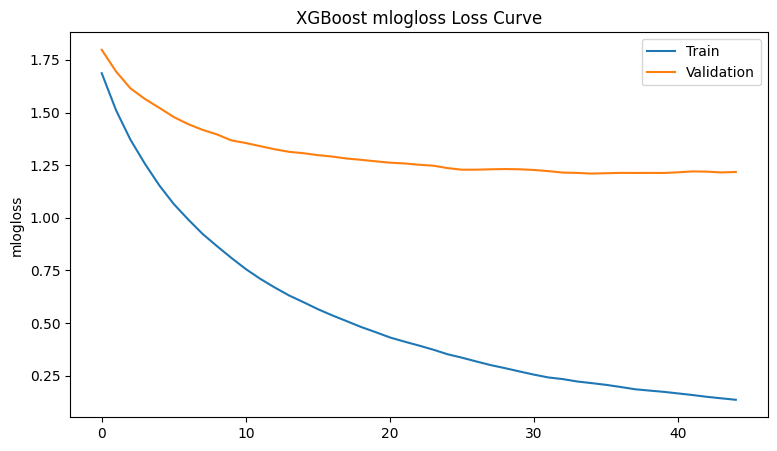

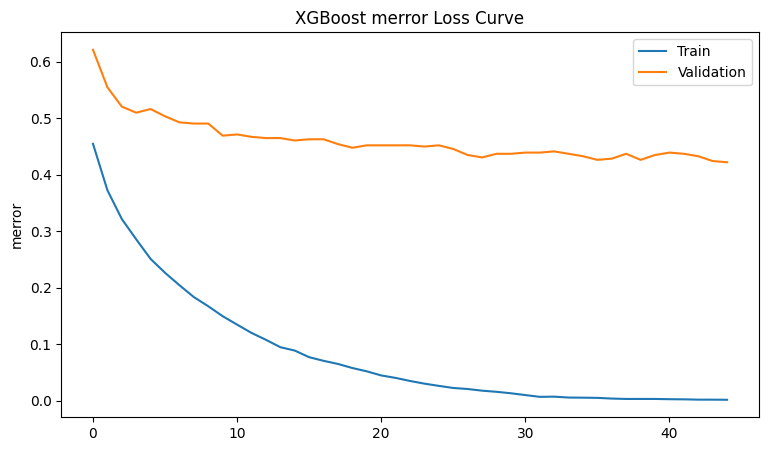

Final Accuracy on Validation Data: 		56.75%


In [ ]:
# prepare loss plots
results = xgb_clf_enh.evals_result()
epochs = len(results['validation_0']['mlogloss']) # number of epochs
x_axis = range(0, epochs)

# mlogloss plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Validation')
ax.legend()
plt.ylabel('mlogloss')
plt.title('XGBoost mlogloss Loss Curve')
plt.show()

# merror plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Validation')
ax.legend()
plt.ylabel('merror')
plt.title('XGBoost merror Loss Curve')
plt.show()
y_pred = xgb_clf_enh.predict(val_data_enhance_flat) # predict using validation data
accuracy = accuracy_score(val_labels, y_pred) # calculate prediction accuracy
print(f'Final Accuracy on Validation Data: \t\t{accuracy:.2%}')

### XGBoost on sharp Images

In [ ]:
xgb_clf_sharp = xgb.XGBClassifier(objective='multi:softmax',
                                        num_class=7,
                                        learning_rate=0.3,
                                        gamma=0,
                                        n_estimators=100, # default
                                        max_depth=6, # default
                                        subsample=1, # default
                                        reg_alpha=0, # default
                                        reg_lambda=0, # default
                                        colsample_bytree=1, # default
                                        scale_pos_weight=1, # default
                                        #early_stopping_rounds=10,
                                        eval_metric=['merror','mlogloss'],
                                        #verbose=0, # no message display during training and validation
                                        random_state=42)
# fit classifier
xgb_clf_sharp.fit(sharp_train_flat, train_labels,
                        eval_set=[(sharp_train_flat, train_labels), (sharp_val_flat, val_labels)]) # define what to evaluate on

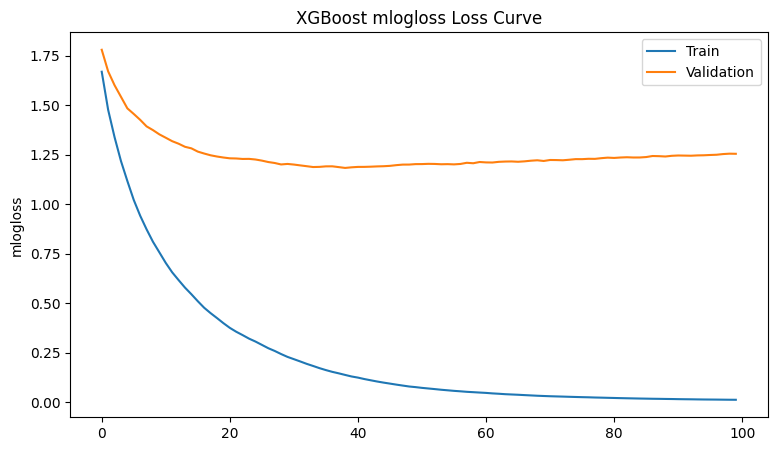

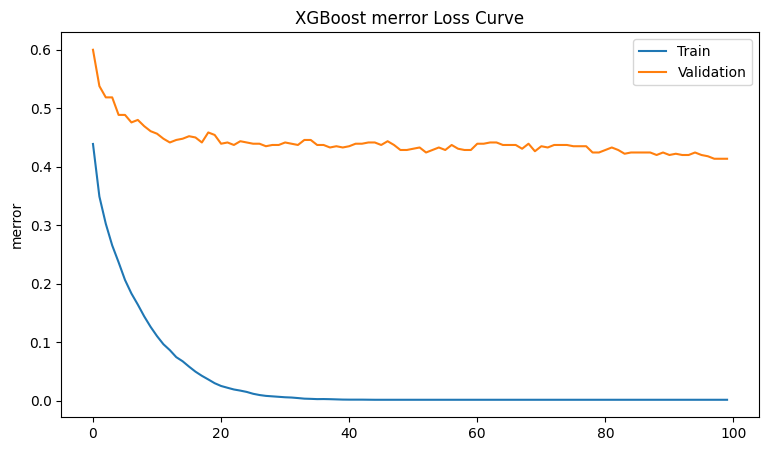

Final Accuracy on Validation Data: 		58.67%


In [ ]:
# prepare loss plots
results = xgb_clf_sharp.evals_result()
epochs = len(results['validation_0']['mlogloss']) # number of epochs
x_axis = range(0, epochs)

# mlogloss plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Validation')
ax.legend()
plt.ylabel('mlogloss')
plt.title('XGBoost mlogloss Loss Curve')
plt.show()

# merror plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Validation')
ax.legend()
plt.ylabel('merror')
plt.title('XGBoost merror Loss Curve')
plt.show()
y_pred = xgb_clf_sharp.predict(sharp_val_flat) # predict using validation data
accuracy = accuracy_score(val_labels, y_pred) # calculate prediction accuracy
print(f'Final Accuracy on Validation Data: \t\t{accuracy:.2%}')

While better than the model on scikit-image sharpened images, still worse than the original data.

### XGBoost on full image data

In [3]:
# load augmented flattened image data
full_train_data_flat = np.load('Data/full_train_data_flat.npy')
full_val_data_flat = np.load('Data/full_val_data_flat.npy')

# load label data
full_train_labels = np.load('Data/full_train_labels.npy')
full_val_labels = np.load('Data/full_val_labels.npy')

In [4]:
xgb_clf_full = xgb.XGBClassifier(objective='multi:softprob',
                                        #num_class=7,
                                        learning_rate=0.3,
                                        gamma=0,
                                        n_estimators=200, # default
                                        max_depth=5, # default
                                        subsample=0.9, # default
                                        colsample_bytree=1, # default
                                        early_stopping_rounds=15,
                                        eval_metric='auc',
                                        #verbose=0, # no message display during training and validation
                                        random_state=42)
# fit classifier
xgb_clf_full.fit(full_train_data_flat, full_train_labels,
                        eval_set=[(full_train_data_flat, full_train_labels), (full_val_data_flat, full_val_labels)]) # define what to evaluate on

[0]	validation_0-auc:0.73924	validation_1-auc:0.70173
[1]	validation_0-auc:0.78309	validation_1-auc:0.74554
[2]	validation_0-auc:0.80524	validation_1-auc:0.75900
[3]	validation_0-auc:0.82320	validation_1-auc:0.77093
[4]	validation_0-auc:0.83592	validation_1-auc:0.77990
[5]	validation_0-auc:0.84748	validation_1-auc:0.78643
[6]	validation_0-auc:0.85629	validation_1-auc:0.79014
[7]	validation_0-auc:0.86338	validation_1-auc:0.79637
[8]	validation_0-auc:0.87066	validation_1-auc:0.79925
[9]	validation_0-auc:0.87636	validation_1-auc:0.80349
[10]	validation_0-auc:0.88209	validation_1-auc:0.80630
[11]	validation_0-auc:0.88745	validation_1-auc:0.81139
[12]	validation_0-auc:0.89207	validation_1-auc:0.81201
[13]	validation_0-auc:0.89603	validation_1-auc:0.81365
[14]	validation_0-auc:0.89980	validation_1-auc:0.81642
[15]	validation_0-auc:0.90311	validation_1-auc:0.81805
[16]	validation_0-auc:0.90720	validation_1-auc:0.82028
[17]	validation_0-auc:0.91023	validation_1-auc:0.82082
[18]	validation_0-au

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              early_stopping_rounds=15, enable_categorical=False,
              eval_metric='auc', feature_types=None, gamma=0, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

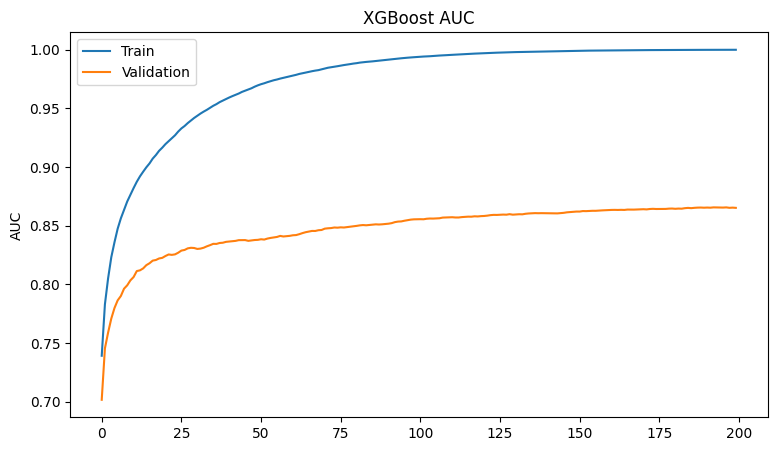

Final Accuracy on Validation Data: 		61.54%


In [5]:
# prepare loss plots
results = xgb_clf_full.evals_result()
epochs = len(results['validation_0']['auc']) # number of epochs
x_axis = range(0, epochs)

# auc plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Validation')
ax.legend()
plt.ylabel('AUC')
plt.title('XGBoost AUC')
plt.show()

y_pred = xgb_clf_full.predict(full_val_data_flat) # predict using validation data
accuracy = accuracy_score(full_val_labels, y_pred) # calculate prediction accuracy
print(f'Final Accuracy on Validation Data: \t\t{accuracy:.2%}')

In [10]:
# predict on test data
y_pred_test = xgb_clf_full.predict(test_data_flat)

# define test file for kaggle
test_id = np.arange(0, 1136, 1)
pred_file = pd.DataFrame({"ID":test_id, "Predictions": y_pred_test})
pred_file.to_csv("Predictions/46165991-conv-xgb-full.csv", index=False, header=True)
pred_file.head(5)

,ID,Predictions
0,0,3
1,1,3
2,2,2
3,3,0
4,4,6


In [11]:
# save model for reuse without retraining
xgb_clf_full.save_model('Models/model_xgb_clf_full.json')

# load
# xgb_clf_full = xgb.XGBClassifier()
# xgb_clf_full.load_model("Models/model_xgb_clf_full.json")

In [12]:
print(classification_report(full_val_labels, y_pred))

              precision    recall  f1-score   support

           0       0.56      0.41      0.47       315
           1       1.00      0.62      0.76        55
           2       0.47      0.32      0.38       275
           3       0.71      0.85      0.77       685
           4       0.41      0.25      0.31       260
           5       0.76      0.70      0.73       265
           6       0.54      0.74      0.62       480

    accuracy                           0.62      2335
   macro avg       0.63      0.56      0.58      2335
weighted avg       0.60      0.62      0.60      2335



## Raw Data + HOG ML Model

### Support Vector Machine

In [ ]:
svm_clf_hog = SVC(kernel='rbf', C=1.0) # initialise instance
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # use cross validation
scores = cross_val_score(svm_clf_hog, train_hog, train_labels, cv=cv, scoring='accuracy') # evaluate
svm_clf_hog.fit(train_hog, train_labels) # fit classifier on full data again
y_pred = svm_clf_hog.predict(val_hog) # predict using validation data
accuracy = accuracy_score(val_labels, y_pred) # calculate prediction accuracy

In [ ]:
# print cross-validation scores and final accuracy
print(f'Cross-Validation Scores: \t\t\t{scores}')
print(f'Average Cross-Validation Accuracy: \t\t{np.mean(scores):.2%}')
print(f'Cross-Validation Accuracy Standard Deviation: \t{np.std(scores):.2%}')
print(f'Final Accuracy on Validation Data: \t\t{accuracy:.2%}')

Cross-Validation Scores: 			[0.5284828  0.52934537 0.53611738 0.53273138 0.54288939]
Average Cross-Validation Accuracy: 		53.39%
Cross-Validation Accuracy Standard Deviation: 	0.52%
Final Accuracy on Validation Data: 		57.17%


In [ ]:
# predict on test data
y_pred_test = svm_clf_hog.predict(test_hog)

# define test file for kaggle
test_id = np.arange(0, 1136, 1)
pred_file = pd.DataFrame({"ID":test_id, "Predictions": y_pred_test})
pred_file.to_csv("Predictions/46165991-conv-svm-raw-hog.csv", index=False, header=True)
pred_file.head(5)

,ID,Predictions
0,0,3
1,1,3
2,2,2
3,3,0
4,4,6


In [ ]:
# compare training class frequency and prediction class frequency
class_freq_train = pd.DataFrame({'emotion': label_names, 'train_freq': np.round(percentages,2)}) # create training frequency df

# create prediction frequency df
prediction_counts = np.round(pd.Series(y_pred_test).value_counts(normalize=True).reset_index(),2)
prediction_counts.columns = ['emotion', 'pred_freq']
prediction_counts = prediction_counts.sort_values(by='emotion')
prediction_counts['pred_freq'] = prediction_counts['pred_freq']*100

# map numerical emotion values to actual emotions
prediction_counts['emotion'] = prediction_counts['emotion'].map(label_classes)

# set emotion columns as index
prediction_counts.set_index('emotion', inplace=True)
class_freq_train.set_index('emotion', inplace=True)

raw_svm_freq = pd.merge(class_freq_train, prediction_counts, left_index=True, right_index=True, how='left') # merge on index
raw_svm_freq['pred_freq'].fillna(0, inplace=True) # fill missing prediction classes with zero
raw_svm_freq['freq_deviation'] = raw_svm_freq['train_freq']-raw_svm_freq['pred_freq'] # calculate frequency difference
raw_svm_freq

,train_freq,pred_freq,freq_deviation
emotion,,,
angry,13.57,10.0,3.57
disgusted,2.26,0.0,2.26
fearful,11.87,6.0,5.87
happy,29.33,36.0,-6.67
sad,11.18,3.0,8.18
surprised,11.28,10.0,1.28
neutral,20.51,35.0,-14.49


### XGBoost

In [ ]:
xgb_clf_hog = xgb.XGBClassifier(objective='multi:softmax',
                                        num_class=7,
                                        learning_rate=0.3,
                                        gamma=0,
                                        n_estimators=100, # default
                                        max_depth=6, # default
                                        subsample=1, # default
                                        reg_alpha=0, # default
                                        reg_lambda=0, # default
                                        colsample_byree=1, # default
                                        scale_pos_weight=1, # default
                                        early_stopping_rounds=10,
                                        eval_metric=['merror','mlogloss'],
                                        #verbose=0, # no message display during training and validation
                                        random_state=42)
# fit classifier
xgb_clf_hog.fit(train_hog, train_labels,
                        eval_set=[(train_hog, train_labels), (val_hog, val_labels)]) # define what to evaluate on

[05:29:06] WARNING: ../src/learner.cc:767: 
Parameters: { "colsample_byree", "scale_pos_weight" } are not used.

[0]	validation_0-merror:0.42851	validation_0-mlogloss:1.66065	validation_1-merror:0.53961	validation_1-mlogloss:1.74610
[1]	validation_0-merror:0.35019	validation_0-mlogloss:1.46877	validation_1-merror:0.52463	validation_1-mlogloss:1.63311
[2]	validation_0-merror:0.29003	validation_0-mlogloss:1.31836	validation_1-merror:0.51820	validation_1-mlogloss:1.56281
[3]	validation_0-merror:0.24704	validation_0-mlogloss:1.19178	validation_1-merror:0.49251	validation_1-mlogloss:1.50141
[4]	validation_0-merror:0.20844	validation_0-mlogloss:1.07873	validation_1-merror:0.50321	validation_1-mlogloss:1.45190
[5]	validation_0-merror:0.17808	validation_0-mlogloss:0.98739	validation_1-merror:0.47537	validation_1-mlogloss:1.40924
[6]	validation_0-merror:0.16003	validation_0-mlogloss:0.91135	validation_1-merror:0.47537	validation_1-mlogloss:1.38487
[7]	validation_0-merror:0.13915	validation_0-ml

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_byree=1,
              colsample_bytree=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric=['merror', 'mlogloss'],
              feature_types=None, gamma=0, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.3, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_class=7, num_parallel_tree=None, ...)

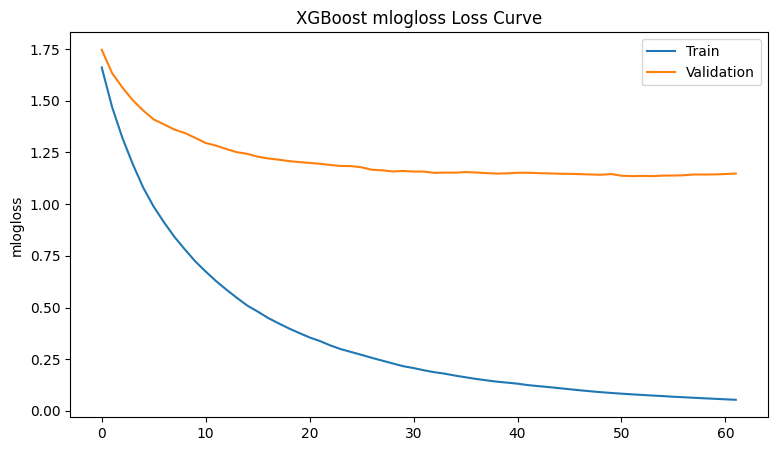

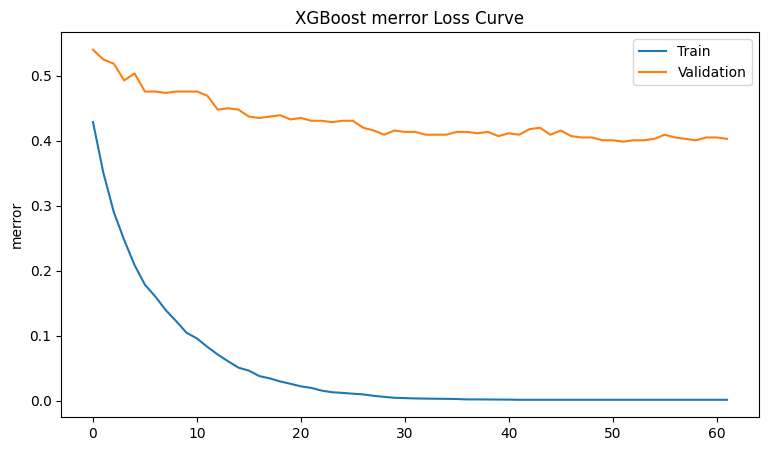

Final Accuracy on Validation Data: 		60.17%


In [ ]:
# prepare loss plots
results = xgb_clf_hog.evals_result()
epochs = len(results['validation_0']['mlogloss']) # number of epochs
x_axis = range(0, epochs)

# mlogloss plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Validation')
ax.legend()
plt.ylabel('mlogloss')
plt.title('XGBoost mlogloss Loss Curve')
plt.show()

# merror plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Validation')
ax.legend()
plt.ylabel('merror')
plt.title('XGBoost merror Loss Curve')
plt.show()
y_pred = xgb_clf_hog.predict(val_hog) # predict using validation data
accuracy = accuracy_score(val_labels, y_pred) # calculate prediction accuracy
print(f'Final Accuracy on Validation Data: \t\t{accuracy:.2%}')

## Raw Data + HOG + Harris Corner ML Model

### Support Vector Machine

In [ ]:
svm_clf_hog_corner = SVC(kernel='rbf', C=1.0) # initialise instance
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # use cross validation
scores = cross_val_score(svm_clf_hog_corner, train_hog_corner, train_labels, cv=cv, scoring='accuracy') # evaluate
svm_clf_hog_corner.fit(train_hog_corner, train_labels) # fit classifier on full data again
y_pred = svm_clf_hog_corner.predict(val_hog_corner) # predict using validation data
accuracy = accuracy_score(val_labels, y_pred) # calculate prediction accuracy

In [ ]:
# print cross-validation scores and final accuracy
print(f'Cross-Validation Scores: \t\t\t{scores}')
print(f'Average Cross-Validation Accuracy: \t\t{np.mean(scores):.2%}')
print(f'Cross-Validation Accuracy Standard Deviation: \t{np.std(scores):.2%}')
print(f'Final Accuracy on Validation Data: \t\t{accuracy:.2%}')

Cross-Validation Scores: 			[0.52791878 0.53160271 0.53724605 0.53329571 0.54232506]
Average Cross-Validation Accuracy: 		53.45%
Cross-Validation Accuracy Standard Deviation: 	0.49%
Final Accuracy on Validation Data: 		56.96%


In [ ]:
# predict on test data
y_pred_test = svm_clf_hog_corner.predict(test_hog_corner)

# define test file for kaggle
test_id = np.arange(0, 1136, 1)
pred_file = pd.DataFrame({"ID":test_id, "Predictions": y_pred_test})
pred_file.to_csv("Predictions/46165991-conv-svm-raw-hog-corner.csv", index=False, header=True)
pred_file.head(5)

,ID,Predictions
0,0,3
1,1,3
2,2,2
3,3,0
4,4,6


In [ ]:
# compare training class frequency and prediction class frequency
class_freq_train = pd.DataFrame({'emotion': label_names, 'train_freq': np.round(percentages,2)}) # create training frequency df

# create prediction frequency df
prediction_counts = np.round(pd.Series(y_pred_test).value_counts(normalize=True).reset_index(),2)
prediction_counts.columns = ['emotion', 'pred_freq']
prediction_counts = prediction_counts.sort_values(by='emotion')
prediction_counts['pred_freq'] = prediction_counts['pred_freq']*100

# map numerical emotion values to actual emotions
prediction_counts['emotion'] = prediction_counts['emotion'].map(label_classes)

# set emotion columns as index
prediction_counts.set_index('emotion', inplace=True)
class_freq_train.set_index('emotion', inplace=True)

raw_svm_freq = pd.merge(class_freq_train, prediction_counts, left_index=True, right_index=True, how='left') # merge on index
raw_svm_freq['pred_freq'].fillna(0, inplace=True) # fill missing prediction classes with zero
raw_svm_freq['freq_deviation'] = raw_svm_freq['train_freq']-raw_svm_freq['pred_freq'] # calculate frequency difference
raw_svm_freq

,train_freq,pred_freq,freq_deviation
emotion,,,
angry,13.57,10.0,3.57
disgusted,2.26,0.0,2.26
fearful,11.87,6.0,5.87
happy,29.33,36.0,-6.67
sad,11.18,3.0,8.18
surprised,11.28,10.0,1.28
neutral,20.51,35.0,-14.49


#### Hyperparameter Tuning
To conduct hyperparameter tuning on the SVM model, we will use a randomized grid search approach to reduce the required number of combinations for model computation. Specifically for SVM, the regularisation parameter C, the kernel to use, and the kernel coefficient gamma are the parameters of interest.

In [ ]:
def get_params(model, X_train, y_train, param_grid):
    """
    This function applies randomized grid search for hyperparameter tuning on a given estimator and returns
    the best score in combination with the according parameters used.
    """
    grid_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                                     scoring='accuracy', cv=5, n_jobs=-1, random_state=42)
    grid_search.fit(X_train, y_train)
    best_score = grid_search.best_score_ # retrieve best score
    best_params = grid_search.best_params_ # retrieve best parameters
    final_model = grid_search.best_estimator_

    return best_score, best_params, final_model

In [ ]:
# define parameter grid
param_grid = {
    'C': [0.01, 0.03, 0.1, 0.3, 1, 3, 5],
    'kernel': ['poly', 'rbf'],
    'gamma': [0.01, 0.03, 0.1, 0.3, 1, 3, 5]
    }

# define model
svm_hog_cor_hp = SVC(random_state=42)

In [ ]:
# apply grid search
best_score, best_params, final_model = get_params(model=svm_hog_cor_hp, X_train=train_hog_corner, y_train=train_labels, param_grid=param_grid)

In [ ]:
print(f'The best model parameters are: \t\t{best_params}\n'
      f'The highest accuract from cross-validation is: \t{best_score:.2%}\n')

The best model parameters are: 		{'kernel': 'poly', 'gamma': 0.01, 'C': 0.01}
The highest accuract from cross-validation is: 	55.25%



Let's now test this parameter-optimized model on the test data.

In [ ]:
# predict on test data
y_pred_test = final_model.predict(test_hog_corner)

# define test file for kaggle
test_id = np.arange(0, 1136, 1)
pred_file = pd.DataFrame({"ID":test_id, "Predictions": y_pred_test})
pred_file.to_csv("Predictions/46165991-conv-svm-raw-hog-corner-paramopti.csv", index=False, header=True)
pred_file.head(5)

,ID,Predictions
0,0,3
1,1,3
2,2,2
3,3,0
4,4,6


In [ ]:
# compare training class frequency and prediction class frequency
class_freq_train = pd.DataFrame({'emotion': label_names, 'train_freq': np.round(percentages,2)}) # create training frequency df

# create prediction frequency df
prediction_counts = np.round(pd.Series(y_pred_test).value_counts(normalize=True).reset_index(),2)
prediction_counts.columns = ['emotion', 'pred_freq']
prediction_counts = prediction_counts.sort_values(by='emotion')
prediction_counts['pred_freq'] = prediction_counts['pred_freq']*100

# map numerical emotion values to actual emotions
prediction_counts['emotion'] = prediction_counts['emotion'].map(label_classes)

# set emotion columns as index
prediction_counts.set_index('emotion', inplace=True)
class_freq_train.set_index('emotion', inplace=True)

raw_svm_freq = pd.merge(class_freq_train, prediction_counts, left_index=True, right_index=True, how='left') # merge on index
raw_svm_freq['pred_freq'].fillna(0, inplace=True) # fill missing prediction classes with zero
raw_svm_freq['freq_deviation'] = raw_svm_freq['train_freq']-raw_svm_freq['pred_freq'] # calculate frequency difference
raw_svm_freq

,train_freq,pred_freq,freq_deviation
emotion,,,
angry,13.57,11.0,2.57
disgusted,2.26,1.0,1.26
fearful,11.87,7.0,4.87
happy,29.33,34.0,-4.67
sad,11.18,5.0,6.18
surprised,11.28,10.0,1.28
neutral,20.51,33.0,-12.49


It is interesting to see that this is the first model that also included predictions from the emotion 'disgusted'. While we cannot evaluate if these are correctly predicted simply from looking at the overall accuracy, it can be noted that the CV accuracy improved compared to the previous SVM model. Also this is the model which achieved the best test data accuracy so far with 55.9%.

### Naive Bayes

### Ensemble Methods

#### Random Forest

In [ ]:
# initialise instance
rf_clf_hog_cor = RandomForestClassifier(n_estimators = 100, criterion='entropy', min_samples_split=3, max_features='sqrt',
                                        bootstrap=True, max_leaf_nodes = 16, n_jobs = -1, random_state = 42,
                                        class_weight=None, max_samples=None)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # use cross validation
scores = cross_val_score(rf_clf_hog_cor, train_hog_corner, train_labels, cv=cv, scoring='accuracy') # evaluate
rf_clf_hog_cor.fit(train_hog_corner, train_labels) # fit classifier on full data again
y_pred = rf_clf_hog_cor.predict(val_hog_corner) # predict using validation data
accuracy = accuracy_score(val_labels, y_pred) # calculate prediction accuracy

In [ ]:
# print cross-validation scores and final accuracy
print(f'Cross-Validation Scores: \t\t\t{scores}')
print(f'Average Cross-Validation Accuracy: \t\t{np.mean(scores):.2%}')
print(f'Cross-Validation Accuracy Standard Deviation: \t{np.std(scores):.2%}')
print(f'Final Accuracy on Validation Data: \t\t{accuracy:.2%}')

Cross-Validation Scores: 			[0.3857868  0.4006772  0.39390519 0.38713318 0.39164786]
Average Cross-Validation Accuracy: 		39.18%
Cross-Validation Accuracy Standard Deviation: 	0.53%
Final Accuracy on Validation Data: 		39.19%


It seems like the random forest algorithm is not well suited for detecting facial emotions from the input data given.

#### AdaBoost

In [ ]:
ada_clf_hog_cor = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth = 1), # decision stumps
                                    n_estimators = 200,
                                    algorithm = "SAMME.R", # real boosting algorithm
                                    learning_rate = 0.5, # lower learning rate to support generalization through shrinkage
                                    random_state = 42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # use cross validation
scores = cross_val_score(ada_clf_hog_cor, train_hog_corner, train_labels, cv=cv, scoring='accuracy') # evaluate
ada_clf_hog_cor.fit(train_hog_corner, train_labels) # fit classifier on full data again
y_pred = ada_clf_hog_cor.predict(val_hog_corner) # predict using validation data
accuracy = accuracy_score(val_labels, y_pred) # calculate prediction accuracy

In [ ]:
# print cross-validation scores and final accuracy
print(f'Cross-Validation Scores: \t\t\t{scores}')
print(f'Average Cross-Validation Accuracy: \t\t{np.mean(scores):.2%}')
print(f'Cross-Validation Accuracy Standard Deviation: \t{np.std(scores):.2%}')
print(f'Final Accuracy on Validation Data: \t\t{accuracy:.2%}')

Cross-Validation Scores: 			[0.45685279 0.4486456  0.4503386  0.46557562 0.45316027]
Average Cross-Validation Accuracy: 		45.49%
Cross-Validation Accuracy Standard Deviation: 	0.60%
Final Accuracy on Validation Data: 		50.75%


Again, on its own, AdaBoost does not seem to be a promising model.

#### XGBoost Default
We will first run a default XGBoost model to get a sense for how promising XGBoost is for our task.

In [ ]:
xgb_clf_hog_cor = xgb.XGBClassifier()
xgb_clf_hog_cor.fit(train_hog_corner, train_labels) # fit classifier on full data again
y_pred = xgb_clf_hog_cor.predict(val_hog_corner) # predict using validation data
accuracy = accuracy_score(val_labels, y_pred) # calculate prediction accuracy

In [ ]:
print(f'Final Accuracy on Validation Data: \t\t{accuracy:.2%}')

Final Accuracy on Validation Data: 		60.81%


In [ ]:
# predict on test data
y_pred_test = xgb_clf_hog_cor.predict(test_hog_corner)

# define test file for kaggle
test_id = np.arange(0, 1136, 1)
pred_file = pd.DataFrame({"ID":test_id, "Predictions": y_pred_test})
pred_file.to_csv("Predictions/46165991-conv-xgb-raw-hog-corner.csv", index=False, header=True)
pred_file.head(5)

,ID,Predictions
0,0,3
1,1,3
2,2,2
3,3,0
4,4,6


In [ ]:
# compare training class frequency and prediction class frequency
class_freq_train = pd.DataFrame({'emotion': label_names, 'train_freq': np.round(percentages,2)}) # create training frequency df

# create prediction frequency df
prediction_counts = np.round(pd.Series(y_pred_test).value_counts(normalize=True).reset_index(),2)
prediction_counts.columns = ['emotion', 'pred_freq']
prediction_counts = prediction_counts.sort_values(by='emotion')
prediction_counts['pred_freq'] = prediction_counts['pred_freq']*100

# map numerical emotion values to actual emotions
prediction_counts['emotion'] = prediction_counts['emotion'].map(label_classes)

# set emotion columns as index
prediction_counts.set_index('emotion', inplace=True)
class_freq_train.set_index('emotion', inplace=True)

raw_svm_freq = pd.merge(class_freq_train, prediction_counts, left_index=True, right_index=True, how='left') # merge on index
raw_svm_freq['pred_freq'].fillna(0, inplace=True) # fill missing prediction classes with zero
raw_svm_freq['freq_deviation'] = raw_svm_freq['train_freq']-raw_svm_freq['pred_freq'] # calculate frequency difference
raw_svm_freq

,train_freq,pred_freq,freq_deviation
emotion,,,
angry,13.57,10.0,3.57
disgusted,2.26,1.0,1.26
fearful,11.87,8.0,3.87
happy,29.33,35.0,-5.67
sad,11.18,7.0,4.18
surprised,11.28,10.0,1.28
neutral,20.51,30.0,-9.49


Just the default XGBoost model on this input data combination looks already more promising than the hyperparameter tuned SVM. On the test data, this model achieved an accuracy of 59.07%.

##### XGBoost Initial HP
There are a few important hyperparameters to consider for XGBoost:


1.   `'learning_rate'`: How fast the learning occurs; default=0.3.
2.   `'gamma'`: Minimum loss reduction required to make a further partition on a leaf node of the tree. Larger gamma = more conservative; default=0.
3.    `'max_depth'`: Maximum depth of a tree. Larger value = more complex, more likely to overfit; default=6.
4.    `'subsample'`: Subsample ratio of the training instances; default=1 -> whole data. Regulate model complexity for overfitting.
5.    `'eval_metric'`:
6.    `'reg_alpha'`: L1 regularization term on weights.
7.    `'reg_lambda'`: L2 regularization term on weights.
8.    `'n_estimators'`: More rounds for smaller learning rate.
9.    `'colsample_bytree'`: Subsample ratio of columns for tree construction.
10.   `'scale_pos_weight'`: Useful for class imbalances e.g. `sum(negative instances) / sum(positive instances)`
11.   `'objective'`: `multi:softmax` for multiclass classification --> needs `num_class` in conjunction.
12.   `'eval_metric'`: `merror` and `mlogloss` reasonable
13.   `'random_state'`: Make results reproducible.
14.   `'early_stopping_rounds'`: Introduce early stopping after x amount of epochs without improvement


Before changing any parameters, the first change we will make is with respect to the objective as the default is a squared regression loss which probably is not very suitable for our classification task. After that we can go into hyperparameter tuning. To get a better feeling for early stopping, we output loss plots respective to both evaluation metrics used.

In [ ]:
xgb_clf_hog_cor_hp1 = xgb.XGBClassifier(objective='multi:softmax',
                                        num_class=7,
                                        learning_rate=0.3,
                                        gamma=0,
                                        n_estimators=100, # default
                                        max_depth=6, # default
                                        subsample=1, # default
                                        reg_alpha=0, # default
                                        reg_lambda=0, # default
                                        colsample_bytree=1, # default
                                        #early_stopping_rounds=10,
                                        eval_metric=['merror','mlogloss'],
                                        #verbose=0, # no message display during training and validation
                                        random_state=42)
# fit classifier
xgb_clf_hog_cor_hp1.fit(train_hog_corner, train_labels,
                        eval_set=[(train_hog_corner, train_labels), (val_hog_corner, val_labels)]) # define what to evaluate on

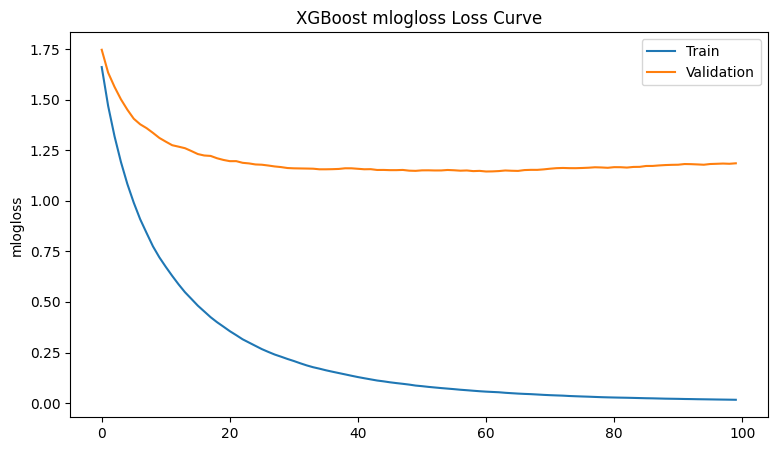

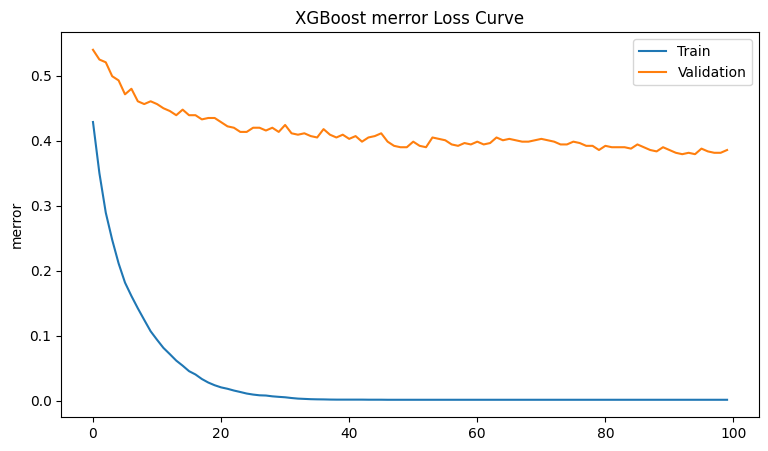

Final Accuracy on Validation Data: 		61.46%


In [ ]:
# prepare loss plots
results = xgb_clf_hog_cor_hp1.evals_result()
epochs = len(results['validation_0']['mlogloss']) # number of epochs
x_axis = range(0, epochs)

# mlogloss plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Validation')
ax.legend()
plt.ylabel('mlogloss')
plt.title('XGBoost mlogloss Loss Curve')
plt.show()

# merror plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Validation')
ax.legend()
plt.ylabel('merror')
plt.title('XGBoost merror Loss Curve')
plt.show()
y_pred = xgb_clf_hog_cor_hp1.predict(val_hog_corner) # predict using validation data
accuracy = accuracy_score(val_labels, y_pred) # calculate prediction accuracy
print(f'Final Accuracy on Validation Data: \t\t{accuracy:.2%}')

It can clearly be seen that early stopping should be used to prevent overfitting as the training loss diverges from the validation loss. However, just the objective parameter change has lead to a slight increase in accuracy on the validation data. Even though it does not affect the trees used during predict() using the scikit-learn API, we will save computation time by limiting the number of epochs to what is validation error optimal. We can retrieve the optimal number of trees/epochs for the model:

In [ ]:
xgb_clf_hog_cor_hp1.best_ntree_limit

100

In [ ]:
# predict on test data
y_pred_test = xgb_clf_hog_cor_hp1.predict(test_hog_corner)

# define test file for kaggle
test_id = np.arange(0, 1136, 1)
pred_file = pd.DataFrame({"ID":test_id, "Predictions": y_pred_test})
pred_file.to_csv("Predictions/46165991-conv-xgb-raw-hog-corner_hp1.csv", index=False, header=True)
pred_file.head(5)

,ID,Predictions
0,0,3
1,1,3
2,2,2
3,3,0
4,4,6


In [ ]:
# compare training class frequency and prediction class frequency
class_freq_train = pd.DataFrame({'emotion': label_names, 'train_freq': np.round(percentages,2)}) # create training frequency df

# create prediction frequency df
prediction_counts = np.round(pd.Series(y_pred_test).value_counts(normalize=True).reset_index(),2)
prediction_counts.columns = ['emotion', 'pred_freq']
prediction_counts = prediction_counts.sort_values(by='emotion')
prediction_counts['pred_freq'] = prediction_counts['pred_freq']*100

# map numerical emotion values to actual emotions
prediction_counts['emotion'] = prediction_counts['emotion'].map(label_classes)

# set emotion columns as index
prediction_counts.set_index('emotion', inplace=True)
class_freq_train.set_index('emotion', inplace=True)

raw_svm_freq = pd.merge(class_freq_train, prediction_counts, left_index=True, right_index=True, how='left') # merge on index
raw_svm_freq['pred_freq'].fillna(0, inplace=True) # fill missing prediction classes with zero
raw_svm_freq['freq_deviation'] = raw_svm_freq['train_freq']-raw_svm_freq['pred_freq'] # calculate frequency difference
raw_svm_freq

,train_freq,pred_freq,freq_deviation
emotion,,,
angry,13.57,11.0,2.57
disgusted,2.26,1.0,1.26
fearful,11.87,8.0,3.87
happy,29.33,35.0,-5.67
sad,11.18,6.0,5.18
surprised,11.28,10.0,1.28
neutral,20.51,29.0,-8.49


While the validation accuracy increased, the test accuracy decreased which indicates that reg:squaredloss, i.e., the default objective is more suitable for our problem.

Let's now try a different evaluation metric. AUC might prove useful since it is supposed to handle class imbalance better than other evaluation metrics.

In [ ]:
xgb_clf_hog_cor_hp2 = xgb.XGBClassifier(objective='multi:softprob',
                                        #num_class=7,
                                        learning_rate=0.3,
                                        gamma=0,
                                        n_estimators=100, # default
                                        max_depth=6, # default
                                        subsample=1, # default
                                        colsample_bytree=1, # default
                                        early_stopping_rounds=20,
                                        eval_metric=['auc'],
                                        n_jobs=8,
                                        #verbose=0, # no message display during training and validation
                                        random_state=42)
# fit classifier
xgb_clf_hog_cor_hp2.fit(train_hog_corner, train_labels,
                        eval_set=[(train_hog_corner, train_labels), (val_hog_corner, val_labels)]) # define what to evaluate on

In [ ]:
# prepare loss plots
results = xgb_clf_hog_cor_hp2.evals_result()
epochs = len(results['validation_0']['auc']) # number of epochs
x_axis = range(0, epochs)

# auc plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Validation')
ax.legend()
plt.ylabel('AUC')
plt.title('XGBoost AUC')
plt.show()

# accuracy on validation set
y_pred = xgb_clf_hog_cor_hp2.predict(val_hog_corner) # predict using validation data
accuracy = accuracy_score(val_labels, y_pred) # calculate prediction accuracy
print(f'Final Accuracy on Validation Data: \t\t{accuracy:.2%}')

In [ ]:
# save model for reuse without retraining
xgb_clf_hog_cor_hp2.save_model("Models/xgb_clf_hog_cor_hp2.json")

# load
# xgb_clf_hog_cor_hp2 = XGBClassifier()
# xgb_clf_hog_cor_hp2.laod_model("Models/xgb_clf_hog_cor_hp2.json")

In [ ]:
# predict on test data
y_pred_test = xgb_clf_hog_cor_hp2.predict(test_hog_corner)

# define test file for kaggle
test_id = np.arange(0, 1136, 1)
pred_file = pd.DataFrame({"ID":test_id, "Predictions": y_pred_test})
pred_file.to_csv("Predictions/46165991-conv-xgb-raw-hog-corner_hp2.csv", index=False, header=True)
pred_file.head(5)

NameError: ignored

In [ ]:
# compare training class frequency and prediction class frequency
class_freq_train = pd.DataFrame({'emotion': label_names, 'train_freq': np.round(percentages,2)}) # create training frequency df

# create prediction frequency df
prediction_counts = np.round(pd.Series(y_pred_test).value_counts(normalize=True).reset_index(),2)
prediction_counts.columns = ['emotion', 'pred_freq']
prediction_counts = prediction_counts.sort_values(by='emotion')
prediction_counts['pred_freq'] = prediction_counts['pred_freq']*100

# map numerical emotion values to actual emotions
prediction_counts['emotion'] = prediction_counts['emotion'].map(label_classes)

# set emotion columns as index
prediction_counts.set_index('emotion', inplace=True)
class_freq_train.set_index('emotion', inplace=True)

raw_svm_freq = pd.merge(class_freq_train, prediction_counts, left_index=True, right_index=True, how='left') # merge on index
raw_svm_freq['pred_freq'].fillna(0, inplace=True) # fill missing prediction classes with zero
raw_svm_freq['freq_deviation'] = raw_svm_freq['train_freq']-raw_svm_freq['pred_freq'] # calculate frequency difference
raw_svm_freq

In [ ]:
# cross validation
from sklearn.model_selection import KFold

cv = KFold(
    n_splits=5,
    shuffle=True,
    random_state=1121218,
)

fold = 0
scores = np.empty(5)
for train_idx, test_idx in cv.split(p_input, p_target):
    print(f"Started fold {fold}...")
    # Create the training sets from training indices
    X_cv_train, y_cv_train = p_input.iloc[train_idx], p_target.iloc[train_idx]
    # Create the test sets from test indices
    X_cv_test, y_cv_test = p_input.iloc[test_idx], p_target.iloc[test_idx]
    # Init/fit XGB
    model = xgb.XGBRegressor(
        objective="reg:squarederror", n_estimators=10000, learning_rate=0.05
    )
    model.fit(
        X_cv_train,
        y_cv_train,
        eval_set=[(X_cv_test, y_cv_test)],
        early_stopping_rounds=50,
        verbose=False,
    )
    # Generate preds, evaluate
    preds = model.predict(X_cv_test)
    rmsle = np.sqrt(mean_squared_log_error(y_cv_test, preds))
    print("RMSLE of fold {}: {:.4f}\n".format(fold, rmsle))
    scores[fold] = rmsle
    fold += 1

print("Overall RMSLE: {:.4f}".format(np.mean(scores)))

##### XGBoost Balanced Classes



In [ ]:
xgb_clf_hog_cor_balanced = xgb.XGBClassifier(objective='reg:squarederror', # default
                                        learning_rate=0.3,
                                        gamma=0,
                                        n_estimators=100, # default
                                        max_depth=6, # default
                                        subsample=1, # default
                                        reg_alpha=0, # default
                                        reg_lambda=0, # default
                                        colsample_bytree=1, # default
                                        early_stopping_rounds=10,
                                        eval_metric=['merror','mlogloss'],
                                        verbose=0, # no message display during training and validation
                                        random_state=42)

# adjust class weights
classes_weights = class_weight.compute_sample_weight(class_weight='balanced', y=train_labels)

# fit classifier
xgb_clf_hog_cor_balanced.fit(train_hog_corner, train_labels,
                        sample_weight=classes_weights,
                        eval_set=[(train_hog_corner, train_labels), (val_hog_corner, val_labels)]) # define what to evaluate on

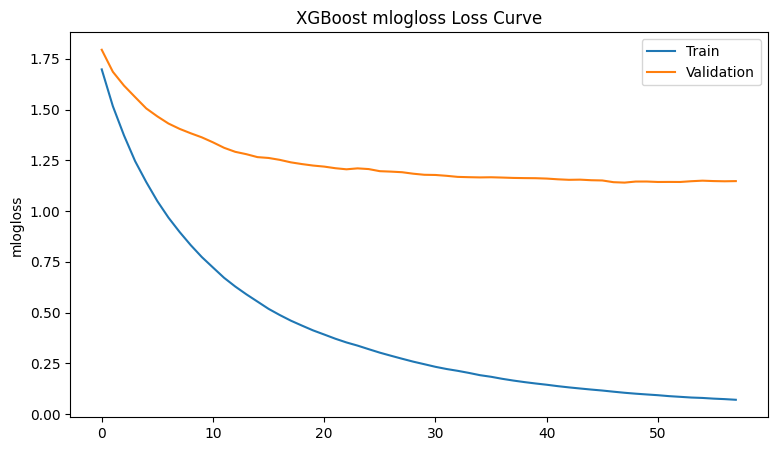

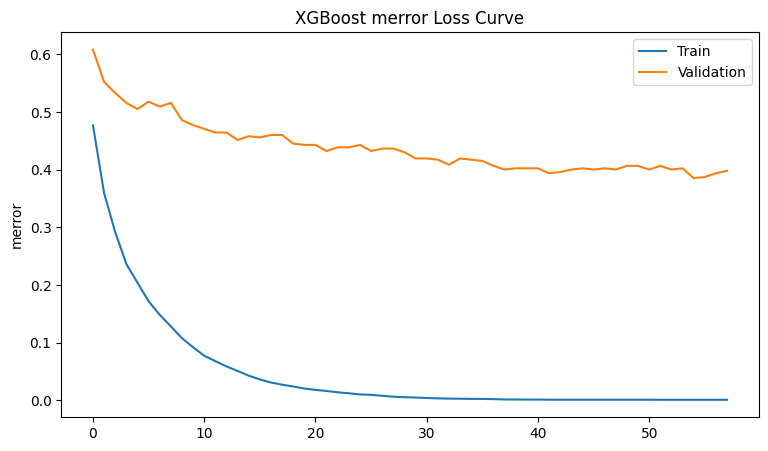

Final Accuracy on Validation Data: 		59.96%


In [ ]:
# prepare loss plots
results = xgb_clf_hog_cor_balanced.evals_result()
epochs = len(results['validation_0']['mlogloss']) # number of epochs
x_axis = range(0, epochs)

# mlogloss plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Validation')
ax.legend()
plt.ylabel('mlogloss')
plt.title('XGBoost mlogloss Loss Curve')
plt.show()

# merror plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Validation')
ax.legend()
plt.ylabel('merror')
plt.title('XGBoost merror Loss Curve')
plt.show()
y_pred = xgb_clf_hog_cor_balanced.predict(val_hog_corner) # predict using validation data
accuracy = accuracy_score(val_labels, y_pred) # calculate prediction accuracy
print(f'Final Accuracy on Validation Data: \t\t{accuracy:.2%}')

Balancing did not seem to improve accuracy, at least on the validation data.

In [ ]:
# save model for reuse without retraining
xgb_clf_hog_cor_balanced.save_model("Models/xgb_clf_hog_cor_balanced.json")

# load
# xgb_clf_hog_cor_balanced = xgb.XGBClassifier()
# xgb_clf_hog_cor_balanced.laod_model("Models/xgb_clf_hog_cor_balanced.json")

##### Hyperparameter Tuning

#### LightGBM

In [ ]:
lgbm_clf_hog_corner = lgb.LGBMClassifier(objective='multiclass',
                                        num_class=7,
                                        data_sample_strategy='bagging', # effective when bagging_freq > 0 and bagging_fraction < 1.0
                                        num_iterations=100, # internally: num_iter*num_class for multiclass
                                        learning_rate=0.1,
                                        num_leaves=31, # default
                                        max_depth=-1, # default, generally <0
                                        min_data_in_leaf=20, # default
                                        bagging_fraction=1, # default
                                        bagging_freq=0, # default, bagging every k iterations
                                        feature_fraction=1, # default, subset of features per tree
                                        early_stopping_round=10, # stop after k rounds without validation improvement
                                        is_unbalance=False, # default, indicate class imbalances
                                        verbosity=1, # show warnings
                                        random_state=42)
lgbm_clf_hog_corner.fit(train_hog_corner, train_labels,
                       eval_set=[(val_hog_corner, val_labels),(train_hog_corner, train_labels)],
                       eval_metric=['multi_logloss', 'multi_error'])

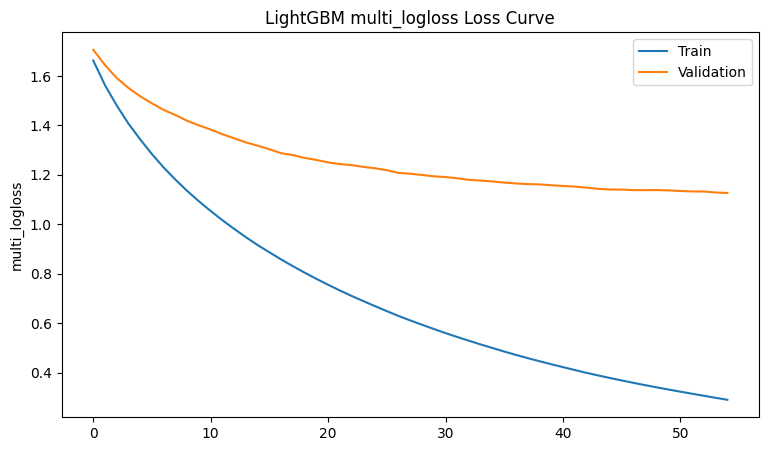

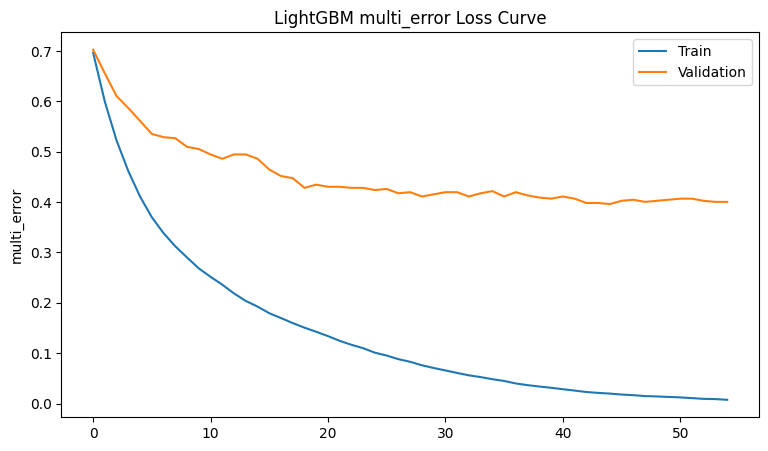

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
Final Accuracy on Validation Data: 		60.39%


In [ ]:
# prepare loss plots
results = lgbm_clf_hog_corner.evals_result_
epochs = len(results['training']['multi_logloss']) # number of epochs
x_axis = range(0, epochs)

# multi_logloss plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['training']['multi_logloss'], label='Train')
ax.plot(x_axis, results['valid_0']['multi_logloss'], label='Validation')
ax.legend()
plt.ylabel('multi_logloss')
plt.title('LightGBM multi_logloss Loss Curve')
plt.show()

# multi_error plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['training']['multi_error'], label='Train')
ax.plot(x_axis, results['valid_0']['multi_error'], label='Validation')
ax.legend()
plt.ylabel('multi_error')
plt.title('LightGBM multi_error Loss Curve')
plt.show()
y_pred = lgbm_clf_hog_corner.predict(val_hog_corner) # predict using validation data
accuracy = accuracy_score(val_labels, y_pred) # calculate prediction accuracy
print(f'Final Accuracy on Validation Data: \t\t{accuracy:.2%}')

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

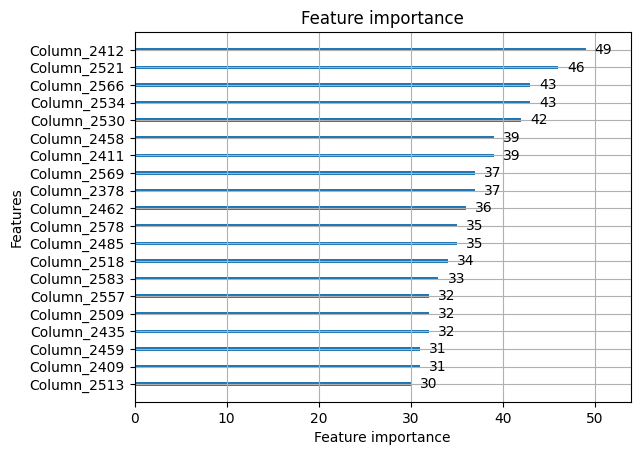

In [ ]:
lgb.plot_importance(lgbm_clf_hog_corner, max_num_features=20)

Until 2304: original data  
Until 2592: hog features  
Larger 2592: harris corners
The above shows that HOG features are particularly relevant as they make up all of the top 20 most relevant features in the LightGBM model.

<Axes: >

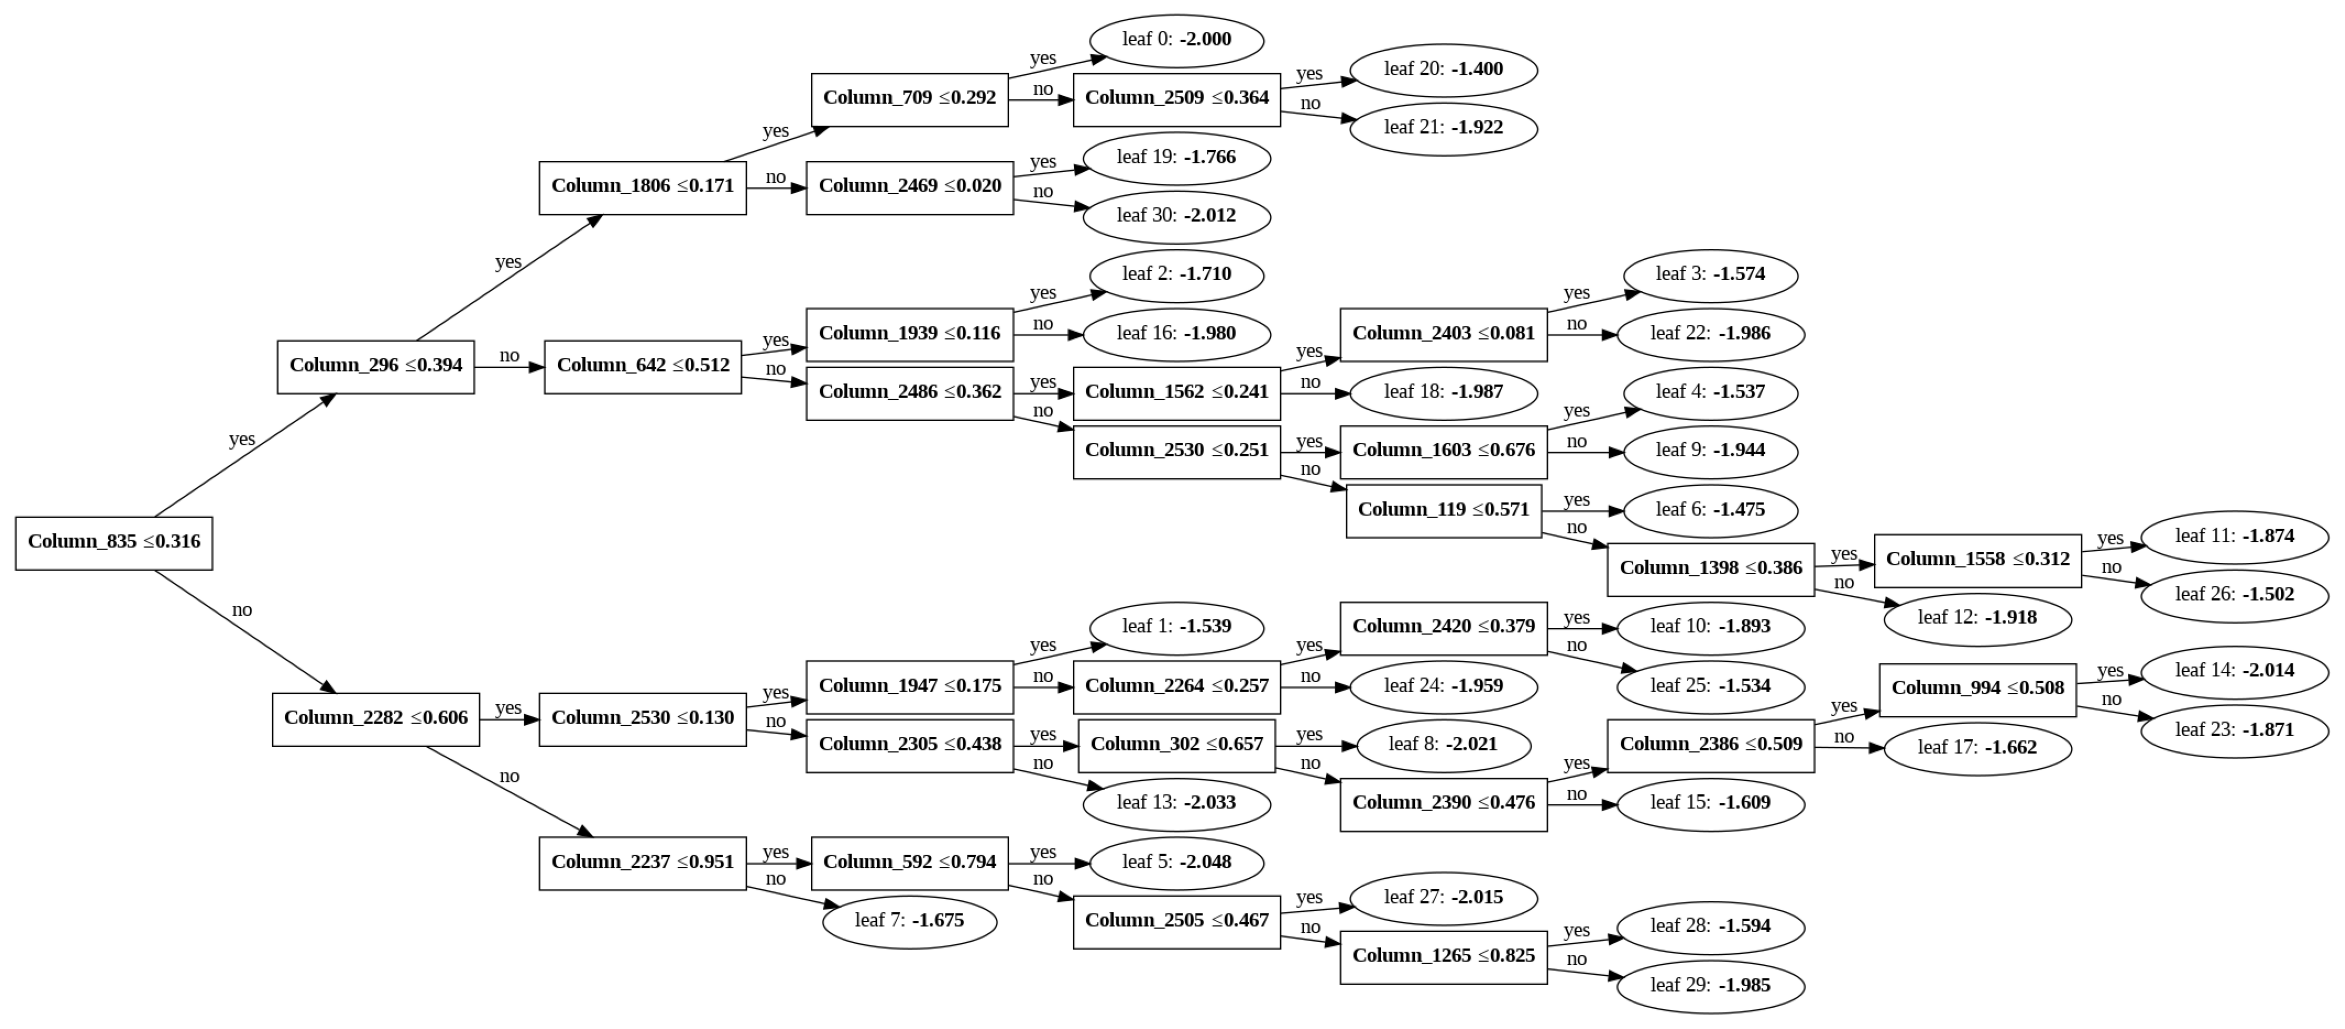

In [ ]:
lgb.plot_tree(lgbm_clf_hog_corner,figsize=(30,40))

In [ ]:
# save model
joblib.dump(lgbm_clf_hog_corner, 'Models/lgbm_clf_hog_corner.pkl')
# load model
# lgbm_clf_hog_corner = joblib.load('Models/lgbm_clf_hog_corner.pkl')

['Models/lgbm_clf_hog_corner.pkl']

#### Stacking
Another approach is to leverage the capabilities of several models through stacking. We will employ different ensemble methods for model training and then use their validation set predictions as input for a final meta-model.
https://medium.com/@brijesh_soni/stacking-to-improve-model-performance-a-comprehensive-guide-on-ensemble-learning-in-python-9ed53c93ce28
Then, try combining multiple models as part of an ensemble. What tends to work reasonably well on Kaggle is to stack the big three — XGBoost, CatBoost, and LightGBM.

1. Train Base Models: We will use SVM, XGBoost, LightGBM
2. Predict Individually on Validation Data
3. Use Validation Predictions as Blender Input: We will use softmax regression
4. Predict on Test Data using Blender

In [ ]:
# define base models
svm_hog_cor_hp = SVC(kernel= 'poly', gamma= 0.01, C= 0.01, random_state=42) # define SVM
xgb_clf_hog_cor = xgb.XGBClassifier(random_state=42) # define xgboost

# train base models
svm_hog_cor_hp.fit(train_hog_corner, train_labels)
xgb_clf_hog_cor.fit(train_hog_corner, train_labels)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [ ]:
# save base models for reuse
joblib.dump(svm_hog_cor_hp, 'Models/svm_hog_cor_hp_stack_base.pkl')
xgb_clf_hog_cor.save_model("Models/xgb_clf_hog_cor_stack_base.json")

In [ ]:
lgbm_clf_hog_corner = joblib.load('Models/lgbm_clf_hog_corner.pkl') # load lightgbm from saved models

In [ ]:
# predict on validation data
svm_base_pred = svm_hog_cor_hp.predict(val_hog_corner)
xgb_base_pred = xgb_clf_hog_cor.predict(val_hog_corner)
lgbm_base_pred = lgbm_clf_hog_corner.predict(val_hog_corner)

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1


In [ ]:
# combine base models predictions into feature matrix
val_hog_corner_meta = np.column_stack((svm_base_pred, xgb_base_pred, lgbm_base_pred))

# train blender
blender_logreg = LogisticRegression(multi_class = 'multinomial', random_state=42)
blender_logreg.fit(val_hog_corner_meta, val_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(multi_class='multinomial', random_state=42)

In [ ]:
# predict on test data using base models
svm_base_pred_test = svm_hog_cor_hp.predict(test_hog_corner)
xgb_base_pred_test = xgb_clf_hog_cor.predict(test_hog_corner)
lgbm_base_pred_test = lgbm_clf_hog_corner.predict(test_hog_corner)

# combine predictions
test_hog_corner_meta = np.column_stack((svm_base_pred_test, xgb_base_pred_test, lgbm_base_pred_test))

# predict using blender
blender_logreg_preds = blender_logreg.predict(test_hog_corner_meta)

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1


In [ ]:
# define test file for kaggle
test_id = np.arange(0, 1136, 1)
pred_file = pd.DataFrame({"ID":test_id, "Predictions": blender_logreg_preds})
pred_file.to_csv("Predictions/46165991-conv-stack-raw-hog-corner.csv", index=False, header=True)
pred_file.head(5)

,ID,Predictions
0,0,3
1,1,3
2,2,3
3,3,3
4,4,6


##### Random Forest Blender

In [ ]:
# load base models for reuse
lgbm_clf_hog_corner_base = joblib.load('Models/lgbm_clf_hog_corner.pkl') # load lightgbm from saved models
svm_hog_cor_hp_stack_base = joblib.load('Models/svm_hog_cor_hp_stack_base.pkl') # load SVM from saved models
xgb_clf_hog_cor_base = xgb.XGBClassifier()
xgb_clf_hog_cor_base.load_model("Models/xgb_clf_hog_cor_stack_base.json") # load xgboost

In [ ]:
# predict on validation data
lgbm_clf_hog_corner_base_pred = lgbm_clf_hog_corner_base.predict(val_hog_corner)
svm_hog_cor_hp_stack_base_pred = svm_hog_cor_hp_stack_base.predict(val_hog_corner)
xgb_clf_hog_cor_base_pred = xgb_clf_hog_cor_base.predict(val_hog_corner)

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1


In [ ]:
# combine base models predictions into feature matrix
val_hog_corner_meta = np.column_stack((svm_hog_cor_hp_stack_base_pred, xgb_clf_hog_cor_base_pred, lgbm_clf_hog_corner_base_pred))

# predict on test data using base models
svm_base_pred_test = xgb_clf_hog_cor_base.predict(test_hog_corner)
xgb_base_pred_test = svm_hog_cor_hp_stack_base.predict(test_hog_corner)
lgbm_base_pred_test = lgbm_clf_hog_corner_base.predict(test_hog_corner)

# combine predictions
test_hog_corner_meta = np.column_stack((svm_base_pred_test, xgb_base_pred_test, lgbm_base_pred_test))

# train blender
blender_rf = RandomForestClassifier(n_estimators = 200, criterion='entropy', min_samples_split=3, max_features='sqrt',
                                        bootstrap=False, max_leaf_nodes = 16, n_jobs = -1, random_state = 42,
                                        class_weight=None, max_samples=None)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # use cross validation
scores = cross_val_score(blender_rf, val_hog_corner_meta, val_labels, cv=cv, scoring='accuracy') # evaluate
blender_rf.fit(val_hog_corner_meta, val_labels) # fit classifier on full data again
# y_pred = blender_rf.predict(val_hog_corner) # predict using validation data
# accuracy = accuracy_score(val_labels, y_pred) # calculate prediction accuracy

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1


RandomForestClassifier(bootstrap=False, criterion='entropy', max_leaf_nodes=16,
                       min_samples_split=3, n_estimators=200, n_jobs=-1,
                       random_state=42)

In [ ]:
# print cross-validation scores and final accuracy
print(f'Cross-Validation Scores: \t\t\t{scores}')
print(f'Average Cross-Validation Accuracy: \t\t{np.mean(scores):.2%}')
print(f'Cross-Validation Accuracy Standard Deviation: \t{np.std(scores):.2%}')
# print(f'Final Accuracy on Validation Data: \t\t{accuracy:.2%}')

Cross-Validation Scores: 			[0.60638298 0.58510638 0.55913978 0.56989247 0.7311828 ]
Average Cross-Validation Accuracy: 		61.03%
Cross-Validation Accuracy Standard Deviation: 	6.25%


In [ ]:
# predict using blender
blender_rf_preds = blender_rf.predict(test_hog_corner_meta)

In [ ]:
# define test file for kaggle
test_id = np.arange(0, 1136, 1)
pred_file = pd.DataFrame({"ID":test_id, "Predictions": blender_rf_preds})
pred_file.to_csv("Predictions/46165991-conv-stackRF-raw-hog-corner.csv", index=False, header=True)
pred_file.head(5)

,ID,Predictions
0,0,3
1,1,3
2,2,5
3,3,0
4,4,6


This blender achieved an accuracy of 58.19% on the test data.

## Raw Data + HOG + Harris Corner + LBP ML Model

### Support Vector Machine

In [ ]:
svm_clf_hog_corner_lbp = SVC(kernel='rbf', C=1.0) # initialise instance
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # use cross validation
scores = cross_val_score(svm_clf_hog_corner_lbp, train_hog_corner_lbp, train_labels, cv=cv, scoring='accuracy') # evaluate
svm_clf_hog_corner_lbp.fit(train_hog_corner_lbp, train_labels) # fit classifier on full data again
y_pred = svm_clf_hog_corner_lbp.predict(val_hog_corner_lbp) # predict using validation data
accuracy = accuracy_score(val_labels, y_pred) # calculate prediction accuracy

In [ ]:
# print cross-validation scores and final accuracy
print(f'Cross-Validation Scores: \t\t\t{scores}')
print(f'Average Cross-Validation Accuracy: \t\t{np.mean(scores):.2%}')
print(f'Cross-Validation Accuracy Standard Deviation: \t{np.std(scores):.2%}')
print(f'Final Accuracy on Validation Data: \t\t{accuracy:.2%}')

Cross-Validation Scores: 			[0.52791878 0.53160271 0.53837472 0.53216704 0.53950339]
Average Cross-Validation Accuracy: 		53.39%
Cross-Validation Accuracy Standard Deviation: 	0.44%
Final Accuracy on Validation Data: 		56.96%


The addition of LBP did not improve the SVM model.

In [ ]:
# predict on test data
y_pred_test = svm_clf_hog_corner_lbp.predict(test_hog_corner_lbp)

# define test file for kaggle
test_id = np.arange(0, 1136, 1)
pred_file = pd.DataFrame({"ID":test_id, "Predictions": y_pred_test})
pred_file.to_csv("Predictions/46165991-conv-svm-raw-hog-corner-lbp.csv", index=False, header=True)
pred_file.head(5)

,ID,Predictions
0,0,3
1,1,3
2,2,2
3,3,0
4,4,6


In [ ]:
# compare training class frequency and prediction class frequency
class_freq_train = pd.DataFrame({'emotion': label_names, 'train_freq': np.round(percentages,2)}) # create training frequency df

# create prediction frequency df
prediction_counts = np.round(pd.Series(y_pred_test).value_counts(normalize=True).reset_index(),2)
prediction_counts.columns = ['emotion', 'pred_freq']
prediction_counts = prediction_counts.sort_values(by='emotion')
prediction_counts['pred_freq'] = prediction_counts['pred_freq']*100

# map numerical emotion values to actual emotions
prediction_counts['emotion'] = prediction_counts['emotion'].map(label_classes)

# set emotion columns as index
prediction_counts.set_index('emotion', inplace=True)
class_freq_train.set_index('emotion', inplace=True)

raw_svm_freq = pd.merge(class_freq_train, prediction_counts, left_index=True, right_index=True, how='left') # merge on index
raw_svm_freq['pred_freq'].fillna(0, inplace=True) # fill missing prediction classes with zero
raw_svm_freq['freq_deviation'] = raw_svm_freq['train_freq']-raw_svm_freq['pred_freq'] # calculate frequency difference
raw_svm_freq

,train_freq,pred_freq,freq_deviation
emotion,,,
angry,13.57,10.0,3.57
disgusted,2.26,0.0,2.26
fearful,11.87,6.0,5.87
happy,29.33,36.0,-6.67
sad,11.18,3.0,8.18
surprised,11.28,10.0,1.28
neutral,20.51,35.0,-14.49


#### Hyperparameter Tuning
To conduct hyperparameter tuning on the SVM model, we will use a randomized grid search approach to reduce the required number of combinations for model computation. Specifically for SVM, the regularisation parameter C, the kernel to use, and the kernel coefficient gamma are the parameters of interest.

In [ ]:
def get_params(model, X_train, y_train, X_val, y_val, X_test, param_grid):
    """
    This function applies randomized grid search for hyperparameter tuning on a given estimator and returns
    the best score in combination with the according parameters used.
    """
    grid_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                                     scoring='accuracy', cv=5, n_jobs=-1, random_state=42)
    grid_search.fit(X_train, y_train)
    best_score = grid_search.best_score_ # retrieve best score
    best_params = grid_search.best_params_ # retrieve best parameters
    y_pred = grid_search.predict(X_val) # predict on validation data
    pred_accuracy = accuracy_score(y_val, y_pred) # calculate accuracy on validation data
    test_pred = grid_search.predict(X_test)

    return best_score, best_params, pred_accuracy

In [ ]:
# define parameter grid
param_grid = {
    'C': [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30],
    'kernel': ['poly', 'rbf'],
    'gamma': [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]
    }

# define model
svm_hog_cor_lbp_hp = SVC(random_state=42)

In [ ]:
# apply grid search
best_score, best_params, pred_accuracy = get_params(model=svm_hog_cor_lbp_hp, X_train=X_train, y_train=y_train,
                                                    X_val=X_val, y_val=y_val, X_test=X_test, param_grid=param_grid)

In [ ]:
print(f'The best model parameters are: \t\t{best_params}\n'
      f'The highest accuract from cross-validation is: \t{best_score}\n'
      f'The accuracy on the validation data is: \t{pred_accuracy}')

Let's now test this parameter-optimized model on the test data.

In [ ]:
# predict on test data
y_pred_test = svm_clf_hog_corner.predict(test_flat)

# define test file for kaggle
test_id = np.arange(0, 1136, 1)
pred_file = pd.DataFrame({"ID":test_id, "Predictions": y_pred_test})
pred_file.to_csv("Predictions/46165991-conv-svm-raw-hog-corner.csv", index=False, header=True)
pred_file.head(5)

,ID,Predictions
0,0,3
1,1,3
2,2,2
3,3,0
4,4,6


In [ ]:
# compare training class frequency and prediction class frequency
class_freq_train = pd.DataFrame({'emotion': label_names, 'train_freq': np.round(percentages,2)}) # create training frequency df

# create prediction frequency df
prediction_counts = np.round(pd.Series(y_pred_test).value_counts(normalize=True).reset_index(),2)
prediction_counts.columns = ['emotion', 'pred_freq']
prediction_counts = prediction_counts.sort_values(by='emotion')
prediction_counts['pred_freq'] = prediction_counts['pred_freq']*100

# map numerical emotion values to actual emotions
prediction_counts['emotion'] = prediction_counts['emotion'].map(label_classes)

# set emotion columns as index
prediction_counts.set_index('emotion', inplace=True)
class_freq_train.set_index('emotion', inplace=True)

raw_svm_freq = pd.merge(class_freq_train, prediction_counts, left_index=True, right_index=True, how='left') # merge on index
raw_svm_freq['pred_freq'].fillna(0, inplace=True) # fill missing prediction classes with zero
raw_svm_freq['freq_deviation'] = raw_svm_freq['train_freq']-raw_svm_freq['pred_freq'] # calculate frequency difference
raw_svm_freq

,train_freq,pred_freq,freq_deviation
emotion,,,
angry,13.57,10.0,3.57
disgusted,2.26,0.0,2.26
fearful,11.87,6.0,5.87
happy,29.33,36.0,-6.67
sad,11.18,3.0,8.18
surprised,11.28,10.0,1.28
neutral,20.51,35.0,-14.49


### XGBoost

## Raw Data + HOG + Harris Corner + LBP + Canny ML Model

### Support Vector Machine

### XGBoost

#### Original Images

In [ ]:
xgb_clf_hog_cor_lbp_edg = xgb.XGBClassifier(objective='multi:softmax',
                                            num_class=7,
                                            learning_rate=0.3,
                                            gamma=0,
                                            n_estimators=100, # default
                                            max_depth=6, # default
                                            subsample=1, # default
                                            reg_alpha=0, # default
                                            reg_lambda=0, # default
                                            colsample_byree=1, # default
                                            scale_pos_weight=1, # default
                                            early_stopping_rounds=10,
                                            eval_metric=['merror','mlogloss'],
                                            #verbose=0, # no message display during training and validation
                                            random_state=42)
# fit classifier
xgb_clf_hog_cor_lbp_edg.fit(train_hog_corner_lbp_canny, train_labels,
                        eval_set=[(train_hog_corner_lbp_canny, train_labels), (val_hog_corner_lbp_canny, val_labels)]) # define what to evaluate on

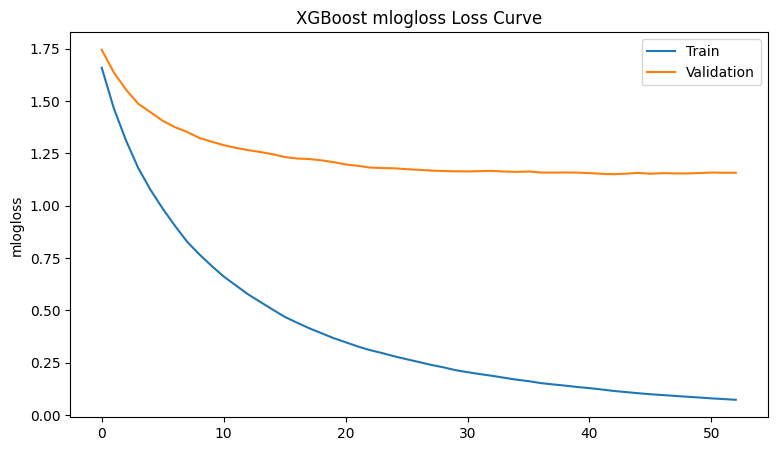

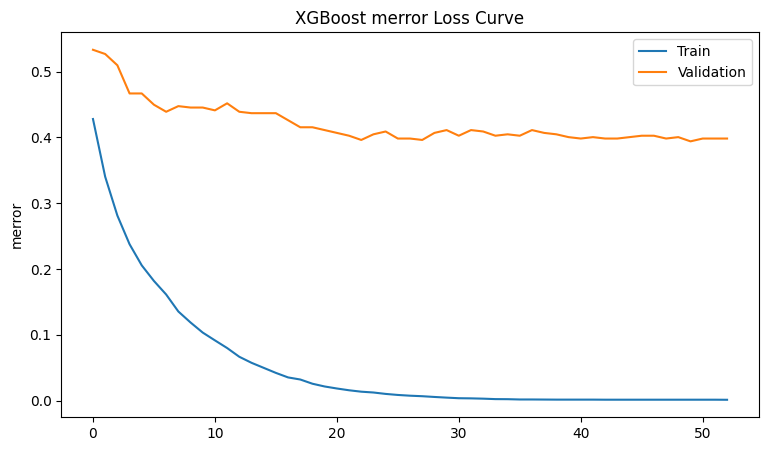

Final Accuracy on Validation Data: 		60.17%


In [ ]:
# prepare loss plots
results = xgb_clf_hog_cor_lbp_edg.evals_result()
epochs = len(results['validation_0']['mlogloss']) # number of epochs
x_axis = range(0, epochs)

# mlogloss plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Validation')
ax.legend()
plt.ylabel('mlogloss')
plt.title('XGBoost mlogloss Loss Curve')
plt.show()

# merror plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Validation')
ax.legend()
plt.ylabel('merror')
plt.title('XGBoost merror Loss Curve')
plt.show()
y_pred = xgb_clf_hog_cor_lbp_edg.predict(val_hog_corner_lbp_canny) # predict using validation data
accuracy = accuracy_score(val_labels, y_pred) # calculate prediction accuracy
print(f'Final Accuracy on Validation Data: \t\t{accuracy:.2%}')

#### Enhanced Images
For the following model, we use enhanced images. At this stage we want to try the effect on the edge detection. Thus, only thos have been extracted on the enhanced images. The other features have been extracted based on the original images.

In [ ]:
xgb_clf_hog_cor_lbp_edg_enhanced = xgb.XGBClassifier(objective='multi:softmax',
                                            num_class=7,
                                            learning_rate=0.3,
                                            gamma=0,
                                            n_estimators=100, # default
                                            max_depth=6, # default
                                            subsample=1, # default
                                            reg_alpha=0, # default
                                            reg_lambda=0, # default
                                            colsample_bytree=1, # default
                                            scale_pos_weight=1, # default
                                            early_stopping_rounds=10,
                                            eval_metric=['merror','mlogloss'],
                                            #verbose=0, # no message display during training and validation
                                            random_state=42)
# fit classifier
xgb_clf_hog_cor_lbp_edg_enhanced.fit(train_enhanced_hog_corner_lbp_canny, train_labels,
                        eval_set=[(train_enhanced_hog_corner_lbp_canny, train_labels), (val_enhanced_hog_corner_lbp_canny, val_labels)]) # define what to evaluate on

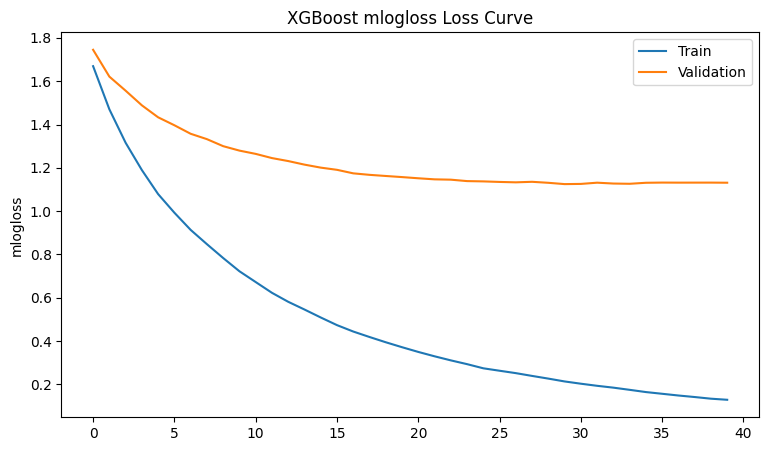

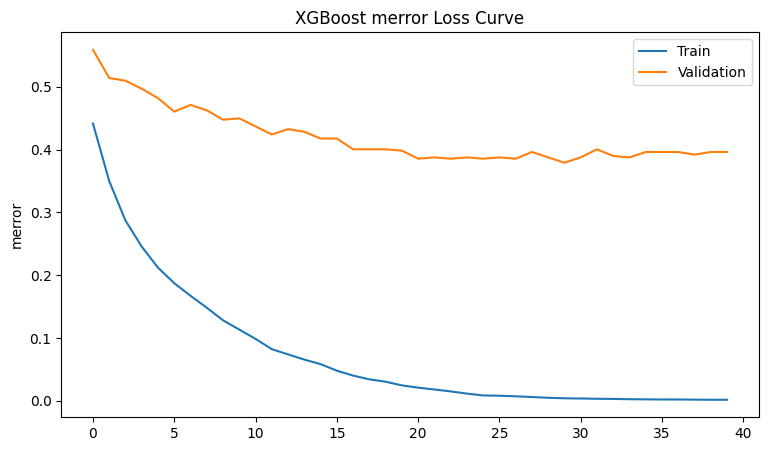

Final Accuracy on Validation Data: 		62.10%


In [ ]:
# prepare loss plots
results = xgb_clf_hog_cor_lbp_edg_enhanced.evals_result()
epochs = len(results['validation_0']['mlogloss']) # number of epochs
x_axis = range(0, epochs)

# mlogloss plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Validation')
ax.legend()
plt.ylabel('mlogloss')
plt.title('XGBoost mlogloss Loss Curve')
plt.show()

# merror plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Validation')
ax.legend()
plt.ylabel('merror')
plt.title('XGBoost merror Loss Curve')
plt.show()
y_pred = xgb_clf_hog_cor_lbp_edg_enhanced.predict(val_enhanced_hog_corner_lbp_canny) # predict using validation data
accuracy = accuracy_score(val_labels, y_pred) # calculate prediction accuracy
print(f'Final Accuracy on Validation Data: \t\t{accuracy:.2%}')

Everything equal, this model improved by almost 2%-points on the validation data just by using enhanced images instead of the original, and then extracting edges from those enhanced images.

In [ ]:
# predict on test data
y_pred_test = xgb_clf_hog_cor_lbp_edg_enhanced.predict(test_enhanced_hog_corner_lbp_canny)

# define test file for kaggle
test_id = np.arange(0, 1136, 1)
pred_file = pd.DataFrame({"ID":test_id, "Predictions": y_pred_test})
pred_file.to_csv("Predictions/46165991-conv-xgb-enhanced-hog-corner-lbp-canny.csv", index=False, header=True)
pred_file.head(5)

,ID,Predictions
0,0,3
1,1,3
2,2,5
3,3,2
4,4,6


In [ ]:
# compare training class frequency and prediction class frequency
class_freq_train = pd.DataFrame({'emotion': label_names, 'train_freq': np.round(percentages,2)}) # create training frequency df

# create prediction frequency df
prediction_counts = np.round(pd.Series(y_pred_test).value_counts(normalize=True).reset_index(),2)
prediction_counts.columns = ['emotion', 'pred_freq']
prediction_counts = prediction_counts.sort_values(by='emotion')
prediction_counts['pred_freq'] = prediction_counts['pred_freq']*100

# map numerical emotion values to actual emotions
prediction_counts['emotion'] = prediction_counts['emotion'].map(label_classes)

# set emotion columns as index
prediction_counts.set_index('emotion', inplace=True)
class_freq_train.set_index('emotion', inplace=True)

raw_svm_freq = pd.merge(class_freq_train, prediction_counts, left_index=True, right_index=True, how='left') # merge on index
raw_svm_freq['pred_freq'].fillna(0, inplace=True) # fill missing prediction classes with zero
raw_svm_freq['freq_deviation'] = raw_svm_freq['train_freq']-raw_svm_freq['pred_freq'] # calculate frequency difference
raw_svm_freq

,train_freq,pred_freq,freq_deviation
emotion,,,
angry,13.57,10.0,3.57
disgusted,2.26,1.0,1.26
fearful,11.87,9.0,2.87
happy,29.33,37.0,-7.67
sad,11.18,8.0,3.18
surprised,11.28,10.0,1.28
neutral,20.51,26.0,-5.49


Note: This model did not improve on the test data compared to xgb-raw-hog-harris.

In [ ]:
train_sharp_hog_corner_canny.shape} \n'
      f'validation: \t{val_sharp_hog_corner_canny.shape} \n'
      f'test: \t\t{test_sharp_hog_corner_canny.shape

## Sharp Images + HOG + Harris Corner + Canny ML Model

### XGBoost

In [ ]:
# handle class imbalances
# from sklearn.utils import class_weight
# classes_weights = class_weight.compute_sample_weight(
#     class_weight='balanced',
#     y=train_df['class']
# )

# xgb_classifier.fit(X, y, sample_weight=classes_weights)

In [ ]:
xgb_clf_hog_cor_edg_sharp = xgb.XGBClassifier(objective='multi:softmax',
                                            num_class=7,
                                            learning_rate=0.3,
                                            gamma=0,
                                            n_estimators=100, # default
                                            max_depth=6, # default
                                            subsample=1, # default
                                            reg_alpha=0, # default
                                            reg_lambda=0, # default
                                            colsample_bytree=1, # default
                                            early_stopping_rounds=10,
                                            eval_metric=['merror','mlogloss'],
                                            #verbose=0, # no message display during training and validation
                                            random_state=42)
# fit classifier
xgb_clf_hog_cor_edg_sharp.fit(train_sharp_hog_corner_canny, train_labels,
                        eval_set=[(train_sharp_hog_corner_canny, train_labels), (val_sharp_hog_corner_canny, val_labels)]) # define what to evaluate on

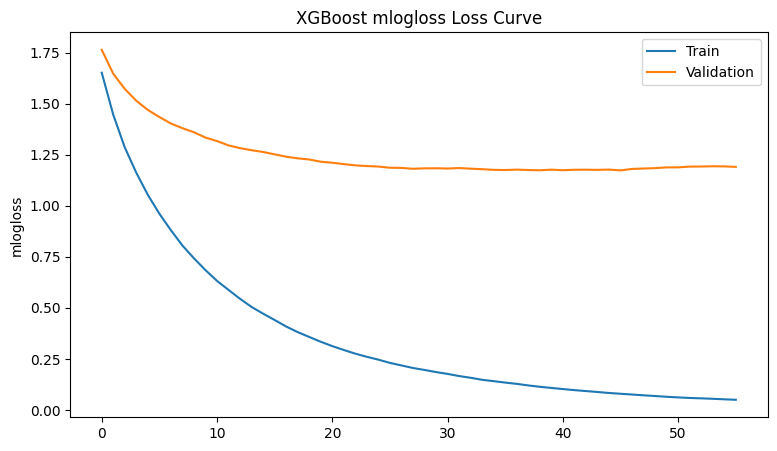

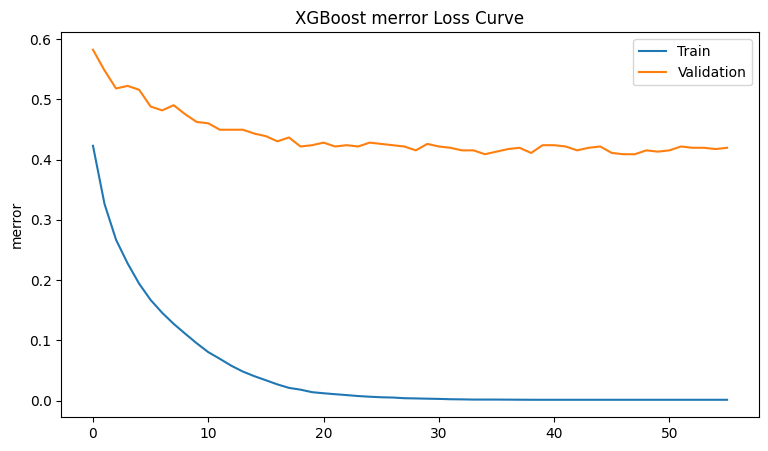

Final Accuracy on Validation Data: 		58.89%


In [ ]:
# prepare loss plots
results = xgb_clf_hog_cor_edg_sharp.evals_result()
epochs = len(results['validation_0']['mlogloss']) # number of epochs
x_axis = range(0, epochs)

# mlogloss plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Validation')
ax.legend()
plt.ylabel('mlogloss')
plt.title('XGBoost mlogloss Loss Curve')
plt.show()

# merror plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Validation')
ax.legend()
plt.ylabel('merror')
plt.title('XGBoost merror Loss Curve')
plt.show()
y_pred = xgb_clf_hog_cor_edg_sharp.predict(val_sharp_hog_corner_canny) # predict using validation data
accuracy = accuracy_score(val_labels, y_pred) # calculate prediction accuracy
print(f'Final Accuracy on Validation Data: \t\t{accuracy:.2%}')

In [ ]:
# save model for reuse without retraining
xgb_clf_hog_cor_edg_sharp.save_model("Models/model_xgb_clf_hog_cor_edg_sharp.json")

# load
# xgb_clf_hog_cor_edg_sharp = xgb.XGBClassifier()
# xgb_clf_hog_cor_edg_sharp.load_model("Models/model_xgb_clf_hog_cor_edg_sharp.json")

NameError: ignored

## Full Image Data + HOG + Corners

In [ ]:
full_train_hog_corner = np.load('Data/full_train_hog_corner.npy')
full_val_hog_corner = np.load('Data/full_val_hog_corner.npy')
full_train_labels= np.load('Data/full_train_labels.npy')
full_val_labels= np.load('Data/full_val_labels.npy')

In [ ]:
xgb_clf_full_hog_corner = xgb.XGBClassifier(objective='multi:softprob',
                                        #num_class=7,
                                        learning_rate=0.3,
                                        gamma=0,
                                        n_estimators=100, # default
                                        max_depth=5, # default
                                        subsample=0.8, # default
                                        colsample_bytree=1, # default
                                        early_stopping_rounds=15,
                                        eval_metric='auc',
                                        #verbose=0, # no message display during training and validation
                                        random_state=42)
# fit classifier
xgb_clf_full_hog_corner.fit(full_train_hog_corner, full_train_labels,
                        eval_set=[(full_train_hog_corner, full_train_labels), (full_val_hog_corner, full_val_labels)]) # define what to evaluate on

[0]	validation_0-auc:0.74068	validation_1-auc:0.71572
[1]	validation_0-auc:0.77761	validation_1-auc:0.75041
[2]	validation_0-auc:0.79993	validation_1-auc:0.76950
[3]	validation_0-auc:0.81742	validation_1-auc:0.78186
[4]	validation_0-auc:0.83047	validation_1-auc:0.79226
[5]	validation_0-auc:0.84052	validation_1-auc:0.80198
[6]	validation_0-auc:0.85046	validation_1-auc:0.80904
[7]	validation_0-auc:0.85897	validation_1-auc:0.81341
[8]	validation_0-auc:0.86619	validation_1-auc:0.81839
[9]	validation_0-auc:0.87225	validation_1-auc:0.82121
[10]	validation_0-auc:0.87752	validation_1-auc:0.82331
[11]	validation_0-auc:0.88300	validation_1-auc:0.82683
[12]	validation_0-auc:0.88782	validation_1-auc:0.83027
[13]	validation_0-auc:0.89225	validation_1-auc:0.83295
[14]	validation_0-auc:0.89626	validation_1-auc:0.83493
[15]	validation_0-auc:0.90018	validation_1-auc:0.83703
[16]	validation_0-auc:0.90394	validation_1-auc:0.83959
[17]	validation_0-auc:0.90718	validation_1-auc:0.84097
[18]	validation_0-au

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              early_stopping_rounds=15, enable_categorical=False,
              eval_metric='auc', feature_types=None, gamma=0, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

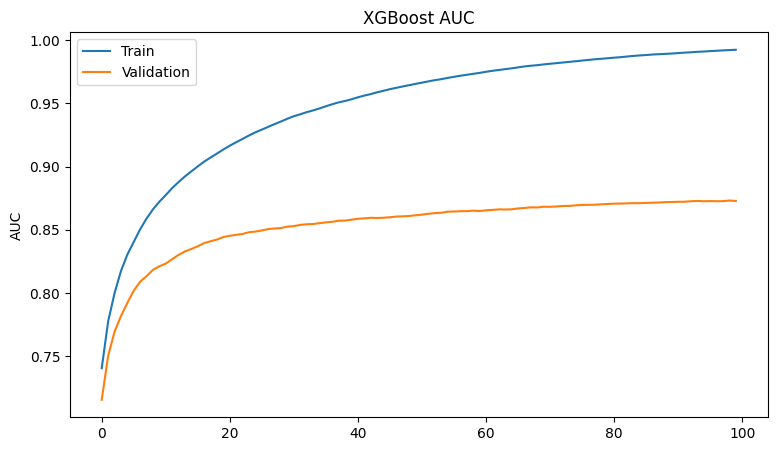

Final Accuracy on Validation Data: 		60.81%


In [ ]:
# prepare loss plots
results = xgb_clf_full_hog_corner.evals_result()
epochs = len(results['validation_0']['auc']) # number of epochs
x_axis = range(0, epochs)

# auc plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Validation')
ax.legend()
plt.ylabel('AUC')
plt.title('XGBoost AUC')
plt.show()

y_pred = xgb_clf_full_hog_corner.predict(full_val_hog_corner) # predict using validation data
accuracy = accuracy_score(full_val_labels, y_pred) # calculate prediction accuracy
print(f'Final Accuracy on Validation Data: \t\t{accuracy:.2%}')

In [ ]:
xgb_clf_full_hog_corner.best_ntree_limit

99

It looks like this model should have had more boosted trees for training.

In [ ]:
# predict on test data
y_pred_test = xgb_clf_full_hog_corner.predict(test_hog_corner)

# define test file for kaggle
test_id = np.arange(0, 1136, 1)
pred_file = pd.DataFrame({"ID":test_id, "Predictions": y_pred_test})
pred_file.to_csv("Predictions/46165991-conv-xgb-raw-full.csv", index=False, header=True)
pred_file.head(5)

This model achieved a test accuracy of %.

In [ ]:
# save model for reuse without retraining
xgb_clf_full_hog_corner.save_model('Models/xgb_clf_full_hog_corner.json')

# load
# xgb_clf_full = xgb.XGBClassifier()
# xgb_clf_full.load_model("Models/model_xgb_clf_full.json")

In [ ]:
print(classification_report(val_labels, y_pred))

## Full+HOG+Corners+LBP+Canny+GLCM

In [ ]:
# load augmented flattened image data
full_train_data_flat = np.load('Data/full_train_data_flat.npy')
full_val_data_flat = np.load('Data/full_val_data_flat.npy')

# load label data
full_train_labels = np.load('Data/full_train_labels.npy')
full_val_labels = np.load('Data/full_val_labels.npy')

In [ ]:
xgb_clf_full = xgb.XGBClassifier(objective='multi:softprob',
                                        #num_class=7,
                                        learning_rate=0.3,
                                        gamma=0,
                                        n_estimators=200, # default
                                        max_depth=5, # default
                                        subsample=0.9, # default
                                        colsample_bytree=1, # default
                                        early_stopping_rounds=15,
                                        eval_metric='auc',
                                        #verbose=0, # no message display during training and validation
                                        random_state=42)
# fit classifier
xgb_clf_full.fit(full_train_data_flat, full_train_labels,
                        eval_set=[(full_train_data_flat, full_train_labels), (full_val_data_flat, full_val_labels)]) # define what to evaluate on

[0]	validation_0-auc:0.73924	validation_1-auc:0.70173
[1]	validation_0-auc:0.78309	validation_1-auc:0.74554
[2]	validation_0-auc:0.80524	validation_1-auc:0.75900
[3]	validation_0-auc:0.82320	validation_1-auc:0.77093
[4]	validation_0-auc:0.83592	validation_1-auc:0.77990
[5]	validation_0-auc:0.84748	validation_1-auc:0.78643
[6]	validation_0-auc:0.85629	validation_1-auc:0.79014
[7]	validation_0-auc:0.86338	validation_1-auc:0.79637
[8]	validation_0-auc:0.87066	validation_1-auc:0.79925
[9]	validation_0-auc:0.87636	validation_1-auc:0.80349
[10]	validation_0-auc:0.88209	validation_1-auc:0.80630
[11]	validation_0-auc:0.88745	validation_1-auc:0.81139
[12]	validation_0-auc:0.89207	validation_1-auc:0.81201
[13]	validation_0-auc:0.89603	validation_1-auc:0.81365
[14]	validation_0-auc:0.89980	validation_1-auc:0.81642
[15]	validation_0-auc:0.90311	validation_1-auc:0.81805
[16]	validation_0-auc:0.90720	validation_1-auc:0.82028
[17]	validation_0-auc:0.91023	validation_1-auc:0.82082
[18]	validation_0-au

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              early_stopping_rounds=15, enable_categorical=False,
              eval_metric='auc', feature_types=None, gamma=0, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

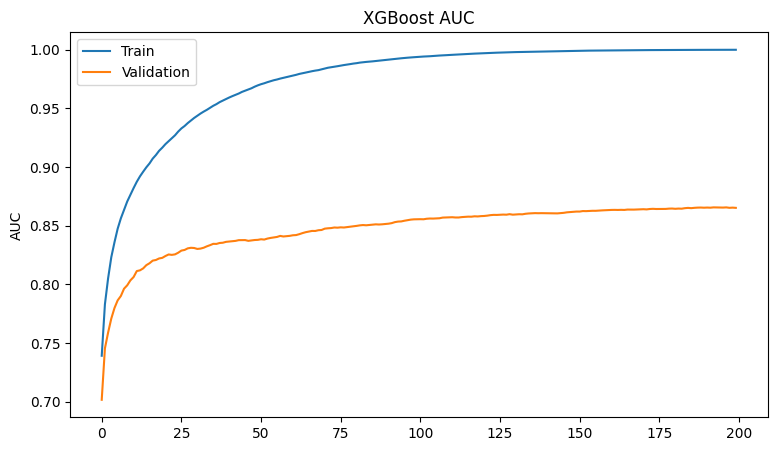

Final Accuracy on Validation Data: 		61.54%


In [ ]:
# prepare loss plots
results = xgb_clf_full.evals_result()
epochs = len(results['validation_0']['auc']) # number of epochs
x_axis = range(0, epochs)

# auc plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Validation')
ax.legend()
plt.ylabel('AUC')
plt.title('XGBoost AUC')
plt.show()

y_pred = xgb_clf_full.predict(full_val_data_flat) # predict using validation data
accuracy = accuracy_score(full_val_labels, y_pred) # calculate prediction accuracy
print(f'Final Accuracy on Validation Data: \t\t{accuracy:.2%}')

In [ ]:
# predict on test data
y_pred_test = xgb_clf_full.predict(test_data_flat)

# define test file for kaggle
test_id = np.arange(0, 1136, 1)
pred_file = pd.DataFrame({"ID":test_id, "Predictions": y_pred_test})
pred_file.to_csv("Predictions/46165991-conv-xgb-full.csv", index=False, header=True)
pred_file.head(5)

,ID,Predictions
0,0,3
1,1,3
2,2,2
3,3,0
4,4,6


In [ ]:
# save model for reuse without retraining
xgb_clf_full.save_model('Models/model_xgb_clf_full.json')

# load
# xgb_clf_full = xgb.XGBClassifier()
# xgb_clf_full.load_model("Models/model_xgb_clf_full.json")

In [ ]:
print(classification_report(full_val_labels, y_pred))

              precision    recall  f1-score   support

           0       0.56      0.41      0.47       315
           1       1.00      0.62      0.76        55
           2       0.47      0.32      0.38       275
           3       0.71      0.85      0.77       685
           4       0.41      0.25      0.31       260
           5       0.76      0.70      0.73       265
           6       0.54      0.74      0.62       480

    accuracy                           0.62      2335
   macro avg       0.63      0.56      0.58      2335
weighted avg       0.60      0.62      0.60      2335



# Discussion on Conventional ML Model

For the final model, hyperparameters were chosen by ...

In addition to the final model, I also tried a logistic regression model, ...  This performed fairly poorly (accuracy y%) ...  This may have been because ...

# Deep Learning Model

The final model that produced the best-performing predictions for the Kaggle submission (accuracy (x+5)%) was a fully connected dense model with NN layers.  The input was the raw data that had been preprocessed by ...

### Baseline Model
We will build a Neural Net with a simple architecture first. This will act as a baseline for more complex architectures to be evaluated against that baseline.

## Data Preprocessing
https://machinelearningmastery.com/best-practices-for-preparing-and-augmenting-image-data-for-convolutional-neural-networks/

https://prince-canuma.medium.com/image-pre-processing-c1aec0be3edf

https://www.kaggle.com/code/khotijahs1/cv-image-preprocessing

https://iq.opengenus.org/basics-of-machine-learning-image-classification-techniques/

### Data Augmentation
https://www.section.io/engineering-education/image-preprocessing-in-python/

## Regularisation
e.g. Monte Carlo Droput

[Following this, code and comments as above.]

# Discussion on Deep Learning Model

For the final model, hyperparameters were chosen by ...

In addition to the final model, I also tried a CNN with two conv layers and ...  This performed almost as well as the final model (accuracy (x-3)%) ...  This gap in performance may have been because ...

# Discussion of Model Performance and Implementation

Comparing my final conventional ML and deep learning models, the deep learning one performed better by 5% on the public test set.  The deep learning model ranked #12 out of N submissions on the public test set, with the top-performing system having z% accuracy, and a majority class baseline having z'% accuracy ...

[E.g. discussion about what performance on validation set versus public test set might say about your models or about the dataset.]

[E.g. discussion about what performance on private test set versus public test set might say about your models or about the dataset.]

[E.g. discussion about what inspecting the data might say about your models or about the dataset.]

[E.g. reflection on resource required for models or other implementation issues.]

